# Utils

In [4]:
import json
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gzip, pickle
from typing import Optional

## 경로 설정

In [5]:

# Dataset
ITEM_ATTR_CSV = os.path.join("/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format", "item_attribute.csv")
DATA_BASE_DIR = "/home/parkdw00/Codes/data/ml-1m"
U_ITEM_PATH   = f"/home/parkdw00/Codes/data/ml-1m/5core/item_meta_2017_kcore5_user_item.json"
META_GZ_PATH  = f"{DATA_BASE_DIR}/ml-1m_text_name_dict.json.gz"
PARTS = 5

test_path = os.path.join(DATA_BASE_DIR, "label.txt")
train_path = os.path.join(DATA_BASE_DIR, "train.txt")


######################### A-LLMRec #########################
# BASE_DIR = f"/home/parkdw00/Codes/data/ml-1m/A-LLMRec_format/A-LLMRec_results"
# PRED_P1 = f"{BASE_DIR}/predict_label_part1.json"
# PRED_P5 = f"{BASE_DIR}/predict_label_part5.json"


######################### LLMRec #########################
BASE_DIR = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format"
PRED_P1    = f"{BASE_DIR}/predict_label_part1.json"
PRED_P5    = f"{BASE_DIR}/predict_label_part5.json"


# # ###################### Augmentation #######################
# BASE_DIR = f"/home/parkdw00/Codes/data/ml-1m/Augmentation_format"
# PRED_P1    = f"{BASE_DIR}/predict_label_part1.json"
# PRED_P5    = f"{BASE_DIR}/predict_label_part5.json"


###################### Traditional CF ######################
# model = "LightGCN"  # "MF-BPR" or "LightGCN"
# BASE_DIR = f"/home/parkdw00/Codes/data/ml-1m/traditionalCF"
# PRED_P1    = f"{BASE_DIR}/predict_label_part1.json"
# PRED_P5    = f"{BASE_DIR}/predict_label_part5.json"

print(PRED_P5)
with open(PRED_P5) as f:
    pred_dict = json.load(f)
print(pred_dict["0"][:30])  # user 0의 상위 10개 예측 아이템 ID

actual = sum(len(v) for v in pred_dict.values())
print("actual predict_label interactions:", actual)


/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/predict_label_part5.json
[591, 1765, 1108, 1195, 1126, 3638, 1017, 1940, 885, 1771, 1758, 2841, 2120, 1016, 2868, 1023, 3299, 1088, 1024, 1146, 858, 3688, 1766, 3025, 1075, 309, 2921, 2856, 512, 1553]
actual predict_label interactions: 104540


In [6]:
train_data = {}
with open(train_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        u_str, i_str, _ = line.split()
        u = str(u_str)         # 키는 문자열로
        i = int(i_str)         # 아이템은 정수로 (혹은 문자열로 둘 수도 있음)

        if u not in train_data:
            train_data[u] = []
        train_data[u].append(i)

ground_truth = {}
with open(test_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        u_str, i_str, _ = line.split()
        u = str(u_str)
        i = int(i_str)
        # ground truth가 여러 개면 리스트에 append, 한 개만 있으면 덮어쓰거나 첫 개만 쓰면 됨
        if u not in ground_truth:
            ground_truth[u] = []
        ground_truth[u].append(i)

# 공통 사용자
common_users = set(train_data.keys()) & set(ground_truth.keys())
print(len(train_data.keys()))
print(len(ground_truth.keys()))
print(len(common_users))

# ground truth에서 가장 긴 기록을 가진 사용자 검색, 해당 사용자의 기록 길이 확인
max_len_user = max(ground_truth.items(), key=lambda x: len(x[1]))
print(f"User with the longest ground truth interaction: {max_len_user[0]}, Length: {len(max_len_user[1])}")

5400
1143
1143
User with the longest ground truth interaction: 453, Length: 1062


### Multi-hot-vector

X shape: (5400, 3662) nnz: 800167
X_svd shape: (5400, 100) explained_var_ratio_sum: 0.46380818

Total users: 5400

Users per cluster (%)
Cluster 0: 967 users (17.91%)
Cluster 1: 4433 users (82.09%)


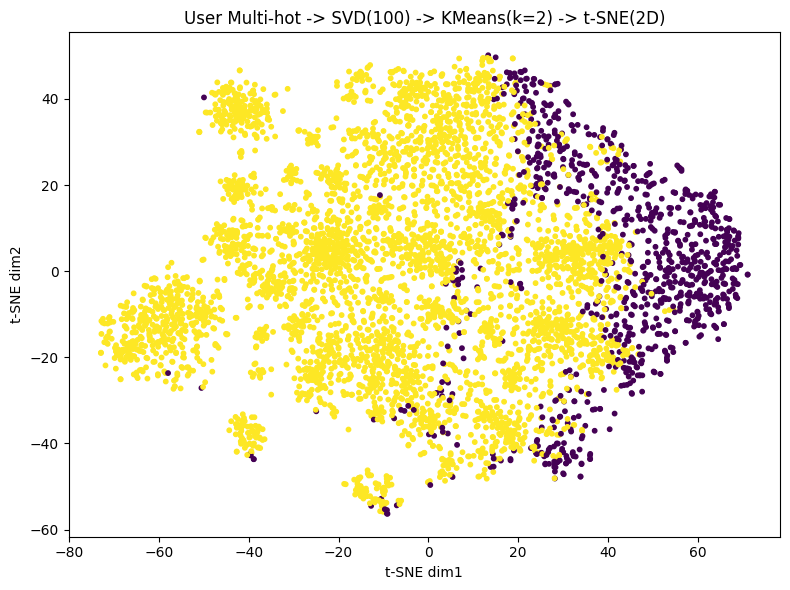

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

# -----------------------------
# 1) train_data -> multi-hot (sparse CSR)
# -----------------------------
# train_data: { "user_id(str)": [item_id(int), ...], ... }

users = list(train_data.keys())
random_seed = 42

# item universe(전체 아이템 id) 수집
all_items = set()
for u in users:
    all_items.update(train_data[u])#[-10:])

# item_id가 0..N-1로 연속이 아닐 수 있으니 -> cold item일 수 있으니
item_list = sorted(all_items)
item2col = {item: idx for idx, item in enumerate(item_list)}

n_users = len(users)
n_items = len(item_list)

# CSR 만들기: (row=user, col=item) 위치에 1
rows = []
cols = []
data = []
for r, u in enumerate(users):
    # 중복 interaction은 1로 처리(멀티핫)
    seen_list = train_data[u]#[-10:] 
    seen = set(seen_list)
    for item in seen:
        rows.append(r)
        cols.append(item2col[item])
        data.append(1)

X = csr_matrix((data, (rows, cols)), shape=(n_users, n_items), dtype=np.float32)
print("X shape:", X.shape, "nnz:", X.nnz)

# -----------------------------
# 2) 고차원 희소벡터 -> 저차원 임베딩 (SVD)
# -----------------------------
# KMeans는 고차원 희소에서 바로 돌려도 되지만,
# 보통 SVD로 50~200 차원 정도로 줄이면 훨씬 안정적임.
svd_dim = min(100, n_items - 1) if n_items > 1 else 1
svd = TruncatedSVD(n_components=svd_dim, random_state=random_seed)
X_svd = svd.fit_transform(X)
print("X_svd shape:", X_svd.shape, "explained_var_ratio_sum:", svd.explained_variance_ratio_.sum())

# -----------------------------
# 3) K-means
# -----------------------------
k = 2  # 원하는 클러스터 수로 바꿔
kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_seed)
labels = kmeans.fit_predict(X_svd)


# -----------------------------
# cluster별 사용자 수 출력
# -----------------------------
cluster_cnt = Counter(labels)

print(f"\nTotal users: {sum(cluster_cnt.values())}")

print("\nUsers per cluster (%)")
for c in sorted(cluster_cnt.keys()):
    ratio = cluster_cnt[c] / len(labels) * 100
    print(f"Cluster {c}: {cluster_cnt[c]} users ({ratio:.2f}%)")

# -----------------------------
# 4) 2D 시각화 좌표 만들기 (t-SNE)
# -----------------------------
# 사용자 수가 아주 많으면(수만 이상) t-SNE는 느릴 수 있음 -> 아래 subsample 옵션 사용 권장
use_subsample = False
max_points = 5000

if use_subsample and n_users > max_points:
    rng = np.random.RandomState(random_seed)
    idx = rng.choice(n_users, size=max_points, replace=False)
    X_vis_in = X_svd[idx]
    labels_vis = labels[idx]
else:
    X_vis_in = X_svd
    labels_vis = labels

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=random_seed,
)
Z = tsne.fit_transform(X_vis_in)

# -----------------------------
# 5) Plot
# -----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=labels_vis, s=10)
plt.title(f"User Multi-hot -> SVD({svd_dim}) -> KMeans(k={k}) -> t-SNE(2D)")
plt.xlabel("t-SNE dim1")
plt.ylabel("t-SNE dim2")
plt.tight_layout()
plt.show()


# RQ1
추천 파이프라인 속에서 LLM이 생성한 데이터의 편향/환각 현상 분석

포함: LLMRec, Augmentation

## LLMRec

### Bias

In [8]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# =========================
# Paths
# =========================

SAVE_DIR = os.path.join(BASE_DIR, "result_analysis")
save_dir = os.path.join(SAVE_DIR, "poster")
os.makedirs(save_dir, exist_ok=True)

USER_INFO_TXT = "/home/parkdw00/Codes/data/ml-1m/user_info.txt"

# =========================
# Parsers
# =========================
def parse_genres(genre_raw):
    """
    다양한 포맷의 장르 문자열을 리스트로 변환
    1) "['Action', 'Comedy']"
    2) "Action|Comedy" (ML-1M 원본 스타일)
    3) "Action, Comedy"
    4) "Action"
    """
    if pd.isna(genre_raw):
        return []

    genre_str = str(genre_raw).strip()
    if not genre_str:
        return []

    try:
        if genre_str.startswith("[") and genre_str.endswith("]"):
            parsed = ast.literal_eval(genre_str)
            return [str(g).strip() for g in parsed if str(g).strip()]
        elif "|" in genre_str:
            return [g.strip() for g in genre_str.split("|") if g.strip()]
        elif "," in genre_str:
            return [g.strip() for g in genre_str.split(",") if g.strip()]
        else:
            return [genre_str]
    except Exception:
        # 파싱 실패 시 원문을 단일 장르로 취급
        return [genre_str]

# (선택) ML-1M Occupation 코드 -> 라벨 (원하면 사용)
OCCUPATION_MAP = {
    0: "other",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}

# =========================
# Generic plotting utilities
# =========================
def counter_to_df(counter: Counter, key_name: str):
    df = pd.DataFrame(counter.items(), columns=[key_name, "Count"])
    df = df.sort_values("Count", ascending=False).reset_index(drop=True)
    return df

def plot_and_save_barh(
    df: pd.DataFrame,
    category_col: str,
    count_col: str,
    title: str,
    save_path: str,
    top_k: int = 20,
    color: str = "cornflowerblue",
):
    if df.empty:
        print(f"⚠️ Empty dataframe: {title}")
        return

    df_plot = df.head(top_k).copy() if len(df) > top_k else df.copy()

    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        df_plot[category_col][::-1],
        df_plot[count_col][::-1],
        color=color,
        edgecolor="black",
        alpha=0.9,
    )

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + (width * 0.01),
            bar.get_y() + bar.get_height() / 2,
            f"{int(width)}",
            ha="left",
            va="center",
            fontsize=10,
            fontweight="bold",
        )

    plt.title(title, fontsize=15, fontweight="bold")
    plt.xlabel("Count", fontsize=12)
    plt.ylabel(category_col, fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"✅ Saved: {save_path}")

# =========================
# 1) Genre distribution
# =========================
def load_item_attributes(item_attr_csv: str) -> pd.DataFrame:
    if not os.path.exists(item_attr_csv):
        raise FileNotFoundError(f"❌ File not found: {item_attr_csv}")
    df = pd.read_csv(item_attr_csv, names=["id", "year", "title", "genre"], header=None)
    return df

def compute_genre_distribution_df(item_attr_df: pd.DataFrame) -> pd.DataFrame:
    all_genres = []
    for genre_raw in item_attr_df["genre"]:
        all_genres.extend(parse_genres(genre_raw))
    counter = Counter(all_genres)
    return counter_to_df(counter, "Genre")

def save_genre_distribution(
    item_attr_csv: str,
    save_dir: str,
    top_k: int = 20,
):
    item_df = load_item_attributes(item_attr_csv)
    genre_df = compute_genre_distribution_df(item_df)

    save_path = os.path.join(save_dir, "Real_Genre_Distribution_ML1M.png")
    title = f"Distribution of Movie Genres (Unique: {genre_df['Genre'].nunique()}, Total tags: {genre_df['Count'].sum()})"
    plot_and_save_barh(
        df=genre_df,
        category_col="Genre",
        count_col="Count",
        title=title,
        save_path=save_path,
        top_k=top_k,
    )

    print("\n🏆 Top 5 Genres:")
    print(genre_df.head(5))

# =========================
# 2) Occupation distribution
# =========================
def load_user_info(user_info_txt: str) -> pd.DataFrame:
    if not os.path.exists(user_info_txt):
        raise FileNotFoundError(f"❌ File not found: {user_info_txt}")

    # 헤더 포함 + 공백/탭 혼합 가능성 -> 정규식 구분자
    df = pd.read_csv(user_info_txt, sep=r"\s+", engine="python")
    # 기대 컬럼: new_id Gender Age Occupation ZipCode
    expected = {"new_id", "Gender", "Age", "Occupation", "ZipCode"}
    if not expected.issubset(set(df.columns)):
        raise ValueError(f"❌ Unexpected columns: {df.columns.tolist()}")
    return df

def compute_occupation_distribution_df(user_df: pd.DataFrame, use_label: bool = True) -> pd.DataFrame:
    occ_series = user_df["Occupation"].astype(int)

    if use_label:
        occ_name = occ_series.map(lambda x: OCCUPATION_MAP.get(int(x), f"occ_{int(x)}"))
        counter = Counter(occ_name.tolist())
        return counter_to_df(counter, "Occupation")
    else:
        counter = Counter(occ_series.tolist())
        df = counter_to_df(counter, "Occupation")
        df["Occupation"] = df["Occupation"].astype(str)
        return df

def save_occupation_distribution(
    user_info_txt: str,
    save_dir: str,
    top_k: int = 20,
    use_label: bool = True,
):
    user_df = load_user_info(user_info_txt)
    occ_df = compute_occupation_distribution_df(user_df, use_label=use_label)

    save_path = os.path.join(save_dir, "Real_Occupation_Distribution_ML1M.png")
    title = f"Distribution of User Occupations (Unique: {occ_df['Occupation'].nunique()}, Total users: {occ_df['Count'].sum()})"
    plot_and_save_barh(
        df=occ_df,
        category_col="Occupation",
        count_col="Count",
        title=title,
        save_path=save_path,
        top_k=top_k,
        color="lightseagreen",
    )

    print("\n🏆 Top 5 Occupations:")
    print(occ_df.head(5))

# =========================
# Run
# =========================
if __name__ == "__main__":
    save_genre_distribution(ITEM_ATTR_CSV, save_dir, top_k=20)
    save_occupation_distribution(USER_INFO_TXT, save_dir, top_k=20, use_label=True)


✅ Saved: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/poster/Real_Genre_Distribution_ML1M.png

🏆 Top 5 Genres:
      Genre  Count
0     Drama   1485
1    Comedy   1160
2    Action    495
3  Thriller    483
4   Romance    459
✅ Saved: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/poster/Real_Occupation_Distribution_ML1M.png

🏆 Top 5 Occupations:
             Occupation  Count
0  college/grad student    677
1                 other    640
2  executive/managerial    617
3     academic/educator    469
4   technician/engineer    439


✅ 파일 로드 성공: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_user_profiling_dict_part5_step0_try0 (총 5400명)
🔄 데이터 파싱 및 추출 중...
✅ 처리 완료: 5400명 파싱 성공

========== 시각화 시작 ==========
📊 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Profile_age.png
📊 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Profile_gender.png
📊 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Profile_occupation.png
📊 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Profile_country.png
📊 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Profile_language.png
📊 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Profile_liked_genre.png
📊 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Profile_disliked_genre.png
📊 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/ste

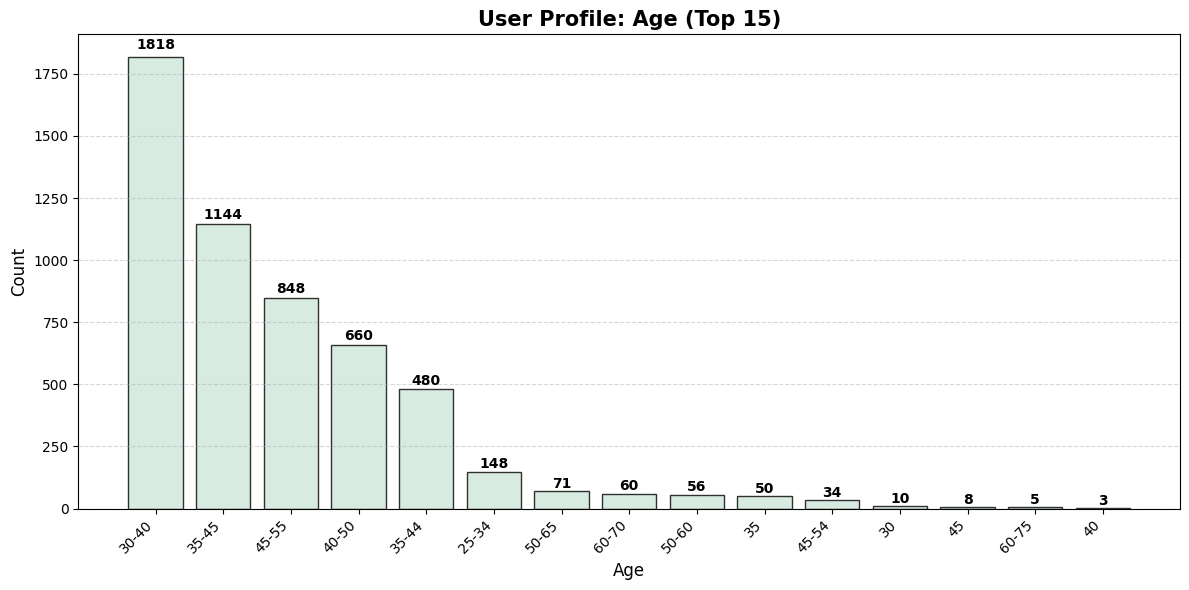

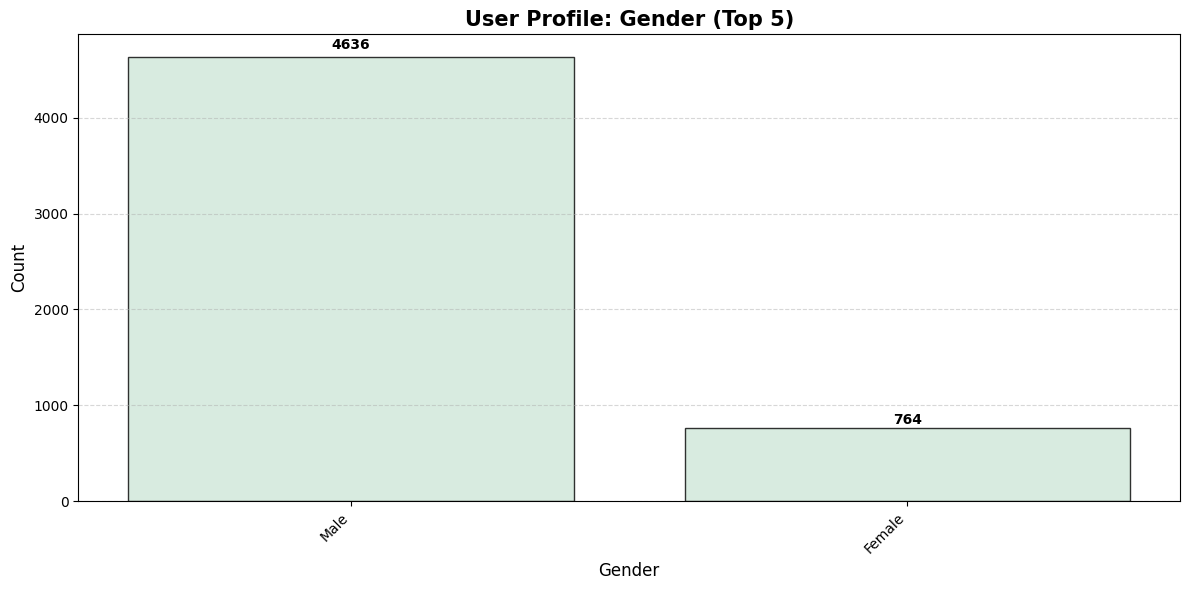

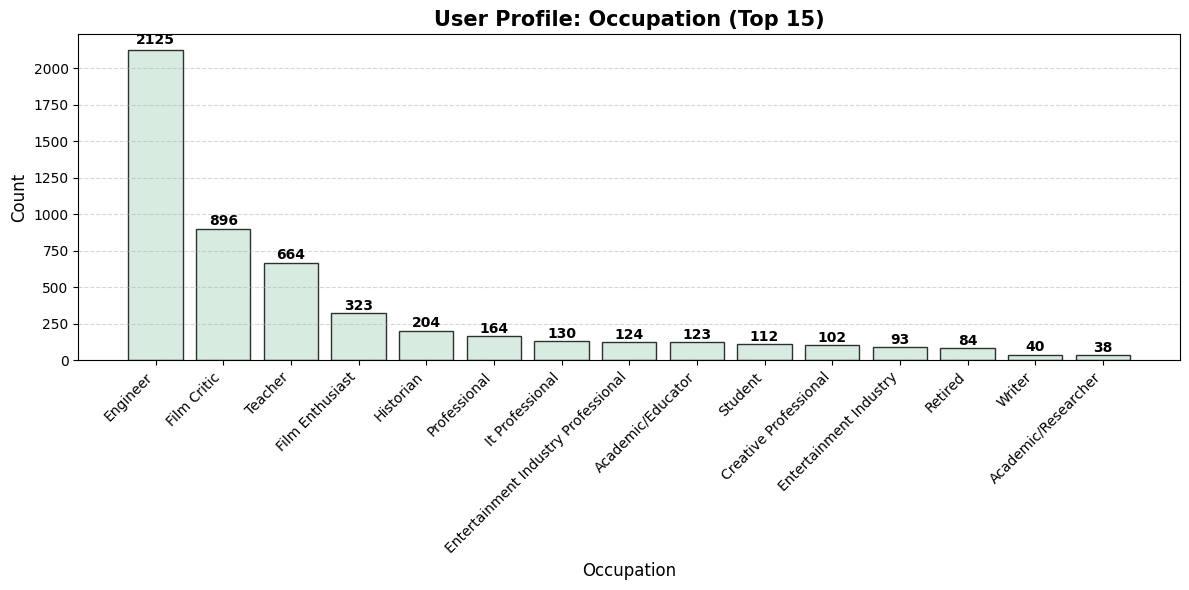

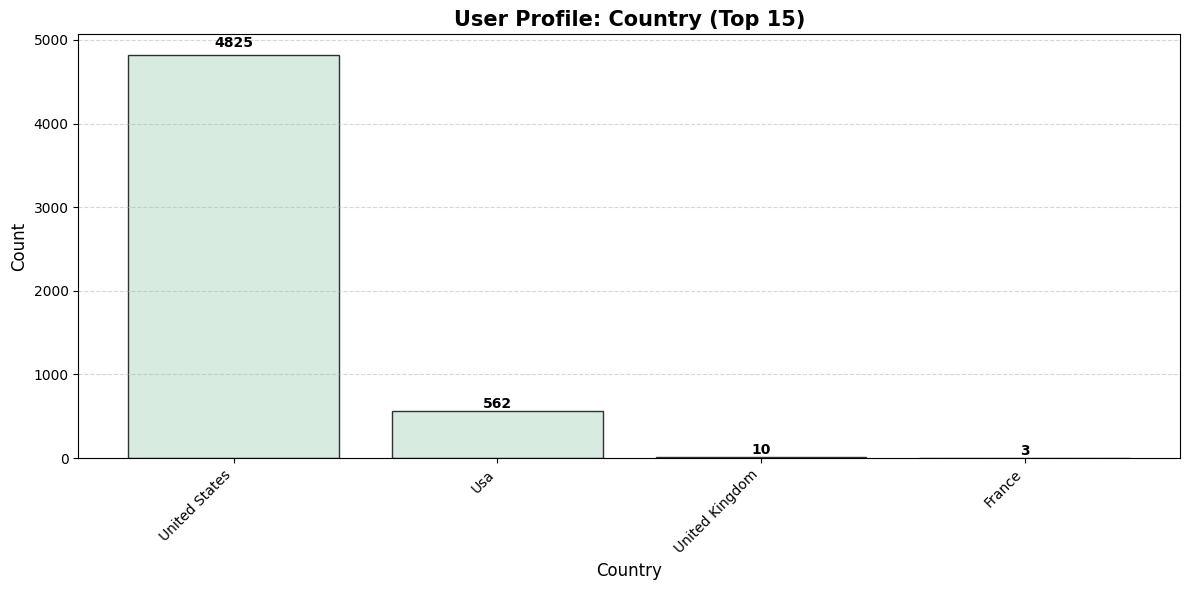

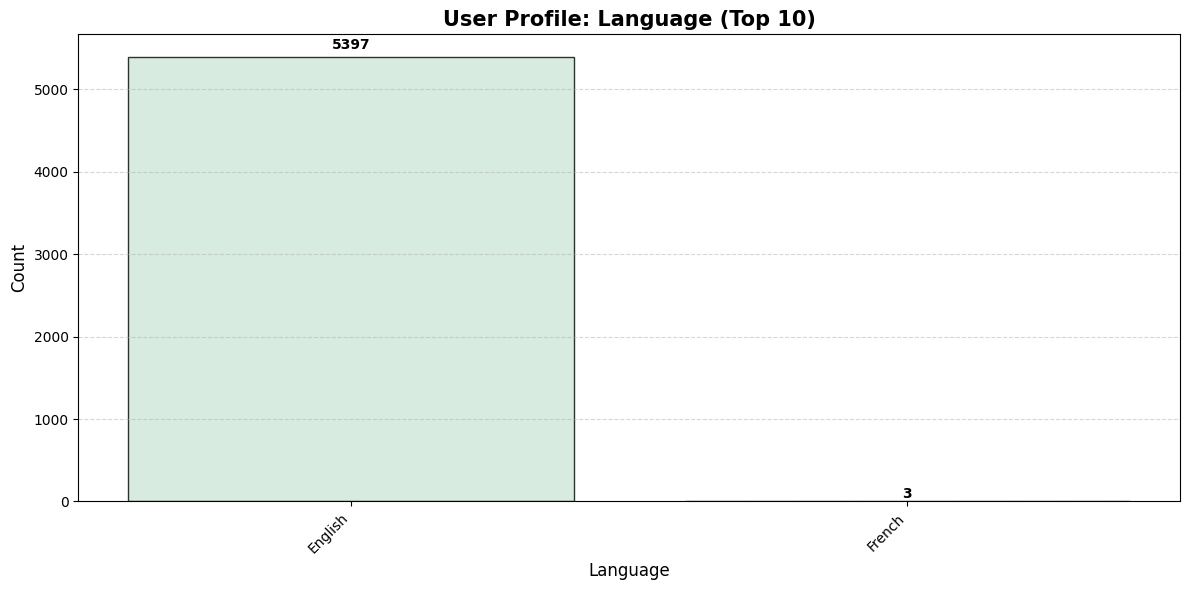

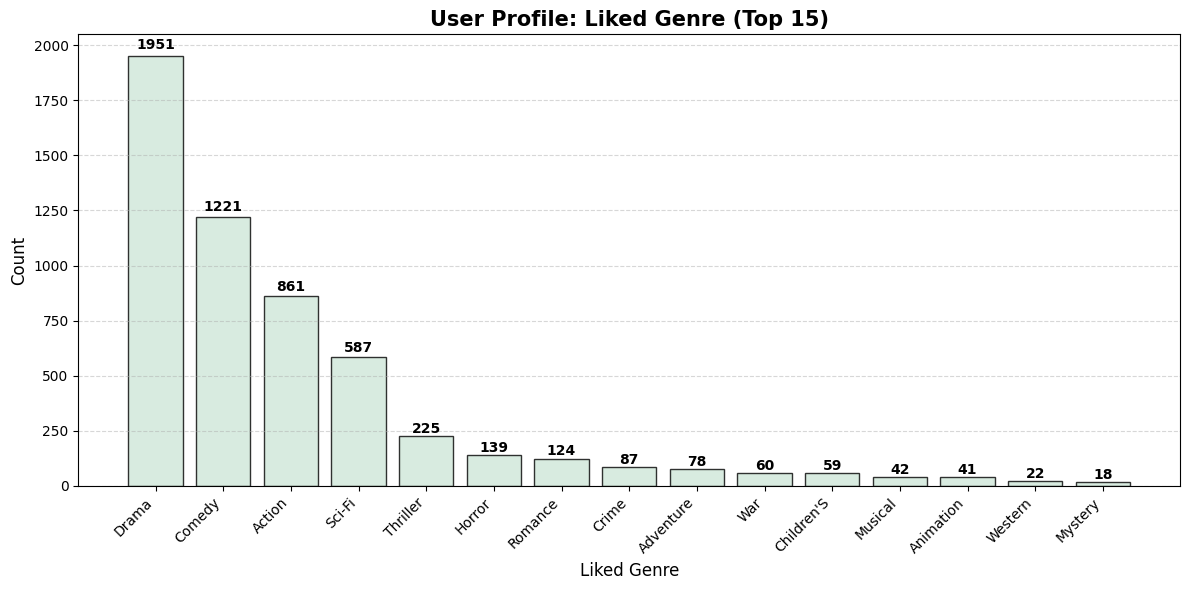

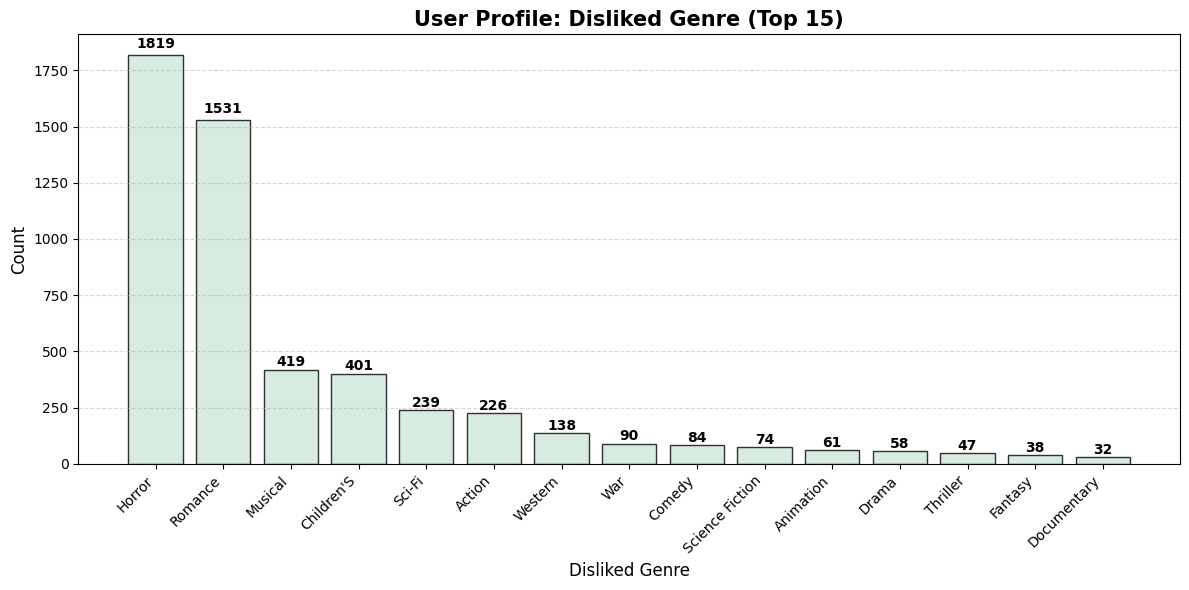

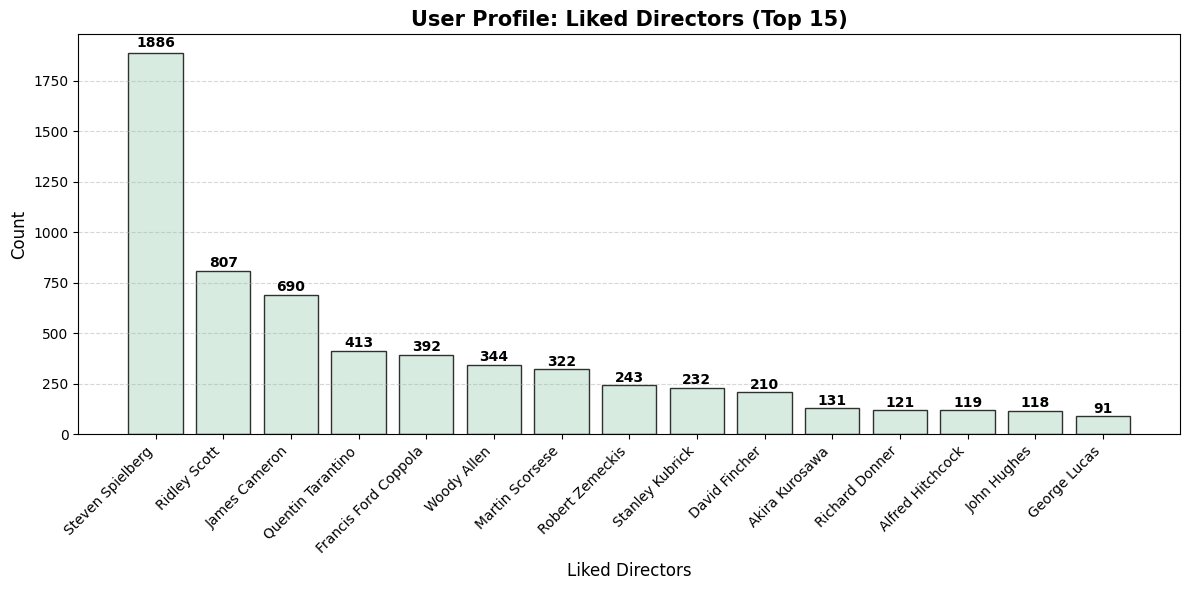

In [7]:
import matplotlib.pyplot as plt
import pickle
import json
import ast
import re
from collections import Counter
import pandas as pd
import os

# ✅ 경로 설정
file_path = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_user_profiling_dict_part5_step0_try0"

SEAGREEN_WHITE70 = "#CFE6D9"

# ✅ 1. 분석할 키(Key) 재정의 (스크린샷 기준)
# 스크린샷에 있는 키들을 기준으로 설정합니다.
target_keys = [
    'age', 'gender', 'occupation',
    'country', 'language',
    'liked_genre', 'disliked_genre', 
    'liked_directors', 'liked_actors' # actors는 스크린샷엔 없지만 보통 쌍으로 존재하므로 추가 (필요 없으면 제거)
]

# 데이터를 저장할 딕셔너리 초기화
data_storage = {key: [] for key in target_keys}

# ✅ 데이터 로드
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        augmented_dict = pickle.load(f)
    print(f"✅ 파일 로드 성공: {file_path} (총 {len(augmented_dict)}명)")
else:
    print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
    augmented_dict = {}

# ✅ 데이터 파싱 및 정제 함수
def clean_and_parse(profile_text):
    # 텍스트 정제
    cleaned = profile_text.strip()
    cleaned = cleaned.replace("'''", "").replace('```json', '').replace('```', '')
    cleaned = cleaned.replace('\n', ' ').replace('\r', '')
    
    # 일반적인 JSON 오류 수정 (예: Children's -> Childrens)
    cleaned = re.sub(r"(\w+)['’]s", r"\1s", cleaned) 

    try:
        return json.loads(cleaned)
    except json.JSONDecodeError:
        try:
            return ast.literal_eval(cleaned)
        except:
            # 강제 따옴표 변환 시도
            try:
                cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
                return json.loads(cleaned_forced)
            except:
                return None

# ✅ 키 정규화 함수 (핵심 수정 사항)
def normalize_keys(profile):
    """
    LLM이 생성한 다양한 키 이름을 스크린샷의 표준 포맷(언더바, 복수형)으로 통일합니다.
    예: 'Liked Genre' -> 'liked_genre', 'liked director' -> 'liked_directors'
    """
    new_profile = {}
    for k, v in profile.items():
        # 1. 소문자 변환 및 공백을 언더바로 변경
        new_key = k.lower().strip().replace(' ', '_')
        
        # 2. 단수/복수형 및 예외 처리 매핑
        if new_key == 'liked_director': new_key = 'liked_directors'
        if new_key == 'liked_actor': new_key = 'liked_actors'
        if new_key == 'disliked_director': new_key = 'disliked_directors'
        
        new_profile[new_key] = v
    return new_profile

# ✅ 메인 루프: 데이터 추출
print("🔄 데이터 파싱 및 추출 중...")
success_count = 0

for user_id, profile_text in augmented_dict.items():
    raw_profile = clean_and_parse(profile_text)
    
    if not raw_profile:
        continue
    
    # ⭐️ 키 정규화 적용 (스크린샷 포맷에 맞춤)
    profile = normalize_keys(raw_profile)
    success_count += 1

    for key in target_keys:
        val = profile.get(key, None)
        
        if val:
            # 1) 리스트인 경우
            if isinstance(val, list):
                cleaned_items = [str(item).strip().title() for item in val if item]
                data_storage[key].extend(cleaned_items)
            
            # 2) 문자열인 경우 (스크린샷처럼 쉼표로 구분된 문자열 처리)
            elif isinstance(val, str):
                val = val.strip()
                if val.lower() in ['unknown', 'none', 'n/a', '', 'null']:
                    continue
                
                # 쉼표 구분 처리 (예: "Krzysztof Kieślowski, George Miller")
                if ',' in val:
                    cleaned_items = [item.strip().title() for item in val.split(',')]
                    data_storage[key].extend(cleaned_items)
                else:
                    # Gender 처리
                    if key == 'gender':
                        g = val.lower()
                        if g.startswith('m'): data_storage[key].append('Male')
                        elif g.startswith('f'): data_storage[key].append('Female')
                        else: data_storage[key].append(val.title())
                    else:
                        data_storage[key].append(val.title())

print(f"✅ 처리 완료: {success_count}명 파싱 성공")

# ✅ 시각화 함수
def plot_distribution(category_name, data_list, top_k=10, color=SEAGREEN_WHITE70, title_alias=None):
    if not data_list:
        print(f"⚠️ {category_name} - 데이터가 없습니다.")
        return

    # 화면에 표시할 제목 설정 (예: liked_genre -> Liked Genre)
    display_title = title_alias if title_alias else category_name.replace('_', ' ').title()

    counter = Counter(data_list)
    df = pd.DataFrame.from_dict(counter, orient='index', columns=['Count']).reset_index()
    df.rename(columns={'index': 'Category'}, inplace=True)
    
    df_topk = df.sort_values(by='Count', ascending=False).head(top_k).reset_index(drop=True)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(df_topk['Category'], df_topk['Count'], color=color, edgecolor='black', alpha=0.8)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.01), int(yval), 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(f"User Profile: {display_title} (Top {top_k})", fontsize=15, fontweight='bold')
    plt.xlabel(display_title, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    os.makedirs(save_dir, exist_ok=True)
    filename = f"Profile_{category_name}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    print(f"📊 저장 완료: {save_path}")
    # plt.show()

# ✅ 실행: 각 키별 시각화
print("\n========== 시각화 시작 ==========")

# 1. 인구통계 및 기본 정보
plot_distribution('age', data_storage['age'], top_k=15)
plot_distribution('gender', data_storage['gender'], top_k=5)
plot_distribution('occupation', data_storage['occupation'], top_k=15) # New
plot_distribution('country', data_storage['country'], top_k=15)     # New
plot_distribution('language', data_storage['language'], top_k=10)     # New

# 2. 취향 정보 (Underscore Key 사용)
plot_distribution('liked_genre', data_storage['liked_genre'], top_k=15)
plot_distribution('disliked_genre', data_storage['disliked_genre'], top_k=15)

# 3. 선호 인물
plot_distribution('liked_directors', data_storage['liked_directors'], top_k=15)
# actors 데이터가 있다면 출력
if data_storage['liked_actors']:
    plot_distribution('liked_actors', data_storage['liked_actors'], top_k=15)

In [60]:
import os
import re
import json
import ast
import pickle
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# Paths (ML-1M)
# =========================================================
BASE_DIR = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/"
steps = "part5_step0"

AUG_PATH = os.path.join(BASE_DIR, f"augmented_user_profiling_dict_{steps}_try0")       # pickle
USER_INFO_PATH = "/home/parkdw00/Codes/data/ml-1m/user_info.txt"                # header 있음

os.makedirs(SAVE_DIR, exist_ok=True)

# =========================================================
# Occupation mapping (code -> label)
# =========================================================
OCCUPATION_MAP = {
    0:  "other or not specified",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}

# =========================================================
# Age mapping (ML-1M buckets -> range label)
# =========================================================
AGE_RANGE_MAP = {
    1:  "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+",
}

# =========================================================
# Load real user info
# =========================================================
user_df = pd.read_csv(USER_INFO_PATH, sep=r"\s+", engine="python")
needed_cols = {"new_id", "Gender", "Age", "Occupation"}
if not needed_cols.issubset(set(user_df.columns)):
    raise ValueError(f"Unexpected columns: {user_df.columns.tolist()}")

user_df["new_id"] = user_df["new_id"].astype(int)
user_df = user_df.set_index("new_id")

# occupation code -> label
user_df["Occupation"] = pd.to_numeric(user_df["Occupation"], errors="coerce").astype("Int64")
user_df["OccupationLabel"] = user_df["Occupation"].map(
    lambda x: OCCUPATION_MAP.get(int(x), "unknown") if pd.notna(x) else "unknown"
)

# age bucket code -> range label
user_df["Age"] = pd.to_numeric(user_df["Age"], errors="coerce").astype("Int64")
user_df["AgeRange"] = user_df["Age"].map(
    lambda x: AGE_RANGE_MAP.get(int(x), "unknown") if pd.notna(x) else "unknown"
)

print(f"✅ Loaded user_info: {len(user_df)} users")

# =========================================================
# Load augmented profiling dict (pickle)
# =========================================================
if not os.path.exists(AUG_PATH):
    raise FileNotFoundError(f"File not found: {AUG_PATH}")

with open(AUG_PATH, "rb") as f:
    augmented_dict = pickle.load(f)

print(f"✅ Loaded augmented dict: {len(augmented_dict)} users")

# =========================================================
# Parse helpers
# =========================================================
def parse_profile_text(profile_text: str):
    """profile_text에서 dict 형태(JSON-like)를 파싱해서 반환"""
    if profile_text is None:
        return None

    cleaned = str(profile_text).strip()
    cleaned = (
        cleaned.replace("```json", "")
               .replace("```", "")
               .replace("'''", "")
               .replace("\n", "")
               .replace("\r", "")
    )

    # json.loads 시도 (single quote -> double quote)
    try:
        cleaned_json = re.sub(r"(?<!\\)'", '"', cleaned)
        obj = json.loads(cleaned_json)
        if isinstance(obj, dict):
            return obj
    except Exception:
        pass

    # ast literal eval
    try:
        obj = ast.literal_eval(cleaned)
        if isinstance(obj, dict):
            return obj
    except Exception:
        return None

    return None

def norm_gender(x):
    s = str(x).strip().lower()
    if not s:
        return ""
    if s[0] in ["m", "f"]:
        return s[0]
    return s

def norm_occ_text(x):
    """
    예측 occupation을 OCCUPATION_MAP 라벨 공간으로 최대한 정규화
    """
    s = str(x).strip().lower()
    s = re.sub(r"\s+", " ", s)

    # 완전일치 체크 (라벨들 lower)
    for v in OCCUPATION_MAP.values():
        if s == v.lower():
            return v

    alias = {
        "other": "other or not specified",
        "not specified": "other or not specified",
        "unspecified": "other or not specified",
        "educator": "academic/educator",
        "academic": "academic/educator",
        "teacher": "academic/educator",
        "student": "college/grad student",
        "grad student": "college/grad student",
        "college student": "college/grad student",
        "engineer": "technician/engineer",
        "technician": "technician/engineer",
        "healthcare": "doctor/health care",
        "health care": "doctor/health care",
        "doctor": "doctor/health care",
        "physician": "doctor/health care",
        "sales": "sales/marketing",
        "marketing": "sales/marketing",
        "manager": "executive/managerial",
        "executive": "executive/managerial",
        "self employed": "self-employed",
        "self-employed": "self-employed",
        "craftsman": "tradesman/craftsman",
        "tradesman": "tradesman/craftsman",
        "k12": "K-12 student",
        "k-12": "K-12 student",
        "writer": "writer",
        "programmer": "programmer",
        "software developer": "programmer",
        "developer": "programmer",
        "scientist": "scientist",
        "lawyer": "lawyer",
        "artist": "artist",
        "clerical": "clerical/admin",
        "admin": "clerical/admin",
        "administrator": "clerical/admin",
        "homemaker": "homemaker",
        "unemployed": "unemployed",
        "retired": "retired",
        "farmer": "farmer",
        "customer service": "customer service",
    }

    if s in alias:
        return alias[s]

    # 부분 포함 매칭 (보수적으로)
    for key, val in alias.items():
        if key in s:
            return val

    return s if s else "unknown"

def map_pred_age(age_pred):
    """
    LLM이 낸 age (숫자/텍스트)를 ML-1M age range로 매핑
    """
    if age_pred is None:
        return "unknown"
    s = str(age_pred).strip().lower()
    if not s:
        return "unknown"

    nums = re.findall(r"\d+", s)
    if nums:
        age = int(nums[0])
        if age < 18:   return "Under 18"
        if age <= 24:  return "18-24"
        if age <= 34:  return "25-34"
        if age <= 44:  return "35-44"
        if age <= 49:  return "45-49"
        if age <= 55:  return "50-55"
        return "56+"

    # 숫자가 없을 때 키워드 기반
    if any(k in s for k in ["teen", "teenager", "under 18", "minor"]):
        return "Under 18"
    if any(k in s for k in ["18-24", "college age", "early 20", "twenty"]):
        return "18-24"
    if any(k in s for k in ["25-34", "late 20", "early 30", "thirty"]):
        return "25-34"
    if any(k in s for k in ["35-44", "late 30", "early 40", "forty"]):
        return "35-44"
    if any(k in s for k in ["45-49", "late 40"]):
        return "45-49"
    if any(k in s for k in ["50-55", "early 50", "mid 50"]):
        return "50-55"
    if any(k in s for k in ["56+", "over 55", "senior", "elder", "older"]):
        return "56+"

    return "unknown"

# =========================================================
# Collect aligned real vs pred lists
# =========================================================
real_gender, pred_gender = [], []
real_age, pred_age = [], []
real_occ, pred_occ = [], []

fail_parse = 0
missing_real = 0

for uid_raw, profile_text in augmented_dict.items():
    try:
        uid = int(uid_raw)
    except Exception:
        continue

    if uid not in user_df.index:
        missing_real += 1
        continue

    prof = parse_profile_text(profile_text)
    if prof is None:
        fail_parse += 1
        continue

    # predicted
    p_gender = norm_gender(prof.get("gender", ""))
    p_age = map_pred_age(prof.get("age", ""))
    p_occ = norm_occ_text(prof.get("occupation", ""))

    # real
    row = user_df.loc[uid]
    r_gender = norm_gender(row["Gender"])
    r_age = str(row["AgeRange"]).strip()
    r_occ = str(row["OccupationLabel"]).strip()

    real_gender.append(r_gender); pred_gender.append(p_gender)
    real_age.append(r_age);       pred_age.append(p_age)
    real_occ.append(r_occ);       pred_occ.append(p_occ)

print(f"⚠️ parse failed users: {fail_parse}")
print(f"⚠️ missing real users (uid not in user_info): {missing_real}")
print(f"✅ aligned users used: {len(real_gender)}")

# =========================================================
# Plot function: Real vs Pred; Pred correct/incorrect stacked
# =========================================================
def plot_comparison_stacked(real_list, pred_list, title, top_k=10, save_dir=SAVE_DIR, filename=None):
    real_counter = Counter(real_list)
    pred_counter = Counter(pred_list)

    correct_counter = Counter([r for r, p in zip(real_list, pred_list) if r == p])
    incorrect_counter = {k: pred_counter.get(k, 0) - correct_counter.get(k, 0) for k in pred_counter}

    all_keys = set(real_counter.keys()) | set(pred_counter.keys())
    df = pd.DataFrame({
        "Category": list(all_keys),
        "Real": [real_counter.get(k, 0) for k in all_keys],
        "Correct": [correct_counter.get(k, 0) for k in all_keys],
        "Incorrect": [incorrect_counter.get(k, 0) for k in all_keys],
    })
    df["Predicted"] = df["Correct"] + df["Incorrect"]
    df["Total"] = df["Real"] + df["Predicted"]

    df_topk = df.sort_values("Correct", ascending=False).head(top_k).reset_index(drop=True)

    categories = df_topk["Category"].astype(str).tolist()
    x = list(range(len(categories)))
    bar_width = 0.35

    plt.figure(figsize=(11, 5))

    # 🔵 Real
    plt.bar(
        [i - bar_width/2 for i in x],
        df_topk["Real"],
        width=bar_width,
        label="Real",
        color="#4C72B0"   # blue
    )

    # 🟢 Predicted - Correct (정답)
    plt.bar(
        [i + bar_width/2 for i in x],
        df_topk["Correct"],
        width=bar_width,
        label="Predicted-Correct",
        color="#55A868"   # green
    )

    # 🟠 Predicted - Incorrect (오답)
    plt.bar(
        [i + bar_width/2 for i in x],
        df_topk["Incorrect"],
        bottom=df_topk["Correct"],
        width=bar_width,
        label="Predicted-Incorrect",
        color="#DD8452"   # orange
    )

    # 숫자 표시
    for i in x:
        xpos_real = i - bar_width/2
        xpos_pred = i + bar_width/2
        real_val = int(df_topk["Real"].iloc[i])
        pred_total = int(df_topk["Predicted"].iloc[i])
        correct_val = int(df_topk["Correct"].iloc[i])

        plt.text(xpos_real, real_val + max(1, real_val*0.02),
                 f"{real_val}", ha="center", va="bottom", fontsize=9)

        plt.text(xpos_pred, pred_total + max(1, pred_total*0.02),
                 f"{pred_total}", ha="center", va="bottom", fontsize=9)

        # Correct 내부에 흰색 숫자
        if correct_val > 0:
            plt.text(xpos_pred, correct_val / 2,
                     f"{correct_val}", ha="center", va="center",
                     fontsize=9, color="white", fontweight="bold")

    plt.xticks(ticks=x, labels=categories, rotation=45, ha="right")
    plt.title(f"{title} Distribution (ML-1M, {steps})")
    plt.xlabel(title)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()

    if filename is None:
        filename = f"{title}_{steps}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=300)
    plt.close()

    acc = sum(1 for r, p in zip(real_list, pred_list) if r == p) / max(1, len(real_list))
    print(f"✅ Saved: {save_path}")
    print(f"[{title}] aligned N={len(real_list)}, exact-match accuracy={acc:.4f}")


# =========================================================
# Run
# =========================================================
plot_comparison_stacked(real_gender, pred_gender, "Gender", top_k=5)
plot_comparison_stacked(real_age, pred_age, "AgeRange", top_k=7)      # 7개 버킷
plot_comparison_stacked(real_occ, pred_occ, "Occupation", top_k=15)


✅ Loaded user_info: 5400 users
✅ Loaded augmented dict: 5400 users
⚠️ parse failed users: 0
⚠️ missing real users (uid not in user_info): 0
✅ aligned users used: 5400
✅ Saved: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/Gender_part5_step0.png
[Gender] aligned N=5400, exact-match accuracy=0.7474
✅ Saved: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/AgeRange_part5_step0.png
[AgeRange] aligned N=5400, exact-match accuracy=0.2704
✅ Saved: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/Occupation_part5_step0.png
[Occupation] aligned N=5400, exact-match accuracy=0.0683


In [8]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter

# =========================
# Paths
# =========================
TRAIN_PATH = "/home/parkdw00/Codes/data/ml-1m/train.txt"
ITEM_ATTR_PATH = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_item_attribute_agg.csv"

SAVE_ITEM_PATH = os.path.join(SAVE_DIR, "item_interaction_stats_with_meta.csv")
SAVE_DIRECTOR_PATH = os.path.join(SAVE_DIR, "director_interaction_stats.csv")
SAVE_GENRE_PATH = os.path.join(SAVE_DIR, "genre_interaction_stats.csv")

# =========================
# Helpers
# =========================
def parse_genres(genre_raw):
    """
    장르 문자열을 리스트로 파싱
    - "Action|Comedy" (ML-1M 원본)
    - "Action, Comedy"
    - "['Action','Comedy']"
    """
    if pd.isna(genre_raw):
        return []
    s = str(genre_raw).strip()
    if not s:
        return []
    try:
        if s.startswith("[") and s.endswith("]"):
            return [str(g).strip() for g in ast.literal_eval(s) if str(g).strip()]
        if "|" in s:
            return [g.strip() for g in s.split("|") if g.strip()]
        if "," in s:
            return [g.strip() for g in s.split(",") if g.strip()]
        return [s]
    except Exception:
        return [s]

def barh_topk(df, category_col, value_col, title, save_path, top_k=20):
    if df.empty:
        print(f"⚠️ Empty df: {title}")
        return
    d = df.head(top_k).copy()

    plt.figure(figsize=(12, 8))
    bars = plt.barh(d[category_col][::-1], d[value_col][::-1], edgecolor="black", alpha=0.9)

    for bar in bars:
        w = bar.get_width()
        plt.text(w + (w * 0.01), bar.get_y() + bar.get_height() / 2,
                 f"{int(w)}", va="center", fontsize=10, fontweight="bold")

    plt.title(title, fontsize=15, fontweight="bold")
    plt.xlabel(value_col)
    plt.ylabel(category_col)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"✅ Saved plot: {save_path}")

# =========================
# 1) Load train interactions (user, item, timestamp)
# =========================
train_df = pd.read_csv(TRAIN_PATH, sep="\t", header=None, names=["user", "item", "timestamp"])
train_df["item"] = train_df["item"].astype(int)
print(f"✅ Loaded train interactions: {len(train_df)} rows")

# =========================
# 2) Item interaction count
# =========================
item_inter_count = Counter(train_df["item"])
item_count_df = (
    pd.DataFrame(item_inter_count.items(), columns=["item_id", "interaction_count"])
    .sort_values("interaction_count", ascending=False)
    .reset_index(drop=True)
)

print("Top-5 items by interaction:")
print(item_count_df.head())

# =========================
# 3) Load item attributes (id, year, title, genre, director, country, language)
# =========================
item_attr_df = pd.read_csv(
    ITEM_ATTR_PATH,
    header=None,
    names=["item_id", "year", "title", "genre", "director", "country", "language"]
)
item_attr_df["item_id"] = item_attr_df["item_id"].astype(int)
print(f"✅ Loaded item attributes: {len(item_attr_df)} items")

# =========================
# 4) Add title/genre into item_count_df (요청사항)
# =========================
item_with_meta_df = pd.merge(
    item_count_df,
    item_attr_df[["item_id", "title", "genre", "director"]],
    on="item_id",
    how="left"
)

item_with_meta_df["title"] = item_with_meta_df["title"].fillna("Unknown")
item_with_meta_df["genre"] = item_with_meta_df["genre"].fillna("Unknown")
item_with_meta_df["director"] = item_with_meta_df["director"].fillna("Unknown")

item_with_meta_df.to_csv(SAVE_ITEM_PATH, index=False)
print(f"💾 Saved item interaction stats with meta:\n{SAVE_ITEM_PATH}")

# =========================
# 5) Director-level aggregation
# =========================
director_stats = (
    item_with_meta_df
    .groupby("director", as_index=False)["interaction_count"]
    .sum()
    .sort_values("interaction_count", ascending=False)
    .reset_index(drop=True)
)

print("\n🎬 Top-10 directors by total interactions:")
print(director_stats.head(10))

director_stats.to_csv(SAVE_DIRECTOR_PATH, index=False)
print(f"\n💾 Saved director interaction stats:\n{SAVE_DIRECTOR_PATH}")

# =========================
# 6) Genre-level aggregation (아이템 count를 장르에 누적)
# =========================
genre_counter = Counter()
for _, row in item_with_meta_df.iterrows():
    cnt = int(row["interaction_count"])
    genres = parse_genres(row["genre"])
    for g in genres:
        if g:
            genre_counter[g] += cnt

genre_stats = (
    pd.DataFrame(genre_counter.items(), columns=["genre", "interaction_count"])
    .sort_values("interaction_count", ascending=False)
    .reset_index(drop=True)
)

print("\n🎞️ Top-10 genres by total interactions:")
print(genre_stats.head(10))

genre_stats.to_csv(SAVE_GENRE_PATH, index=False)
print(f"\n💾 Saved genre interaction stats:\n{SAVE_GENRE_PATH}")

# =========================
# 7) Bar graphs (Top-K)
# =========================
TOPK_DIRECTOR = 20
TOPK_GENRE = 20

director_plot_path = os.path.join(save_dir, f"director_interactions_top{TOPK_DIRECTOR}.png")
genre_plot_path = os.path.join(save_dir, f"genre_interactions_top{TOPK_GENRE}.png")

barh_topk(
    director_stats,
    category_col="director",
    value_col="interaction_count",
    title=f"ML-1M Train Interactions by Director (Top {TOPK_DIRECTOR})",
    save_path=director_plot_path,
    top_k=TOPK_DIRECTOR
)

barh_topk(
    genre_stats,
    category_col="genre",
    value_col="interaction_count",
    title=f"ML-1M Train Interactions by Genre (Top {TOPK_GENRE})",
    save_path=genre_plot_path,
    top_k=TOPK_GENRE
)


✅ Loaded train interactions: 800167 rows
Top-5 items by interaction:
   item_id  interaction_count
0     2640               2903
1      253               2517
2     1097               2516
3     1111               2457
4      573               2284
✅ Loaded item attributes: 3693 items
💾 Saved item interaction stats with meta:
/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/item_interaction_stats_with_meta.csv

🎬 Top-10 directors by total interactions:
               director  interaction_count
0      Steven Spielberg              17311
1       Robert Zemeckis              11403
2         James Cameron               9404
3            Rob Reiner               8410
4      Alfred Hitchcock               7875
5        Richard Donner               7628
6       Stanley Kubrick               7111
7  Francis Ford Coppola               6560
8        John McTiernan               6545
9            Tim Burton               6516

💾 Saved director interaction stats:
/home/parkdw00

In [9]:
import os
import ast
import pandas as pd
from collections import Counter, defaultdict

ITEM_ATTR_PATH = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_item_attribute_agg.csv"

OUT_MATRIX_CSV = os.path.join(SAVE_DIR, "director_genre_movie_counts.csv")      # director x genre (wide)
OUT_LONG_CSV   = os.path.join(SAVE_DIR, "director_genre_movie_counts_long.csv") # director-genre-count (long)
OUT_TOP_CSV    = os.path.join(SAVE_DIR, "director_top_genres.csv")              # director별 top genres 요약

def parse_genres(genre_raw):
    if pd.isna(genre_raw):
        return []
    s = str(genre_raw).strip()
    if not s:
        return []
    try:
        if s.startswith("[") and s.endswith("]"):
            return [str(g).strip() for g in ast.literal_eval(s) if str(g).strip()]
        if "|" in s:
            return [g.strip() for g in s.split("|") if g.strip()]
        if "," in s:
            return [g.strip() for g in s.split(",") if g.strip()]
        return [s]
    except Exception:
        return [s]

# Load item attributes
df = pd.read_csv(
    ITEM_ATTR_PATH,
    header=None,
    names=["item_id", "year", "title", "genre", "director", "country", "language"]
)

df["director"] = df["director"].fillna("Unknown")
df["genre"] = df["genre"].fillna("Unknown")

# director -> Counter(genre -> count)
director_genre_counter = defaultdict(Counter)

for _, row in df.iterrows():
    director = str(row["director"]).strip() if str(row["director"]).strip() else "Unknown"
    genres = parse_genres(row["genre"])

    # 장르가 비어있으면 Unknown 1회로 처리(원하면 skip로 바꿀 수 있음)
    if not genres:
        director_genre_counter[director]["Unknown"] += 1
        continue

    for g in genres:
        if g:
            director_genre_counter[director][g] += 1

# ---- long format (director, genre, movie_count)
rows = []
for director, c in director_genre_counter.items():
    for genre, cnt in c.items():
        rows.append({"director": director, "genre": genre, "movie_count": int(cnt)})

long_df = pd.DataFrame(rows).sort_values(["director", "movie_count"], ascending=[True, False])
long_df.to_csv(OUT_LONG_CSV, index=False)
print(f"✅ Saved long table: {OUT_LONG_CSV}")

# ---- wide format (pivot)
wide_df = long_df.pivot_table(index="director", columns="genre", values="movie_count", fill_value=0, aggfunc="sum")
wide_df.to_csv(OUT_MATRIX_CSV)
print(f"✅ Saved wide matrix: {OUT_MATRIX_CSV}")

# ---- director별 top genres 요약
def top_genres_str(sub_df, top_k=5):
    sub = sub_df.sort_values("movie_count", ascending=False).head(top_k)
    return ", ".join([f"{r.genre}:{int(r.movie_count)}" for r in sub.itertuples(index=False)])

top_summary = (
    long_df.groupby("director", as_index=False)
    .apply(lambda g: pd.Series({
        "n_movies_total": int(g["movie_count"].sum()),   # 감독 영화들의 장르 카운트 합 (중복 포함)
        "n_unique_genres": int(g["genre"].nunique()),
        "top_genres": top_genres_str(g, top_k=5)
    }))
    .reset_index(drop=True)
    .sort_values("n_movies_total", ascending=False)
)

top_summary.to_csv(OUT_TOP_CSV, index=False)
print(f"✅ Saved director top genres summary: {OUT_TOP_CSV}")

print("\nTop 10 directors by (sum of genre-counts across movies):")
print(top_summary.head(10))


✅ Saved long table: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/director_genre_movie_counts_long.csv
✅ Saved wide matrix: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/director_genre_movie_counts.csv
✅ Saved director top genres summary: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/director_top_genres.csv

Top 10 directors by (sum of genre-counts across movies):
              director  n_movies_total  n_unique_genres  \
51    Alfred Hitchcock              69               10   
1457    Richard Donner              35               13   
1894       Woody Allen              34                7   
1707  Steven Spielberg              34               11   
1538  Robert Stevenson              33                7   
864     John Carpenter              31                8   
128     Barry Levinson              26               10   
1571        Ron Howard              23                8   
1545   Robert Zemeckis              

/tmp/ipykernel_4141272/337776965.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [82]:
import os
import re
import json
import ast
import pickle
from collections import Counter
import pandas as pd

# =========================
# Paths
# =========================
FILE_PATH = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_user_profiling_dict_part1_step0"

RUN_DIR = os.path.join(SAVE_DIR, "group_by_all_keys")
os.makedirs(RUN_DIR, exist_ok=True)

# =========================
# Config
# =========================
GROUP_KEYS = None  # None이면: 파싱 성공 profile에 등장한 모든 키로 그룹핑

AGG_KEYS = ["age", "gender", "occupation", "country", "language", "liked_genre", "disliked_genre"]
TOPK_PER_KEY = 15

# 네 plot 코드와 동일하게 "리스트로 취급할 키"를 명시
LIST_KEYS = {"liked_genre", "disliked_genre", "liked_directors", "liked_actors"}

# 그룹이 너무 잘게 쪼개지는 키 자동 스킵
SKIP_HIGH_CARDINALITY = True
HIGH_CARDINALITY_GROUP_RATIO = 0.8
MIN_USERS_FOR_CARDINALITY_CHECK = 100

# =========================
# Load
# =========================
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(FILE_PATH)

with open(FILE_PATH, "rb") as f:
    augmented_dict = pickle.load(f)

augmented_dict = {str(k): v for k, v in augmented_dict.items()}
print(f"✅ Loaded: {FILE_PATH} (users={len(augmented_dict)})")
print(f"✅ Output root: {RUN_DIR}")

# =========================
# Parse helpers
# =========================
def clean_and_parse(profile_text):
    cleaned = str(profile_text).strip()
    cleaned = cleaned.replace("'''", "").replace("```json", "").replace("```", "")
    cleaned = cleaned.replace("\n", " ").replace("\r", " ")
    cleaned = re.sub(r"(\w+)['’]s", r"\1s", cleaned)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    try:
        obj = json.loads(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    try:
        obj = ast.literal_eval(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    try:
        cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
        obj = json.loads(cleaned_forced)
        return obj if isinstance(obj, dict) else None
    except Exception:
        return None

def normalize_keys(profile):
    new_profile = {}
    for k, v in profile.items():
        nk = str(k).lower().strip().replace(" ", "_")
        if nk == "liked_director": nk = "liked_directors"
        if nk == "liked_genres": nk = "liked_genre"
        if nk == "disliked__genres": nk = "disliked_genre"
        new_profile[nk] = v
    return new_profile

def is_empty_like(x):
    if x is None:
        return True
    if isinstance(x, str):
        s = x.strip().lower()
        return s in ["unknown", "none", "n/a", "na", "null", ""]
    if isinstance(x, (list, tuple, set, dict)):
        return len(x) == 0
    return False

# 네 코드의 공격적인 gender 정규화
def normalize_gender(val):
    if is_empty_like(val):
        return "Unknown"
    s = str(val).strip().lower()
    if s.startswith("f") or "female" in s:
        return "Female"
    if s.startswith("m") or "male" in s:
        return "Male"
    return str(val).strip().title()

# 네 코드 스타일: 리스트 아이템 은 title()로 통일, 쉼표 split 지원
def extract_list(val):
    if is_empty_like(val):
        return []

    if isinstance(val, list):
        out = [str(x).strip() for x in val if not is_empty_like(x)]
        out = [x for x in out if x]
        return [x.title() for x in out]

    if isinstance(val, str):
        s = val.strip()
        if not s:
            return []
        if "," in s:
            out = [x.strip() for x in s.split(",")]
            out = [x for x in out if x]
            return [x.title() for x in out]
        return [s.title()]

    s = str(val).strip()
    return [s.title()] if s else []

# scalar도 title()로 통일
def extract_scalar(val):
    if is_empty_like(val):
        return None
    if isinstance(val, list):
        out = [str(x).strip() for x in val if not is_empty_like(x)]
        out = [x for x in out if x]
        return ", ".join(out).title() if out else None
    return str(val).strip().title()

# =========================
# 1) Parse once
# =========================
parsed_profiles = {}
parse_ok = 0

for uid, text in augmented_dict.items():
    raw = clean_and_parse(text)
    if not raw:
        continue
    prof = normalize_keys(raw)
    parsed_profiles[uid] = prof
    parse_ok += 1

print(f"✅ parse success users: {parse_ok}")
if parse_ok == 0:
    raise RuntimeError("No profiles parsed successfully. Check input formatting.")

# GROUP_KEYS 자동 추출
if GROUP_KEYS is None:
    keyset = set()
    for prof in parsed_profiles.values():
        keyset.update(prof.keys())
    GROUP_KEYS = sorted(list(keyset))
    print(f"✅ GROUP_KEYS auto: {len(GROUP_KEYS)} keys")

# =========================
# 2) Grouping core (aggressive norm)
# =========================
def build_group_tables_for_key(group_key: str):
    group_stats = {}

    for uid, prof in parsed_profiles.items():
        val = prof.get(group_key)

        group_vals = extract_list(val)
        if group_vals:
            group_vals_norm = sorted([x.strip() for x in group_vals if x.strip()])
            group_id = " | ".join(group_vals_norm)
        else:
            v = extract_scalar(val)
            group_id = v if v is not None else f"Unknown_{group_key}"

        if group_id not in group_stats:
            group_stats[group_id] = {
                "n_users": 0,
                "counters": {k: Counter() for k in AGG_KEYS}
            }

        group_stats[group_id]["n_users"] += 1

        for k in AGG_KEYS:
            raw_v = prof.get(k)
            if is_empty_like(raw_v):
                continue

            if k == "gender":
                gv = normalize_gender(raw_v)
                group_stats[group_id]["counters"][k][gv] += 1
                continue

            if k in LIST_KEYS:
                items = extract_list(raw_v)
                for it in items:
                    if it and not is_empty_like(it):
                        group_stats[group_id]["counters"][k][it] += 1
            else:
                sv = extract_scalar(raw_v)
                if sv and not is_empty_like(sv):
                    group_stats[group_id]["counters"][k][sv] += 1

    # long
    long_rows = []
    for gid, info in group_stats.items():
        for k, counter in info["counters"].items():
            for val, cnt in counter.items():
                long_rows.append({
                    f"group_{group_key}": gid,
                    "n_users_in_group": info["n_users"],
                    "key": k,
                    "value": val,
                    "count": int(cnt),
                })

    long_df = pd.DataFrame(long_rows)
    if len(long_df) > 0:
        long_df = long_df.sort_values(
            ["n_users_in_group", f"group_{group_key}", "key", "count"],
            ascending=[False, True, True, False]
        ).reset_index(drop=True)

    # summary
    def topk_str(counter: Counter, topk: int):
        items = counter.most_common(topk)
        return ", ".join([f"{v}:{c}" for v, c in items])

    summary_rows = []
    for gid, info in group_stats.items():
        row = {f"group_{group_key}": gid, "n_users": info["n_users"]}
        for k in AGG_KEYS:
            row[f"{k}_top{TOPK_PER_KEY}"] = topk_str(info["counters"][k], TOPK_PER_KEY)
        summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows)
    if len(summary_df) > 0:
        summary_df = summary_df.sort_values("n_users", ascending=False).reset_index(drop=True)

    return summary_df, long_df, len(group_stats)

# =========================
# 3) Run for all GROUP_KEYS
# =========================
skipped = []
processed = 0

n_users_total = len(parsed_profiles)

for gkey in GROUP_KEYS:
    summary_df, long_df, n_groups = build_group_tables_for_key(gkey)

    if SKIP_HIGH_CARDINALITY and n_users_total >= MIN_USERS_FOR_CARDINALITY_CHECK:
        ratio = n_groups / max(n_users_total, 1)
        if ratio >= HIGH_CARDINALITY_GROUP_RATIO:
            skipped.append((gkey, n_groups, n_users_total, ratio))
            print(f"⏭️  Skip [{gkey}] groups={n_groups}, users={n_users_total}, ratio={ratio:.3f}")
            continue

    out_summary = os.path.join(RUN_DIR, f"group_summary__{gkey}.csv")
    out_long = os.path.join(RUN_DIR, f"group_long_counts__{gkey}.csv")

    summary_df.to_csv(out_summary, index=False)
    long_df.to_csv(out_long, index=False)

    processed += 1
    print(f"💾 [{gkey}] saved: summary(groups={len(summary_df)}) long(rows={len(long_df)})")

# =========================
# 4) Save index files
# =========================
index_path = os.path.join(RUN_DIR, "index_processed_keys.txt")
with open(index_path, "w") as f:
    for k in GROUP_KEYS:
        f.write(f"{k}\n")
print(f"🧾 index saved: {index_path}")

if skipped:
    skipped_path = os.path.join(RUN_DIR, "index_skipped_keys.csv")
    pd.DataFrame(skipped, columns=["key", "n_groups", "n_users", "group_ratio"]).to_csv(skipped_path, index=False)
    print(f"🧾 skipped saved: {skipped_path}")

print(f"✅ Done. processed={processed}, skipped={len(skipped)}, total_keys={len(GROUP_KEYS)}")


✅ Loaded: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_user_profiling_dict_part1_step0 (users=5400)
✅ Output root: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/group_by_all_keys
✅ parse success users: 5400
✅ GROUP_KEYS auto: 8 keys
💾 [age] saved: summary(groups=22) long(rows=635)
💾 [country] saved: summary(groups=4) long(rows=204)
💾 [disliked_genre] saved: summary(groups=23) long(rows=806)
💾 [gender] saved: summary(groups=2) long(rows=183)
💾 [language] saved: summary(groups=2) long(rows=124)
💾 [liked_directors] saved: summary(groups=993) long(rows=10112)
💾 [liked_genre] saved: summary(groups=58) long(rows=1065)
💾 [occupation] saved: summary(groups=46) long(rows=880)
🧾 index saved: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/group_by_all_keys/index_processed_keys.txt
✅ Done. processed=8, skipped=0, total_keys=8


In [87]:
import os
import re
import json
import ast
import pickle
from collections import Counter, defaultdict

import matplotlib.pyplot as plt

# =========================
# Paths
# =========================
FILE_PATH = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_user_profiling_dict_part1_step0"

PLOT_DIR = os.path.join(RUN_DIR, "plots_all_keys_by_key_folder_v2")
os.makedirs(PLOT_DIR, exist_ok=True)

# =========================
# Config
# =========================
GROUP_KEY = "gender"

DEFAULT_TOPK = 15
TOPK_OVERRIDE = {
    "age": 10,
    "occupation": 15,
    "country": 15,
    "language": 10,
    "liked_genre": 15,
    "disliked_genre": 15,
    "liked_directors": 15,
    "liked_actors": 15,
}

FORCE_LIST_KEYS = {"liked_genre", "disliked_genre", "liked_directors", "liked_actors"}
LIST_DETECT_SAMPLE_N = 400
LIST_DETECT_RATIO = 0.15

# =========================
# Parse helpers
# =========================
def clean_and_parse(profile_text):
    cleaned = str(profile_text).strip()
    cleaned = cleaned.replace("'''", "").replace("```json", "").replace("```", "")
    cleaned = cleaned.replace("\n", " ").replace("\r", " ")
    cleaned = re.sub(r"(\w+)['’]s", r"\1s", cleaned)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    try:
        obj = json.loads(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    try:
        obj = ast.literal_eval(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    try:
        cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
        obj = json.loads(cleaned_forced)
        return obj if isinstance(obj, dict) else None
    except Exception:
        return None

def normalize_keys(profile):
    new_profile = {}
    for k, v in profile.items():
        nk = str(k).lower().strip().replace(" ", "_")
        if nk == "liked_director": nk = "liked_directors"
        if nk == "liked_actor": nk = "liked_actors"
        if nk == "disliked_director": nk = "disliked_directors"
        new_profile[nk] = v
    return new_profile

def is_empty_like(x):
    if x is None:
        return True
    if isinstance(x, str):
        s = x.strip().lower()
        return s in ["unknown", "none", "n/a", "na", "null", ""]
    if isinstance(x, (list, tuple, set, dict)):
        return len(x) == 0
    return False

def normalize_gender(val):
    if is_empty_like(val):
        return "Unknown"
    s = str(val).strip().lower()
    if s.startswith("f") or "female" in s:
        return "Female"
    if s.startswith("m") or "male" in s:
        return "Male"
    return str(val).strip().title()

def extract_list(val):
    if is_empty_like(val):
        return []
    if isinstance(val, list):
        out = [str(x).strip() for x in val if not is_empty_like(x)]
        out = [x for x in out if x]
        return [x.title() for x in out]
    if isinstance(val, str):
        s = val.strip()
        if not s:
            return []
        if "," in s:
            out = [x.strip() for x in s.split(",")]
            out = [x for x in out if x]
            return [x.title() for x in out]
        return [s.title()]
    s = str(val).strip()
    return [s.title()] if s else []

def extract_scalar(val):
    if is_empty_like(val):
        return None
    if isinstance(val, list):
        out = [str(x).strip() for x in val if not is_empty_like(x)]
        out = [x for x in out if x]
        return ", ".join(out).title() if out else None
    return str(val).strip().title()

# =========================
# Plot helpers
# =========================
def plot_bar(counter: Counter, title: str, xlabel: str, save_path: str, top_k: int = 15):
    if not counter:
        return
    items = counter.most_common(top_k)
    labels = [k for k, _ in items]
    values = [v for _, v in items]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, values, edgecolor="black", alpha=0.85)

    for bar in bars:
        y = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            y + (y * 0.01 if y > 0 else 0.5),
            f"{int(y)}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_compare_two(counter_a: Counter, counter_b: Counter, label_a: str, label_b: str,
                     title: str, xlabel: str, save_path: str, top_k: int = 15):
    # TopK 기준: (A+B) 합산에서 상위 top_k
    union = Counter()
    union.update(counter_a)
    union.update(counter_b)
    # update는 합이 아니라 max가 아니라 더해지므로 OK (Counter update는 더해짐)
    items = union.most_common(top_k)
    if not items:
        return

    labels = [k for k, _ in items]
    a_vals = [counter_a.get(k, 0) for k in labels]
    b_vals = [counter_b.get(k, 0) for k in labels]

    x = list(range(len(labels)))
    width = 0.42

    plt.figure(figsize=(12, 6))
    bars1 = plt.bar([i - width/2 for i in x], a_vals, width=width, edgecolor="black", alpha=0.85, label=label_a)
    bars2 = plt.bar([i + width/2 for i in x], b_vals, width=width, edgecolor="black", alpha=0.85, label=label_b)

    for bars in (bars1, bars2):
        for bar in bars:
            y = bar.get_height()
            if y == 0:
                continue
            plt.text(
                bar.get_x() + bar.get_width()/2,
                y + (y * 0.01),
                f"{int(y)}",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

# =========================
# Load + Parse once
# =========================
with open(FILE_PATH, "rb") as f:
    augmented_dict = pickle.load(f)
augmented_dict = {str(k): v for k, v in augmented_dict.items()}

parsed_profiles = {}
parse_ok = 0
for uid, text in augmented_dict.items():
    raw = clean_and_parse(text)
    if not raw:
        continue
    prof = normalize_keys(raw)
    parsed_profiles[uid] = prof
    parse_ok += 1

print(f"✅ parse success users: {parse_ok}")
if parse_ok == 0:
    raise RuntimeError("No profiles parsed successfully.")

# =========================
# Collect ALL_KEYS
# =========================
ALL_KEYS = set()
for prof in parsed_profiles.values():
    ALL_KEYS.update(prof.keys())
ALL_KEYS = sorted(list(ALL_KEYS))
print(f"✅ discovered keys: {len(ALL_KEYS)}")

# =========================
# Auto-detect LIST_KEYS
# =========================
def detect_list_keys(all_keys, profiles, sample_n=400, ratio_th=0.15):
    uids = list(profiles.keys())
    sample_uids = uids[: min(sample_n, len(uids))]

    list_keys = set(FORCE_LIST_KEYS)

    for k in all_keys:
        if k in list_keys:
            continue
        if k.startswith("liked_") or k.startswith("disliked_"):
            list_keys.add(k)
            continue

        hits = 0
        seen = 0
        for uid in sample_uids:
            v = profiles[uid].get(k)
            if is_empty_like(v):
                continue
            seen += 1
            if isinstance(v, list):
                hits += 1
            elif isinstance(v, str) and ("," in v):
                hits += 1

        if seen == 0:
            continue
        if (hits / seen) >= ratio_th:
            list_keys.add(k)

    return list_keys

LIST_KEYS = detect_list_keys(ALL_KEYS, parsed_profiles, LIST_DETECT_SAMPLE_N, LIST_DETECT_RATIO)
print(f"✅ detected LIST_KEYS: {len(LIST_KEYS)}")

# =========================
# Aggregate: stats[key][gender] = Counter(value -> count)
# Also: stats_all[key] = Counter(value -> count)  (전체 합)
# =========================
stats = {k: defaultdict(Counter) for k in ALL_KEYS}
stats_all = {k: Counter() for k in ALL_KEYS}
gender_user_counts = Counter()

for uid, prof in parsed_profiles.items():
    gender = normalize_gender(prof.get(GROUP_KEY))
    gender_user_counts[gender] += 1

    for k in ALL_KEYS:
        v = prof.get(k)
        if is_empty_like(v):
            continue

        if k == "gender":
            gv = normalize_gender(v)
            stats[k][gender][gv] += 1
            stats_all[k][gv] += 1
            continue

        if k in LIST_KEYS:
            items = extract_list(v)
            for it in items:
                if it and not is_empty_like(it):
                    stats[k][gender][it] += 1
                    stats_all[k][it] += 1
        else:
            sv = extract_scalar(v)
            if sv and not is_empty_like(sv):
                stats[k][gender][sv] += 1
                stats_all[k][sv] += 1

print("✅ users per gender:", dict(gender_user_counts))

# =========================
# Visualize: KEY별 폴더 생성
# - gender별 plot
# - All plot
# - Male vs Female 비교 plot
# =========================
for key in ALL_KEYS:
    key_dir = os.path.join(PLOT_DIR, key)
    os.makedirs(key_dir, exist_ok=True)

    top_k = TOPK_OVERRIDE.get(key, DEFAULT_TOPK)
    xlabel = key.replace("_", " ").title()

    # (A) 전체(All) plot
    all_counter = stats_all.get(key, Counter())
    n_all_users = sum(gender_user_counts.values())
    if all_counter:
        title_all = f"All (N={n_all_users}) — {xlabel} (Top {top_k})"
        save_all = os.path.join(key_dir, f"All_top{top_k}.png")
        plot_bar(all_counter, title=title_all, xlabel=xlabel, save_path=save_all, top_k=top_k)

    # (B) gender별 plot
    for gender, counter in stats[key].items():
        if not counter:
            continue
        n_users = gender_user_counts.get(gender, 0)
        title = f"{gender} (N={n_users}) — {xlabel} (Top {top_k})"
        save_path = os.path.join(key_dir, f"{gender}_top{top_k}.png")
        plot_bar(counter, title=title, xlabel=xlabel, save_path=save_path, top_k=top_k)

    # (C) Male vs Female 비교 plot
    male_counter = stats[key].get("Male", Counter())
    female_counter = stats[key].get("Female", Counter())
    if male_counter or female_counter:
        title_cmp = f"Male vs Female — {xlabel} (Top {top_k})"
        save_cmp = os.path.join(key_dir, f"Male_vs_Female_top{top_k}.png")
        plot_compare_two(
            male_counter, female_counter,
            label_a="Male", label_b="Female",
            title=title_cmp, xlabel=xlabel,
            save_path=save_cmp, top_k=top_k
        )

print(f"✅ Done. Saved plots under: {PLOT_DIR}")


✅ parse success users: 5400
✅ discovered keys: 8
✅ detected LIST_KEYS: 4
✅ users per gender: {'Male': 4643, 'Female': 757}


✅ Done. Saved plots under: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/group_by_all_keys/plots_all_keys_by_key_folder_v2


In [91]:
import os
import re
import json
import ast
import pickle
import pandas as pd
from collections import defaultdict, Counter

# =========================
# Paths
# =========================
FILE_PATH = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_user_profiling_dict_part1_step0"

TRAIN_PATH = "/home/parkdw00/Codes/data/ml-1m/train.txt"

# 장르 정보는 둘 중 하나 쓰면 됨.
# 1) (추천) ML-1M 원본 스타일 genre 포함: item_attributes.csv (헤더없음: id,year,title,genre)
#ITEM_ATTR_CSV = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/item_attributes.csv"

# 2) 대체: augmented_item_attribute_agg.csv (id,year,title,genre,director,country,language)
ITEM_ATTR_CSV = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_item_attribute_agg.csv"

OUT_GROUP_CSV = os.path.join(SAVE_DIR, "identical_profile_user_groups.csv")
OUT_GROUP_GENRE_LONG = os.path.join(SAVE_DIR, "profile_group_genre_counts_long.csv")
OUT_GROUP_GENRE_TOP = os.path.join(SAVE_DIR, "profile_group_genre_top_summary.csv")

# =========================
# 0) Helpers
# =========================
def clean_and_parse(profile_text):
    cleaned = str(profile_text).strip()
    cleaned = cleaned.replace("'''", "").replace("```json", "").replace("```", "")
    cleaned = cleaned.replace("\n", " ").replace("\r", " ")
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    try:
        obj = json.loads(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    try:
        obj = ast.literal_eval(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    try:
        cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
        obj = json.loads(cleaned_forced)
        return obj if isinstance(obj, dict) else None
    except Exception:
        return None

def normalize_keys_only(profile):
    new_profile = {}
    for k, v in profile.items():
        nk = str(k).lower().strip().replace(" ", "_")
        if nk == "liked_director": nk = "liked_directors"
        if nk == "liked_genres": nk = "liked_genre"
        if nk == "disliked_genres": nk = "disliked_genre"
        new_profile[nk] = v
    return new_profile

def profile_to_canonical_str(profile):
    try:
        return json.dumps(profile, sort_keys=True, ensure_ascii=False)
    except Exception:
        return repr(sorted(profile.items(), key=lambda x: x[0]))

def parse_genres(genre_raw):
    """'Action|Comedy' / 'Action, Comedy' / "['Action','Comedy']" 모두 처리"""
    if pd.isna(genre_raw):
        return []
    s = str(genre_raw).strip()
    if not s:
        return []
    try:
        if s.startswith("[") and s.endswith("]"):
            lst = ast.literal_eval(s)
            return [str(x).strip() for x in lst if str(x).strip()]
        if "|" in s:
            return [x.strip() for x in s.split("|") if x.strip()]
        if "," in s:
            return [x.strip() for x in s.split(",") if x.strip()]
        return [s]
    except Exception:
        return [s]

# =========================
# 1) Load profile dict and group identical profiles
# =========================
with open(FILE_PATH, "rb") as f:
    augmented_dict = pickle.load(f)

augmented_dict = {str(k): v for k, v in augmented_dict.items()}
print(f"✅ Loaded profiles: {len(augmented_dict)} users")

profile_groups = defaultdict(list)
parse_fail = 0

for uid, text in augmented_dict.items():
    raw = clean_and_parse(text)
    if raw is None:
        parse_fail += 1
        continue
    prof = normalize_keys_only(raw)
    key = profile_to_canonical_str(prof)
    profile_groups[key].append(uid)

print(f"⚠️ parse failed users: {parse_fail}")
print(f"✅ unique profile patterns: {len(profile_groups)}")

rows = []
for idx, (profile_str, users) in enumerate(profile_groups.items()):
    rows.append({
        "profile_group_id": idx,
        "n_users": len(users),
        "user_ids": ",".join(users),
        "profile_repr": profile_str
    })

group_df = pd.DataFrame(rows).sort_values("n_users", ascending=False).reset_index(drop=True)
group_df.to_csv(OUT_GROUP_CSV, index=False)
print(f"💾 Saved identical profile groups:\n{OUT_GROUP_CSV}")

# group_id -> set(user_ids as int)
group_to_users = {}
for r in group_df.itertuples(index=False):
    uids = [int(x) for x in str(r.user_ids).split(",") if str(x).strip().isdigit()]
    group_to_users[int(r.profile_group_id)] = set(uids)

# =========================
# 2) Load train interactions and filter by group users
# =========================
train_df = pd.read_csv(TRAIN_PATH, sep="\t", header=None, names=["user", "item", "timestamp"])
train_df["user"] = train_df["user"].astype(int)
train_df["item"] = train_df["item"].astype(int)
print(f"✅ Loaded train interactions: {len(train_df)} rows")

# user -> Counter(item -> count)
user_item_counts = defaultdict(Counter)
for u, it in zip(train_df["user"].tolist(), train_df["item"].tolist()):
    user_item_counts[int(u)][int(it)] += 1

# =========================
# 3) Load item->genres map
# =========================
# item_attributes.csv: id,year,title,genre (no header)
# augmented_item_attribute_agg.csv: id,year,title,genre,director,country,language (no header)
# 여기서는 최소 4개 컬럼(id, year, title, genre)만 있다고 가정
item_attr_df = pd.read_csv(ITEM_ATTR_CSV, header=None)
if item_attr_df.shape[1] < 4:
    raise ValueError(f"Unexpected item attribute format: {ITEM_ATTR_CSV}")

item_attr_df = item_attr_df.iloc[:, :4]
item_attr_df.columns = ["item_id", "year", "title", "genre"]
item_attr_df["item_id"] = item_attr_df["item_id"].astype(int)

item_to_genres = {}
for iid, genre_raw in zip(item_attr_df["item_id"].tolist(), item_attr_df["genre"].tolist()):
    item_to_genres[int(iid)] = parse_genres(genre_raw)

print(f"✅ Loaded item->genres map: {len(item_to_genres)} items")

# =========================
# 4) Group-wise genre count
# =========================
group_genre_counter = {}  # group_id -> Counter(genre -> count)

for gid, users in group_to_users.items():
    c = Counter()
    for u in users:
        # 해당 유저가 train에 없을 수도 있음
        if u not in user_item_counts:
            continue
        for item_id, cnt in user_item_counts[u].items():
            genres = item_to_genres.get(int(item_id), [])
            for g in genres:
                if g:
                    c[g] += int(cnt)
    group_genre_counter[gid] = c

# =========================
# 4-1) Group-wise common items (>=90% users)
# =========================
THRESH = 0.90  # 90% 이상

group_common_item_count = {}  # group_id -> int
group_common_items = {}       # group_id -> set(items)

for gid, users in group_to_users.items():
    # train에 등장하는 유저만 사용 (없는 유저는 제외)
    users_in_train = [u for u in users if u in user_item_counts]

    n = len(users_in_train)
    if n == 0:
        group_common_items[gid] = set()
        group_common_item_count[gid] = 0
        continue

    # item -> #users_who_interacted
    item_user_freq = Counter()
    for u in users_in_train:
        # "한 유저가 해당 item을 몇 번 봤는지"가 아니라,
        # "봤는지 여부(1)"만 카운트해야 '사용자 비율'이 정확함
        for item_id in user_item_counts[u].keys():
            item_user_freq[int(item_id)] += 1

    min_users = int((THRESH * n) + 1e-9)  # ceil 대신 안전하게; 아래 방식도 가능
    # min_users = math.ceil(THRESH * n)

    near_common = {it for it, cnt_users in item_user_freq.items() if cnt_users >= min_users}

    group_common_items[gid] = near_common
    group_common_item_count[gid] = len(near_common)



# =========================
# 5) Save long-format + summary
# =========================
long_rows = []
summary_rows = []

TOPK = 10

for gid, c in group_genre_counter.items():
    n_users = int(group_df.loc[group_df["profile_group_id"] == gid, "n_users"].iloc[0]) \
              if (group_df["profile_group_id"] == gid).any() else 0

    total_inter = int(sum(c.values()))
    top_items = c.most_common(TOPK)
    top_str = ", ".join([f"{g}:{v}" for g, v in top_items])

    common_cnt = int(group_common_item_count.get(gid, 0))
    common_items_preview = sorted(list(group_common_items.get(gid, set())))[:20]

    row = {
        "profile_group_id": gid,
        "n_users": n_users,
        "total_genre_interactions": total_inter,
        f"top{TOPK}_genres": top_str,
        "common_items_count_all_users": common_cnt,
        "common_items_preview_top20": ",".join(map(str, common_items_preview)),
    }
    summary_rows.append(row)

    for g, v in c.items():
        long_rows.append({
            "profile_group_id": gid,
            "n_users": n_users,
            "genre": g,
            "interaction_count": int(v)
        })


long_df = pd.DataFrame(long_rows).sort_values(
    ["profile_group_id", "interaction_count"], ascending=[True, False]
).reset_index(drop=True)
long_df.to_csv(OUT_GROUP_GENRE_LONG, index=False)
print(f"💾 Saved group-genre long counts:\n{OUT_GROUP_GENRE_LONG}")

summary_df = pd.DataFrame(summary_rows).sort_values(
    ["n_users", "total_genre_interactions"], ascending=[False, False]
).reset_index(drop=True)
summary_df.to_csv(OUT_GROUP_GENRE_TOP, index=False)
print(f"💾 Saved group-genre top summary:\n{OUT_GROUP_GENRE_TOP}")

print("\n===== Preview (top groups by size/interaction) =====")
print(summary_df.head(10))


✅ Loaded profiles: 5400 users
⚠️ parse failed users: 0
✅ unique profile patterns: 4386
💾 Saved identical profile groups:
/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/identical_profile_user_groups.csv
✅ Loaded train interactions: 800167 rows
✅ Loaded item->genres map: 3693 items
💾 Saved group-genre long counts:
/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/profile_group_genre_counts_long.csv
💾 Saved group-genre top summary:
/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/result_analysis/profile_group_genre_top_summary.csv

===== Preview (top groups by size/interaction) =====
   profile_group_id  n_users  total_genre_interactions  \
0               151       15                      3842   
1                16       14                     11401   
2                85       14                      3859   
3               849       14                      3254   
4               237       14                      3169   
5                59   

### RQ3

In [8]:
import matplotlib.pyplot as plt
import pickle
import json
import ast
import re
from collections import Counter
import pandas as pd
import os

# ==========================================
# 1. 환경 설정 (ML-1M)
# ==========================================
base_dir = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/"
save_dir = os.path.join(base_dir, "poster/step_comparison/")
os.makedirs(save_dir, exist_ok=True)

# 분석할 파일 목록 (part5_step0 ~ step4)
file_names = [f"augmented_user_profiling_dict_part5_step{i}_try0" for i in range(5)]

# 분석할 키(Key) 정의 (ML-1M 도메인)
target_keys = [
    'age', 'gender', 'occupation', 
    'country', 'language',
    'liked_genre', 'disliked_genre', 
    'liked_directors'
]

# ==========================================
# 2. 데이터 파싱 및 정제 함수
# ==========================================
def clean_and_parse(profile_text):
    cleaned = profile_text.strip()
    cleaned = cleaned.replace("'''", "").replace('```json', '').replace('```', '')
    cleaned = cleaned.replace('\n', ' ').replace('\r', '')
    cleaned = re.sub(r"(\w+)['’]s", r"\1s", cleaned) # Children's -> Childrens

    try:
        return json.loads(cleaned)
    except:
        try:
            return ast.literal_eval(cleaned)
        except:
            try:
                cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
                return json.loads(cleaned_forced)
            except:
                return None

def normalize_keys(profile):
    """ 키 이름을 표준 포맷(언더바, 소문자)으로 통일 """
    new_profile = {}
    for k, v in profile.items():
        new_key = k.lower().strip().replace(' ', '_')
        # 예외 처리 매핑
        if new_key == 'liked_director': new_key = 'liked_directors'
        if new_key == 'liked_actor': new_key = 'liked_actors'
        if new_key == 'disliked_director': new_key = 'disliked_directors'
        new_profile[new_key] = v
    return new_profile

# ==========================================
# 3. 전체 스텝 데이터 로드
# ==========================================
def load_all_steps_data(base_dir, file_names, target_keys):
    all_steps_data = {} 

    for fname in file_names:
        # 파일명에서 스텝 이름 추출 (예: part5_step0 -> Step 0)
        try:
            step_num = fname.split('_step')[-1]
            step_name = f"Step {step_num}"
        except:
            step_name = fname

        file_path = os.path.join(base_dir, fname)
        step_data = {key: [] for key in target_keys}
        
        if os.path.exists(file_path):
            print(f"📂 로드 중: {fname} ...", end=" ")
            with open(file_path, "rb") as f:
                augmented_dict = pickle.load(f)
            print(f"완료 ({len(augmented_dict)}명)")
            
            for _, profile_text in augmented_dict.items():
                raw_profile = clean_and_parse(profile_text)
                if not raw_profile: continue
                
                # 키 정규화 적용
                profile = normalize_keys(raw_profile)

                for key in target_keys:
                    val = profile.get(key, None)
                    if val:
                        # 리스트 처리
                        if isinstance(val, list):
                            cleaned_items = [str(item).strip().title() for item in val if item]
                            step_data[key].extend(cleaned_items)
                        # 문자열 처리
                        elif isinstance(val, str):
                            val = val.strip()
                            if val.lower() in ['unknown', 'none', 'n/a', '', 'null']: continue
                            
                            if ',' in val:
                                cleaned_items = [item.strip().title() for item in val.split(',')]
                                step_data[key].extend(cleaned_items)
                            else:
                                if key == 'gender':
                                    g = val.lower()
                                    if g.startswith('m'): step_data[key].append('Male')
                                    elif g.startswith('f'): step_data[key].append('Female')
                                    else: step_data[key].append(val.title())
                                else:
                                    step_data[key].append(val.title())
        else:
            print(f"❌ 파일 없음: {file_path}")
        
        all_steps_data[step_name] = step_data
        
    return all_steps_data

# ==========================================
# 4. 통합 시각화 함수 (2x3 그리드)
# ==========================================
def plot_grid_distribution(target_key, all_steps_data, top_k=10, base_color='skyblue'):
    steps = sorted(all_steps_data.keys()) # Step 0 ~ Step 4 순서 보장
    
    # 2행 3열 subplot 생성 (총 6칸 중 5칸 사용)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten() 
    
    display_title = target_key.replace('_', ' ').title()
    print(f"🎨 그리는 중: {display_title}")

    for i, step_name in enumerate(steps):
        if i >= 6: break
        
        data_list = all_steps_data[step_name][target_key]
        ax = axes[i]
        
        if not data_list:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            ax.set_title(f"{step_name}", fontsize=12, fontweight='bold')
            continue

        # 빈도 계산
        counter = Counter(data_list)
        df = pd.DataFrame.from_dict(counter, orient='index', columns=['Count']).reset_index()
        df.rename(columns={'index': 'Category'}, inplace=True)
        df_topk = df.sort_values(by='Count', ascending=False).head(top_k).reset_index(drop=True)

        # 막대 그래프
        bars = ax.bar(df_topk['Category'], df_topk['Count'], color=base_color, edgecolor='black', alpha=0.8)

        # 수치 표시
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.01), int(yval), 
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

        # 서브플롯 스타일링
        ax.set_title(f"{step_name} (N={len(data_list)})", fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    # 남은 빈 칸 처리
    for j in range(len(steps), 6):
        axes[j].axis('off')

    # 전체 타이틀
    plt.suptitle(f"Changes in {display_title} Distribution (Step 0 - 4)", fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

    # 저장
    filename = f"Comparison_{target_key}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    print(f"✅ 저장 완료: {save_path}")
    plt.close()

# ==========================================
# 🚀 메인 실행
# ==========================================
print("========== 데이터 로딩 시작 ==========")
db = load_all_steps_data(base_dir, file_names, target_keys)

print("\n========== 그래프 생성 시작 ==========")

# 1. 인구통계
plot_grid_distribution('age', db, top_k=15, base_color=SEAGREEN_WHITE70)
plot_grid_distribution('gender', db, top_k=5, base_color=SEAGREEN_WHITE70)
plot_grid_distribution('occupation', db, top_k=10, base_color=SEAGREEN_WHITE70)
plot_grid_distribution('country', db, top_k=10, base_color=SEAGREEN_WHITE70)
plot_grid_distribution('language', db, top_k=10, base_color=SEAGREEN_WHITE70)

plot_grid_distribution('liked_genre', db, top_k=15, base_color=SEAGREEN_WHITE70)
plot_grid_distribution('disliked_genre', db, top_k=15, base_color=SEAGREEN_WHITE70)
plot_grid_distribution('liked_directors', db, top_k=15, base_color=SEAGREEN_WHITE70)


print("\n🎉 모든 비교 분석 그래프 생성이 완료되었습니다.")

========== 데이터 로딩 시작 ==========
📂 로드 중: augmented_user_profiling_dict_part5_step0_try0 ... 완료 (5400명)
📂 로드 중: augmented_user_profiling_dict_part5_step1_try0 ... 완료 (5400명)
📂 로드 중: augmented_user_profiling_dict_part5_step2_try0 ... 완료 (5400명)
📂 로드 중: augmented_user_profiling_dict_part5_step3_try0 ... 완료 (5400명)
📂 로드 중: augmented_user_profiling_dict_part5_step4_try0 ... 완료 (5400명)

========== 그래프 생성 시작 ==========
🎨 그리는 중: Age
✅ 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Comparison_age.png
🎨 그리는 중: Gender
✅ 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Comparison_gender.png
🎨 그리는 중: Occupation
✅ 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Comparison_occupation.png
🎨 그리는 중: Country
✅ 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison/Comparison_country.png
🎨 그리는 중: Language
✅ 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_co

In [11]:
import matplotlib.pyplot as plt
import pickle
import json
import ast
import re
from collections import Counter, defaultdict
import pandas as pd
import os

# ==========================================
# 1. 환경 설정 (ML-1M)
# ==========================================
base_dir = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/"
save_dir = os.path.join(base_dir, "poster/step_comparison_gender/")
os.makedirs(save_dir, exist_ok=True)

file_names = [f"augmented_user_profiling_dict_part5_step{i}" for i in range(5)]

target_keys = [
    'age', 'gender', 'occupation',
    'country', 'language',
    'liked_genre', 'disliked_genre',
    'liked_directors'
]

LIST_KEYS = {"liked_genre", "disliked_genre", "liked_directors"}  # list-like 처리할 키들


# ==========================================
# 2. 데이터 파싱 및 정제 함수
# ==========================================
def clean_and_parse(profile_text):
    cleaned = str(profile_text).strip()
    cleaned = cleaned.replace("'''", "").replace('```json', '').replace('```', '')
    cleaned = cleaned.replace('\n', ' ').replace('\r', ' ')
    cleaned = re.sub(r"(\w+)['’]s", r"\1s", cleaned)  # Children's -> Childrens
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    try:
        obj = json.loads(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    try:
        obj = ast.literal_eval(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    try:
        cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
        obj = json.loads(cleaned_forced)
        return obj if isinstance(obj, dict) else None
    except Exception:
        return None


def normalize_keys(profile):
    new_profile = {}
    for k, v in profile.items():
        nk = str(k).lower().strip().replace(' ', '_')
        if nk == 'liked_director': nk = 'liked_directors'
        if nk == 'liked_actor': nk = 'liked_actors'
        if nk == 'disliked_director': nk = 'disliked_directors'
        new_profile[nk] = v
    return new_profile


def is_empty_like(x):
    if x is None:
        return True
    if isinstance(x, str):
        s = x.strip().lower()
        return s in ["unknown", "none", "n/a", "na", "null", ""]
    if isinstance(x, (list, tuple, set, dict)):
        return len(x) == 0
    return False


def normalize_gender(val):
    if is_empty_like(val):
        return "Unknown"
    s = str(val).strip().lower()
    if s.startswith("f") or "female" in s:
        return "Female"
    if s.startswith("m") or "male" in s:
        return "Male"
    return str(val).strip().title()


def extract_list(val):
    """list/str -> list[str], 쉼표 split 지원"""
    if is_empty_like(val):
        return []
    if isinstance(val, list):
        out = [str(x).strip() for x in val if not is_empty_like(x)]
        out = [x for x in out if x]
        return [x.title() for x in out]
    if isinstance(val, str):
        s = val.strip()
        if not s:
            return []
        if "," in s:
            out = [x.strip() for x in s.split(",")]
            out = [x for x in out if x]
            return [x.title() for x in out]
        return [s.title()]
    s = str(val).strip()
    return [s.title()] if s else []


def extract_scalar(val, key=None):
    if is_empty_like(val):
        return None

    if isinstance(val, str):
        v = val.strip()
        if not v:
            return None
        if key == "gender":
            return normalize_gender(v)
        return v.title()

    if isinstance(val, list):
        out = [str(x).strip() for x in val if not is_empty_like(x)]
        out = [x for x in out if x]
        return ", ".join(out).title() if out else None

    return str(val).strip().title()


# ==========================================
# 3. 스텝별 데이터를 성별로 나눠 로드
#    all_steps_data[gender][step_name][key] = list(values)
# ==========================================
def load_all_steps_data_by_gender(base_dir, file_names, target_keys):
    genders = ["Male", "Female", "Unknown"]
    all_steps_data = {g: {} for g in genders}
    users_per_gender_step = {g: Counter() for g in genders}  # users_per_gender_step[g][step]=count

    for fname in file_names:
        step_num = fname.split('_step')[-1] if "_step" in fname else fname
        step_name = f"Step {step_num}"

        file_path = os.path.join(base_dir, fname)
        step_bucket = {g: {k: [] for k in target_keys} for g in genders}

        if not os.path.exists(file_path):
            print(f"❌ 파일 없음: {file_path}")
            for g in genders:
                all_steps_data[g][step_name] = step_bucket[g]
            continue

        print(f"📂 로드 중: {fname} ...", end=" ")
        with open(file_path, "rb") as f:
            augmented_dict = pickle.load(f)
        print(f"완료 ({len(augmented_dict)}명)")

        parse_ok = 0
        for _, profile_text in augmented_dict.items():
            raw_profile = clean_and_parse(profile_text)
            if not raw_profile:
                continue

            profile = normalize_keys(raw_profile)
            parse_ok += 1

            g = normalize_gender(profile.get("gender", None))
            if g not in step_bucket:
                g = "Unknown"
            users_per_gender_step[g][step_name] += 1

            for key in target_keys:
                v = profile.get(key, None)
                if is_empty_like(v):
                    continue

                if key in LIST_KEYS:
                    items = extract_list(v)
                    step_bucket[g][key].extend(items)
                else:
                    sv = extract_scalar(v, key=key)
                    if sv and not is_empty_like(sv):
                        step_bucket[g][key].append(sv)

        print(f"  ↳ parse success: {parse_ok}")

        for g in genders:
            all_steps_data[g][step_name] = step_bucket[g]

    return all_steps_data, users_per_gender_step


# ==========================================
# 4. 스텝 비교 그리드 플롯 (성별 버전)
# ==========================================
def plot_grid_distribution_by_gender(
    gender: str,
    target_key: str,
    all_steps_data_gender: dict,
    users_per_gender_step: Counter,
    top_k=10,
    base_color='skyblue',
    save_dir=None
):
    steps = sorted(all_steps_data_gender.keys(), key=lambda x: int(x.split()[-1]) if x.split()[-1].isdigit() else x)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    display_title = target_key.replace('_', ' ').title()
    print(f"🎨 [{gender}] 그리는 중: {display_title}")

    for i, step_name in enumerate(steps):
        if i >= 6:
            break

        data_list = all_steps_data_gender[step_name].get(target_key, [])
        ax = axes[i]
        n_users = int(users_per_gender_step.get(step_name, 0))

        if not data_list:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            ax.set_title(f"{step_name} (N={n_users})", fontsize=12, fontweight='bold')
            ax.axis('off')
            continue

        counter = Counter(data_list)
        df = pd.DataFrame(counter.items(), columns=["Category", "Count"])
        df_topk = df.sort_values(by='Count', ascending=False).head(top_k).reset_index(drop=True)

        bars = ax.bar(df_topk['Category'], df_topk['Count'], edgecolor='black', alpha=0.85)

        for bar in bars:
            yval = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                yval + (yval * 0.01 if yval > 0 else 0.5),
                int(yval),
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

        ax.set_title(f"{step_name} (Users={n_users})", fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    for j in range(len(steps), 6):
        axes[j].axis('off')

    plt.suptitle(f"{gender}: Changes in {display_title} Distribution (Step 0 - 4)", fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_dir is not None:
        gender_dir = os.path.join(save_dir, gender)
        os.makedirs(gender_dir, exist_ok=True)
        filename = f"Comparison_{gender}_{target_key}.png"
        save_path = os.path.join(gender_dir, filename)
        plt.savefig(save_path, dpi=300)
        print(f"✅ 저장 완료: {save_path}")

    plt.close()


# ==========================================
# 🚀 메인 실행
# ==========================================
print("========== 데이터 로딩 시작 ==========")
db_by_gender, users_per_gender_step = load_all_steps_data_by_gender(base_dir, file_names, target_keys)

print("\n========== 그래프 생성 시작 ==========")

# Male / Female만 저장 (Unknown은 원하면 추가)
GENDER_TO_PLOT = ["Male", "Female"]

# 키별 top_k / 색상 설정(원래 네 설정 유지)
PLOT_CONF = {
    'age': (15, 'cornflowerblue'),
    'gender': (5, 'lightcoral'),
    'occupation': (10, 'teal'),
    'country': (10, 'orchid'),
    'language': (10, 'peru'),
    'liked_genre': (15, 'mediumseagreen'),
    'disliked_genre': (15, 'salmon'),
    'liked_directors': (15, 'goldenrod'),
}

for gender in GENDER_TO_PLOT:
    for key, (topk, color) in PLOT_CONF.items():
        plot_grid_distribution_by_gender(
            gender=gender,
            target_key=key,
            all_steps_data_gender=db_by_gender[gender],
            users_per_gender_step=users_per_gender_step[gender],
            top_k=topk,
            base_color=color,
            save_dir=save_dir
        )

print("\n🎉 Male/Female 스텝 비교 그래프 생성 완료")
print("saved at:", save_dir)


========== 데이터 로딩 시작 ==========
📂 로드 중: augmented_user_profiling_dict_part5_step0 ... 완료 (5400명)
  ↳ parse success: 5400
📂 로드 중: augmented_user_profiling_dict_part5_step1 ... 완료 (5400명)
  ↳ parse success: 5400
📂 로드 중: augmented_user_profiling_dict_part5_step2 ... 완료 (5400명)
  ↳ parse success: 5400
📂 로드 중: augmented_user_profiling_dict_part5_step3 ... 완료 (5400명)
  ↳ parse success: 5400
📂 로드 중: augmented_user_profiling_dict_part5_step4 ... 완료 (5400명)
  ↳ parse success: 5400

========== 그래프 생성 시작 ==========
🎨 [Male] 그리는 중: Age
✅ 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison_gender/Male/Comparison_Male_age.png
🎨 [Male] 그리는 중: Gender
✅ 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison_gender/Male/Comparison_Male_gender.png
🎨 [Male] 그리는 중: Occupation
✅ 저장 완료: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/step_comparison_gender/Male/Comparison_Male_occupation.png
🎨 [Male] 그리는 중: Country
✅ 저장 완료: /home/parkdw00/Co

### Hallucination

In [1]:
import os
import re
import json
import ast
import pickle
from collections import Counter
from typing import Any, Dict, Optional

import pandas as pd

# =========================
# Paths
# =========================
TRY1_PATH = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_user_profiling_dict_part5_step0_try0"
TRY2_PATH = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/augmented_user_profiling_dict_part5_step0_try1"
OUT_DIR = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_SUMMARY_CSV = os.path.join(OUT_DIR, "profile_rawstring_consistency_try1_vs_try2_summary.csv")
OUT_COUNTS_CSV  = os.path.join(OUT_DIR, "profile_rawstring_consistency_try1_vs_try2_counts.csv")
OUT_USERS_TXT   = os.path.join(OUT_DIR, "profile_rawstring_consistency_try1_vs_try2_mismatch_users.txt")

# =========================
# Target keys
# =========================
TARGET_KEYS = [
    "age", "gender", "occupation",
    "country", "language",
    "liked_genre", "disliked_genre",
    "liked_directors", "liked_actors",
]

# =========================
# Load pickles
# =========================
def load_pickle(path: str) -> Dict[str, Any]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return {str(k): v for k, v in obj.items()}

try1 = load_pickle(TRY1_PATH)
try2 = load_pickle(TRY2_PATH)

common_users = sorted(set(try1.keys()) & set(try2.keys()), key=lambda x: int(x) if x.isdigit() else x)
print(f"✅ try1 users: {len(try1)}")
print(f"✅ try2 users: {len(try2)}")
print(f"✅ common users: {len(common_users)}")

# =========================
# Parse + key normalization only
# (값 정규화는 하지 않음)
# =========================
def clean_and_parse(profile_text: Any) -> Optional[Dict[str, Any]]:
    if profile_text is None:
        return None

    cleaned = str(profile_text).strip()
    cleaned = cleaned.replace("'''", "").replace("```json", "").replace("```", "")
    cleaned = cleaned.replace("\n", " ").replace("\r", " ")
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    # json
    try:
        obj = json.loads(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    # python literal
    try:
        obj = ast.literal_eval(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    # single quote -> double quote 후 json
    try:
        cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
        obj = json.loads(cleaned_forced)
        return obj if isinstance(obj, dict) else None
    except Exception:
        return None

def normalize_keys(profile: Dict[str, Any]) -> Dict[str, Any]:
    new_profile = {}
    for k, v in profile.items():
        nk = str(k).lower().strip().replace(" ", "_")
        # 단수/복수 통일만 (값은 그대로)
        if nk == "liked_director": nk = "liked_directors"
        if nk == "liked_actor": nk = "liked_actors"
        if nk == "disliked_director": nk = "disliked_directors"
        new_profile[nk] = v
    return new_profile

# =========================
# Raw-string comparison
# =========================
def val_to_raw(v: Any, sort_list: bool = False) -> Any:
    """
    값 자체를 "원본 문자열에 가까운 형태"로 비교하기 위한 변환.
    - str: strip만
    - list: 원소를 str로 변환한 list (sort_list=True면 정렬해서 순서 영향 제거)
    - 기타: str(v).strip()
    """
    if v is None:
        return None
    if isinstance(v, str):
        return v.strip()
    if isinstance(v, list):
        lst = [str(x) for x in v]
        return sorted(lst) if sort_list else lst
    return str(v).strip()

def raw_equal(a: Any, b: Any) -> bool:
    return a == b

# 리스트 순서까지 같아야 "같음"으로 볼지 결정
# - True: 순서 무시 (정렬 후 비교)
# - False: 순서까지 포함 (그대로 비교)
SORT_LIST_BEFORE_COMPARE = False

rows = []
mismatch_users = []

for uid in common_users:
    p1_raw = clean_and_parse(try1[uid])
    p2_raw = clean_and_parse(try2[uid])

    if not p1_raw or not p2_raw:
        rows.append({
            "user_id": uid,
            "parse_ok_try1": bool(p1_raw),
            "parse_ok_try2": bool(p2_raw),
            "mismatch_count": None,
            "mismatch_keys": "PARSE_FAIL",
        })
        continue

    p1 = normalize_keys(p1_raw)
    p2 = normalize_keys(p2_raw)

    mism_keys = []
    detail = {}

    for key in TARGET_KEYS:
        v1 = val_to_raw(p1.get(key, None), sort_list=SORT_LIST_BEFORE_COMPARE)
        v2 = val_to_raw(p2.get(key, None), sort_list=SORT_LIST_BEFORE_COMPARE)

        if not raw_equal(v1, v2):
            mism_keys.append(key)

        # 디버깅/검토용으로 원본 저장
        detail[f"{key}_try1"] = v1
        detail[f"{key}_try2"] = v2

    mismatch_count = len(mism_keys)
    if mismatch_count > 0:
        mismatch_users.append(uid)

    row = {
        "user_id": uid,
        "parse_ok_try1": True,
        "parse_ok_try2": True,
        "mismatch_count": mismatch_count,
        "mismatch_keys": ",".join(mism_keys) if mism_keys else "",
    }
    row.update(detail)
    rows.append(row)

df = pd.DataFrame(rows)

# =========================
# Save outputs
# =========================
df.to_csv(OUT_SUMMARY_CSV, index=False)
print(f"✅ Saved summary CSV: {OUT_SUMMARY_CSV}")

# field별 mismatch count (parse ok만)
df_ok = df[(df["parse_ok_try1"] == True) & (df["parse_ok_try2"] == True)].copy()
field_counts = Counter()
for keys in df_ok["mismatch_keys"].fillna("").tolist():
    if not keys:
        continue
    for k in keys.split(","):
        if k.strip():
            field_counts[k.strip()] += 1

counts_df = pd.DataFrame(
    sorted(field_counts.items(), key=lambda x: x[1], reverse=True),
    columns=["field", "mismatch_user_count"]
)
counts_df.to_csv(OUT_COUNTS_CSV, index=False)
print(f"✅ Saved mismatch counts CSV: {OUT_COUNTS_CSV}")

with open(OUT_USERS_TXT, "w") as f:
    for uid in mismatch_users:
        f.write(f"{uid}\n")
print(f"✅ Saved mismatch users list: {OUT_USERS_TXT}")

print("\n===== QUICK STATS =====")
print("parsed OK users:", len(df_ok))
print("users with >=1 mismatch:", (df_ok["mismatch_count"].fillna(0) >= 0).sum())
if (df_ok["mismatch_count"].fillna(0) > 0).any():
    print("avg mismatch_count among mismatched:",
          df_ok.loc[df_ok["mismatch_count"].fillna(0) > 0, "mismatch_count"].mean())
print("\nTop mismatch fields:")
print(counts_df.head(10))


✅ try1 users: 5400
✅ try2 users: 5400
✅ common users: 5400
✅ Saved summary CSV: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/profile_rawstring_consistency_try1_vs_try2_summary.csv
✅ Saved mismatch counts CSV: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/profile_rawstring_consistency_try1_vs_try2_counts.csv
✅ Saved mismatch users list: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/profile_rawstring_consistency_try1_vs_try2_mismatch_users.txt

===== QUICK STATS =====
parsed OK users: 5400
users with >=1 mismatch: 5400
avg mismatch_count among mismatched: 1.5862187178608158

Top mismatch fields:
             field  mismatch_user_count
0              age                 1139
1  liked_directors                 1114
2       occupation                  831
3   disliked_genre                  771
4          country                  464
5      liked_genre                  216
6           gender                   91
7         language                    1

## Augmentation

### Bias

item_attr_df: (3693, 4)
genre_long_df: (6178, 2)
   item_id       genre
0        0   Animation
1        0  Children's
2        0      Comedy
3        1   Adventure
4        1  Children's
[POS ITEM COUNTS] unique items: 31
    item_id  pos_count
0      1415        311
1      2383        296
2      2996        295
3      3646        264
4       721        260
5       385        259
6      3096        244
7      1602        236
8      3603        226
9      2096        224
10      668        223
11     1633        223
12     2487        213
13     3493        201
14     3629        192
15      818        191
16      762        187
17     3076        173
18      387        166
19     3500        133
count stats: count     31.000000
mean     174.193548
std       83.176286
min       17.000000
25%      115.000000
50%      191.000000
75%      231.000000
max      311.000000
Name: pos_count, dtype: float64
[UNIQUE POS ITEMS] genre count (item-based)
         genre  item_count
0        Drama     

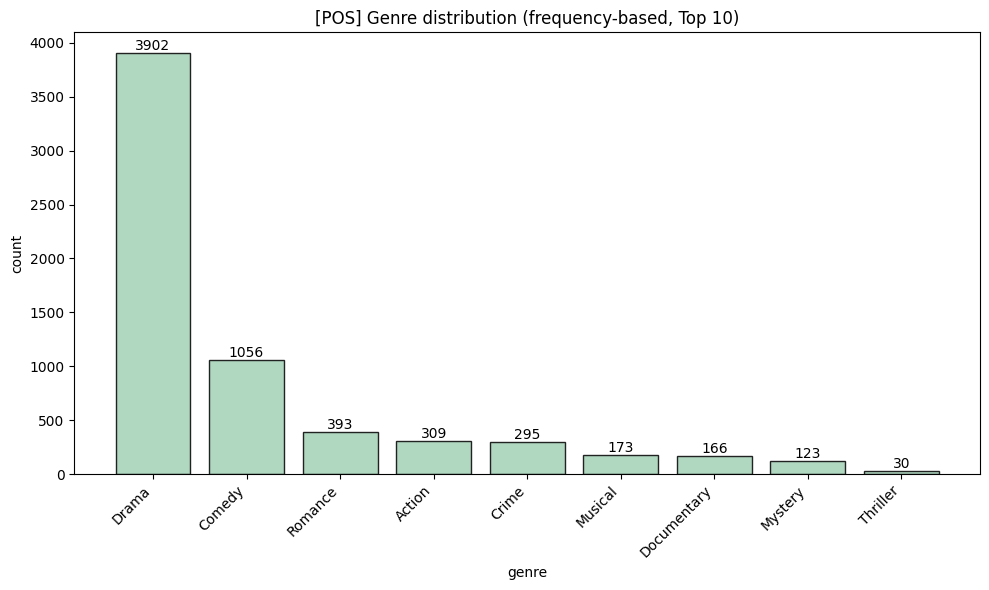

saved figure to: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/results/pos_unique_item_genre_bar_part5_step0.png


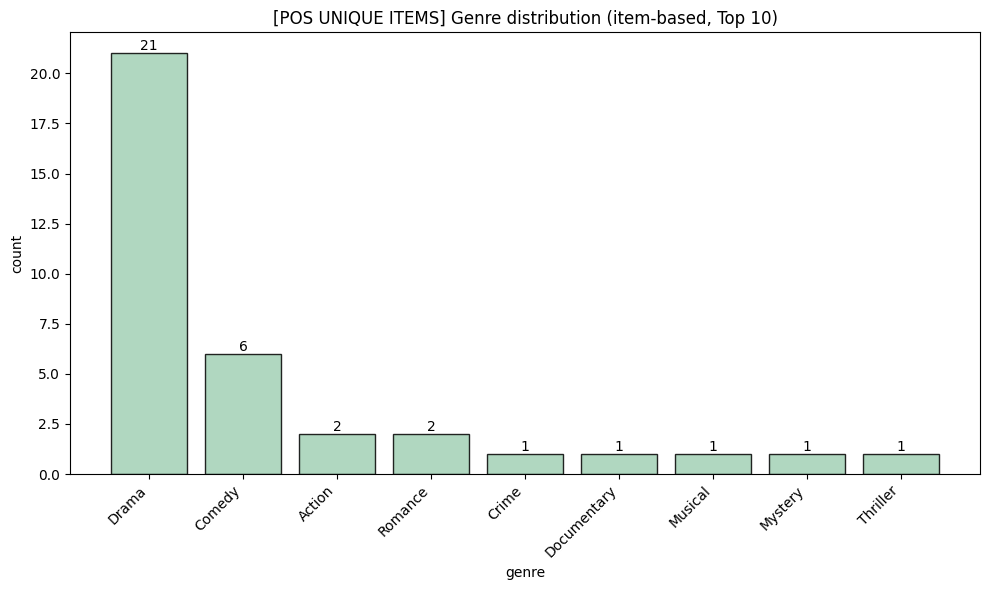

In [14]:
import os, re, pickle
from collections import Counter
from pathlib import Path
import pandas as pd

ITEM_ATTR_PATH = "/home/parkdw00/Codes/data/ml-1m/item_attribute.csv"
PKL_PATH = "/home/parkdw00/Codes/data/ml-1m/Augmentation_format/aug_triplets_part5_step0_try0.pkl"
BAR_COLOR = "#A2D0B5"

def load_pickle(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)


def load_ml1m_item_attribute(item_attribute_csv: str) -> pd.DataFrame:
    """
    item_attribute.csv 예시:
    0,1995,Toy Story (1995),"Animation, Children's, Comedy"

    반환 df 컬럼:
    - item_id (int)
    - year (int/nullable)
    - title (str)
    - genres_raw (str)
    """
    # 따옴표/콤마 처리 때문에 engine="python"이 안전
    df = pd.read_csv(
        item_attribute_csv,
        header=None,
        names=["item_id", "year", "title", "genres_raw"],
        engine="python",
    )
    df["item_id"] = df["item_id"].astype(int)
    return df


def build_genre_long_table(item_attr_df: pd.DataFrame) -> pd.DataFrame:
    """
    (item_id, genre) long-form 생성
    - genres_raw: "Animation, Children's, Comedy" 같은 문자열을 ','로 split
    """
    rows = []
    for _, r in item_attr_df.iterrows():
        item_id = int(r["item_id"])
        raw = r["genres_raw"]
        if pd.isna(raw):
            continue

        # "Animation, Children's, Comedy" -> ["Animation", "Children's", "Comedy"]
        genres = [g.strip() for g in str(raw).split(",") if g and str(g).strip()]
        for g in genres:
            rows.append((item_id, g))

    gdf = pd.DataFrame(rows, columns=["item_id", "genre"])
    return gdf


def analyze_pos_genre_distribution(
    triplets_pkl_path: str,
    genre_long_df: pd.DataFrame,
    topk: int = 30,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    반환:
    - counts: pos 선택 빈도 기반 장르 분포 (count, prob)
    - genre_item_count_df: 유니크 pos 아이템 기준 장르 분포 (item_count)
    """
    triplets = load_pickle(triplets_pkl_path)

    pos_items = []
    for t in triplets:
        if not isinstance(t, (list, tuple)) or len(t) < 3:
            continue
        _, pos, _ = t[0], t[1], t[2]
        try:
            pos_items.append(int(pos))
        except:
            continue

    if len(pos_items) == 0:
        empty1 = pd.DataFrame(columns=["genre", "count", "prob"])
        empty2 = pd.DataFrame(columns=["genre", "item_count"])
        return empty1, empty2

    # === pos_items 내 유니크 아이템별 선택 횟수 ===
    pos_item_counter = Counter(pos_items)
    pos_item_count_df = (
        pd.DataFrame(pos_item_counter.items(), columns=["item_id", "pos_count"])
        .sort_values("pos_count", ascending=False)
        .reset_index(drop=True)
    )

    print(f"[POS ITEM COUNTS] unique items: {len(pos_item_count_df)}")
    print(pos_item_count_df.head(20))
    print("count stats:", pos_item_count_df["pos_count"].describe())

    # === 유니크 아이템 기준 장르 카운트 ===
    unique_pos_items = pos_item_count_df["item_id"].unique()

    unique_item_genres = (
        pd.DataFrame({"item_id": unique_pos_items})
        .merge(genre_long_df, on="item_id", how="left")
        .dropna(subset=["genre"])
        .drop_duplicates(subset=["item_id", "genre"])
    )

    genre_item_count_df = (
        unique_item_genres.groupby("genre")
        .size()
        .sort_values(ascending=False)
        .rename("item_count")
        .reset_index()
    )

    print("[UNIQUE POS ITEMS] genre count (item-based)")
    print(genre_item_count_df.head(20))

    # === 기존: 빈도 기반 장르 분포 ===
    pos_df = pd.DataFrame({"item_id": pos_items})
    merged = pos_df.merge(genre_long_df, on="item_id", how="left").dropna(subset=["genre"])

    counts = (
        merged.groupby("genre")
        .size()
        .sort_values(ascending=False)
        .rename("count")
        .reset_index()
    )
    total = int(counts["count"].sum()) if len(counts) > 0 else 0
    counts["prob"] = counts["count"] / max(1, total)

    if topk is not None:
        counts = counts.head(topk)

    return counts, genre_item_count_df



# === 실행 ===
item_attr_df = load_ml1m_item_attribute(ITEM_ATTR_PATH)
genre_long_df = build_genre_long_table(item_attr_df)

print("item_attr_df:", item_attr_df.shape)
print("genre_long_df:", genre_long_df.shape)
print(genre_long_df.head(5))

pos_genre_df, unique_pos_genre_df = analyze_pos_genre_distribution(PKL_PATH, genre_long_df, topk=30)
out_path = "/home/parkdw00/Codes/data/ml-1m/Augmentation_format/results"

# CSV 저장 (유니크 아이템 기준도)
unique_pos_genre_df.to_csv(f"{out_path}/unique_pos_item_genre_dist_part1_step0.csv", index=False)
print("saved unique item genre dist:", f"{out_path}/unique_pos_item_genre_dist_part1_step0.csv")

print("\n[aug_triplets_part1_step0.pkl] positive(pos) genre distribution (top 30)")
print(pos_genre_df)

pos_genre_df.to_csv(f"{out_path}/pos_genre_dist_part1_step0.csv", index=False)
print("saved:", out_path)
from pathlib import Path

def plot_genre_bar_vertical(
    df: pd.DataFrame,
    title: str,
    topk: int = 10,
    save_path: str | None = None,
):
    """
    세로 bar plot
    - 각 bar 위에 count 값 표시
    - topk까지만 사용
    - save_path 지정 시 파일로 저장
    """
    if df is None or df.empty:
        print("No data to plot.")
        return

    d = df.sort_values("count", ascending=False).head(topk).copy()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(d["genre"], d["count"], color=BAR_COLOR, edgecolor="black", alpha=0.85)
    plt.title(title)
    plt.xlabel("genre")
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")

    # bar 위에 숫자 표시
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h,
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"saved figure to: {save_path}")

    plt.show()


# 기존 빈도 기반 그래프
plot_genre_bar_vertical(
    pos_genre_df,
    title="[POS] Genre distribution (frequency-based, Top 10)",
    topk=10,
    save_path=f"{out_path}/pos_genre_bar_part1_step0.png",
)

# 유니크 아이템 기준 그래프 (파일명 다르게 저장)
unique_plot_df = unique_pos_genre_df.rename(columns={"item_count": "count"})
plot_genre_bar_vertical(
    unique_plot_df,
    title="[POS UNIQUE ITEMS] Genre distribution (item-based, Top 10)",
    topk=10,
    save_path=f"{out_path}/pos_unique_item_genre_bar_part5_step0.png",
)



### RQ3

In [12]:
import os
import pickle
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt


# =========================
# Paths (ML-1M)
# =========================
ITEM_ATTR_PATH = "/home/parkdw00/Codes/data/ml-1m/item_attribute.csv"

# step0~4 pkl 경로 패턴
PKL_DIR = "/home/parkdw00/Codes/data/ml-1m/Augmentation_format"
PKL_TEMPLATE = "aug_triplets_part5_step{step}_try0.pkl"   # step=0..4

OUT_DIR = "/home/parkdw00/Codes/data/ml-1m/Augmentation_format/results/step_comparison_groupplot"
os.makedirs(OUT_DIR, exist_ok=True)


# =========================
# Color: seagreen!white60 (matplotlib hex)
#   60% white + 40% seagreen(#2E8B57) -> #A2D0B5
# =========================
BAR_COLOR = "#A2D0B5"


def load_pickle(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)


def load_ml1m_item_attribute(item_attribute_csv: str) -> pd.DataFrame:
    df = pd.read_csv(
        item_attribute_csv,
        header=None,
        names=["item_id", "year", "title", "genres_raw"],
        engine="python",
    )
    df["item_id"] = df["item_id"].astype(int)
    return df


def build_genre_long_table(item_attr_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in item_attr_df.iterrows():
        item_id = int(r["item_id"])
        raw = r["genres_raw"]
        if pd.isna(raw):
            continue
        genres = [g.strip() for g in str(raw).split(",") if g and str(g).strip()]
        for g in genres:
            rows.append((item_id, g))
    return pd.DataFrame(rows, columns=["item_id", "genre"])


def analyze_pos_genre_distribution(
    triplets_pkl_path: str,
    genre_long_df: pd.DataFrame,
    topk: int | None = 30,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    triplets = load_pickle(triplets_pkl_path)

    pos_items: List[int] = []
    for t in triplets:
        if not isinstance(t, (list, tuple)) or len(t) < 3:
            continue
        pos = t[1]
        try:
            pos_items.append(int(pos))
        except Exception:
            continue

    if len(pos_items) == 0:
        empty1 = pd.DataFrame(columns=["genre", "count", "prob"])
        empty2 = pd.DataFrame(columns=["genre", "item_count"])
        return empty1, empty2

    # unique item -> pos 선택 횟수
    pos_item_counter = Counter(pos_items)
    pos_item_count_df = (
        pd.DataFrame(pos_item_counter.items(), columns=["item_id", "pos_count"])
        .sort_values("pos_count", ascending=False)
        .reset_index(drop=True)
    )

    # 유니크 pos 아이템 기준 장르 카운트
    unique_pos_items = pos_item_count_df["item_id"].unique()
    unique_item_genres = (
        pd.DataFrame({"item_id": unique_pos_items})
        .merge(genre_long_df, on="item_id", how="left")
        .dropna(subset=["genre"])
        .drop_duplicates(subset=["item_id", "genre"])
    )

    genre_item_count_df = (
        unique_item_genres.groupby("genre")
        .size()
        .sort_values(ascending=False)
        .rename("item_count")
        .reset_index()
    )

    # 빈도 기반 장르 분포
    pos_df = pd.DataFrame({"item_id": pos_items})
    merged = pos_df.merge(genre_long_df, on="item_id", how="left").dropna(subset=["genre"])

    counts = (
        merged.groupby("genre")
        .size()
        .sort_values(ascending=False)
        .rename("count")
        .reset_index()
    )

    total = int(counts["count"].sum()) if len(counts) > 0 else 0
    counts["prob"] = counts["count"] / max(1, total)

    if topk is not None:
        counts = counts.head(topk)

    return counts, genre_item_count_df


def load_steps_pos_genre(
    pkl_dir: str,
    pkl_template: str,
    steps: List[int],
    genre_long_df: pd.DataFrame,
    topk: int | None = 30,
) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
    freq_by_step: Dict[str, pd.DataFrame] = {}
    uniq_by_step: Dict[str, pd.DataFrame] = {}

    for s in steps:
        step_name = f"Step {s}"
        pkl_path = os.path.join(pkl_dir, pkl_template.format(step=s))

        if not os.path.exists(pkl_path):
            print(f"❌ missing: {pkl_path}")
            freq_by_step[step_name] = pd.DataFrame(columns=["genre", "count", "prob"])
            uniq_by_step[step_name] = pd.DataFrame(columns=["genre", "item_count"])
            continue

        print(f"📂 loading: {pkl_path}")
        freq_df, uniq_df = analyze_pos_genre_distribution(pkl_path, genre_long_df, topk=topk)
        freq_by_step[step_name] = freq_df
        uniq_by_step[step_name] = uniq_df

    return freq_by_step, uniq_by_step


# =========================
# Groupplot (2x3 grid, Step0~4)
# =========================
def plot_group_grid_genre(
    dfs_by_step: Dict[str, pd.DataFrame],
    kind: str,         # "pos_freq" or "pos_unique"
    topk: int,
    out_path: str,
    color: str = BAR_COLOR,
):
    steps = sorted(dfs_by_step.keys(), key=lambda x: int(x.split()[-1]))

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, step_name in enumerate(steps):
        if i >= 5:
            break

        ax = axes[i]
        df = dfs_by_step[step_name]

        if df is None or df.empty:
            ax.text(0.5, 0.5, "No Data", ha="center", va="center")
            ax.set_title(step_name, fontsize=12, fontweight="bold")
            ax.axis("off")
            continue

        d = df.copy()

        # unique-item 기반이면 item_count -> count로 통일
        if "count" not in d.columns and "item_count" in d.columns:
            d = d.rename(columns={"item_count": "count"})

        if "count" not in d.columns or "genre" not in d.columns:
            ax.text(0.5, 0.5, "Missing columns", ha="center", va="center")
            ax.set_title(step_name, fontsize=12, fontweight="bold")
            ax.axis("off")
            continue

        d = d.sort_values("count", ascending=False).head(topk).copy()

        bars = ax.bar(d["genre"], d["count"], color=color, edgecolor="black", alpha=0.85)

        for bar in bars:
            h = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                h + (h * 0.01),
                f"{int(h)}",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )

        ax.set_title(f"{step_name} (Top {topk})", fontsize=12, fontweight="bold")
        ax.tick_params(axis="x", rotation=45, labelsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.set_xlabel("")
        ax.set_ylabel("count")

    axes[5].axis("off")

    title_map = {
        "pos_freq": "[POS] Genre distribution (frequency-based)",
        "pos_unique": "[POS UNIQUE ITEMS] Genre distribution (item-based)",
    }
    main_title = title_map.get(kind, kind)
    fig.suptitle(f"{main_title} | Step 0-4", fontsize=18, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"✅ saved groupplot: {out_path}")


# =========================
# Run
# =========================
item_attr_df = load_ml1m_item_attribute(ITEM_ATTR_PATH)
genre_long_df = build_genre_long_table(item_attr_df)

print("item_attr_df:", item_attr_df.shape)
print("genre_long_df:", genre_long_df.shape)

STEPS = [0, 1, 2, 3, 4]

pos_freq_by_step, pos_uniq_by_step = load_steps_pos_genre(
    pkl_dir=PKL_DIR,
    pkl_template=PKL_TEMPLATE,
    steps=STEPS,
    genre_long_df=genre_long_df,
    topk=30,
)

# groupplot 저장 (각 1장씩)
plot_group_grid_genre(
    dfs_by_step=pos_freq_by_step,
    kind="pos_freq",
    topk=10,
    out_path=f"{OUT_DIR}/groupplot_pos_genre_freq.png",
    color=BAR_COLOR,
)

plot_group_grid_genre(
    dfs_by_step=pos_uniq_by_step,
    kind="pos_unique",
    topk=10,
    out_path=f"{OUT_DIR}/groupplot_pos_genre_unique.png",
    color=BAR_COLOR,
)

print("🎉 Done.")


item_attr_df: (3693, 4)
genre_long_df: (6178, 2)
📂 loading: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/aug_triplets_part5_step0_try0.pkl
📂 loading: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/aug_triplets_part5_step1_try0.pkl
📂 loading: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/aug_triplets_part5_step2_try0.pkl
📂 loading: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/aug_triplets_part5_step3_try0.pkl
📂 loading: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/aug_triplets_part5_step4_try0.pkl
✅ saved groupplot: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/results/step_comparison_groupplot/groupplot_pos_genre_freq.png
✅ saved groupplot: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/results/step_comparison_groupplot/groupplot_pos_genre_unique.png
🎉 Done.


### Hallucination

In [5]:
import pickle
from collections import Counter, defaultdict

AB_PATH = "/home/parkdw00/Codes/data/ml-1m/Augmentation_format/aug_triplets_part5_step0_try1.pkl"
BA_PATH = "/home/parkdw00/Codes/data/ml-1m/Augmentation_format/aug_triplets_part5_step0_try2.pkl"

def load_triplets(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)  # List[Tuple[int,int,int]]

def build_pos_counter(triplets):
    """
    key = (u, a, b) where a<b are the unordered pair
    value = Counter({pos_item: count})
    """
    d = defaultdict(Counter)
    for u, pos, neg in triplets:
        a, b = sorted((int(pos), int(neg)))
        key = (int(u), a, b)
        d[key][int(pos)] += 1
    return d

ab = load_triplets(AB_PATH)
ba = load_triplets(BA_PATH)

# sort ab, ba
ab = sorted(ab, key=lambda x: (x[0], x[1], x[2]))
ba = sorted(ba, key=lambda x: (x[0], x[1], x[2]))

print("AB triplets:", len(ab))
print("BA triplets:", len(ba))

ab_map = build_pos_counter(ab)
ba_map = build_pos_counter(ba)

common_keys = set(ab_map.keys()) & set(ba_map.keys())
only_ab = set(ab_map.keys()) - set(ba_map.keys())
only_ba = set(ba_map.keys()) - set(ab_map.keys())

if only_ab or only_ba:
    print(f"WARNING: key mismatch. only_ab={len(only_ab)}, only_ba={len(only_ba)}")

mismatch_total = 0
match_total = 0
total_compared = 0

# optional: mismatch examples
examples = []

for key in common_keys:
    # key=(u,a,b)
    u, a, b = key

    ab_counts = ab_map[key]  # Counter(pos)
    ba_counts = ba_map[key]

    total_ab = sum(ab_counts.values())
    total_ba = sum(ba_counts.values())
    if total_ab != total_ba:
        # 같은 key에 대해 AB/BA 샘플 수가 다르면 비교가 애매함
        # 그래도 가능한 범위(min)까지만 비교하거나, 그냥 스킵할 수도 있음.
        # 여기선 "가능한 매칭" 기준으로 계산.
        pass

    # 같은 pos로 매칭 가능한 개수
    match_a = min(ab_counts.get(a, 0), ba_counts.get(a, 0))
    match_b = min(ab_counts.get(b, 0), ba_counts.get(b, 0))
    matches = match_a + match_b

    # 비교 가능한 총 개수(멀티셋이므로 양쪽 중 작은 쪽 기준)
    total = min(total_ab, total_ba)

    mismatches = total - matches

    match_total += matches
    mismatch_total += mismatches
    total_compared += total

    if mismatches > 0 and len(examples) < 20:
        examples.append({
            "user": u, "pair": (a, b),
            "AB": dict(ab_counts), "BA": dict(ba_counts),
            "mismatches": mismatches, "total": total
        })

print("\n===== RESULT =====")
print("Compared pairs(keys):", len(common_keys))
print("Total comparable samples:", total_compared)
print("Match count:", match_total)
print("Mismatch count (pos differs AB vs BA):", mismatch_total)
if total_compared > 0:
    print("Mismatch rate:", mismatch_total / total_compared)

print("\n===== mismatch examples (up to 20) =====")
for ex in examples:
    print(ex)


AB triplets: 5400
BA triplets: 5400

===== RESULT =====
Compared pairs(keys): 5400
Total comparable samples: 5400
Match count: 5217
Mismatch count (pos differs AB vs BA): 183
Mismatch rate: 0.03388888888888889

===== mismatch examples (up to 20) =====
{'user': 1257, 'pair': (668, 2487), 'AB': {668: 1}, 'BA': {2487: 1}, 'mismatches': 1, 'total': 1}
{'user': 2857, 'pair': (3010, 3096), 'AB': {3096: 1}, 'BA': {3010: 1}, 'mismatches': 1, 'total': 1}
{'user': 229, 'pair': (762, 1253), 'AB': {762: 1}, 'BA': {1253: 1}, 'mismatches': 1, 'total': 1}
{'user': 5113, 'pair': (668, 3082), 'AB': {668: 1}, 'BA': {3082: 1}, 'mismatches': 1, 'total': 1}
{'user': 2348, 'pair': (762, 818), 'AB': {762: 1}, 'BA': {818: 1}, 'mismatches': 1, 'total': 1}
{'user': 3912, 'pair': (1633, 2383), 'AB': {2383: 1}, 'BA': {1633: 1}, 'mismatches': 1, 'total': 1}
{'user': 407, 'pair': (818, 1739), 'AB': {1739: 1}, 'BA': {818: 1}, 'mismatches': 1, 'total': 1}
{'user': 5396, 'pair': (721, 2096), 'AB': {721: 1}, 'BA': {209

# RQ2 & RQ3
LLM이 생성한 데이터로 추천을 반복한 (피드백루프 이후)결과 분석(Part1: RQ2, Part5: RQ3)

포함: LLMRec, A-LLMRec, Augmentation, TR_CF

## LLMRec

### Bias
성별에 따른 추천 결과 비교

✅ profile parse success users: 5400
✅ users per gender: {'Male': 4643, 'Female': 757}
✅ users in pred_dict: 1143
✅ predicted items per gender: {'Male': 89512, 'Female': 15028}
✅ total interactions (user-item pairs): 104540
✅ loaded item genres: 3693
✅ saved: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/gender_recommendation_genre/Male_predicted_genre_bar_top15.png


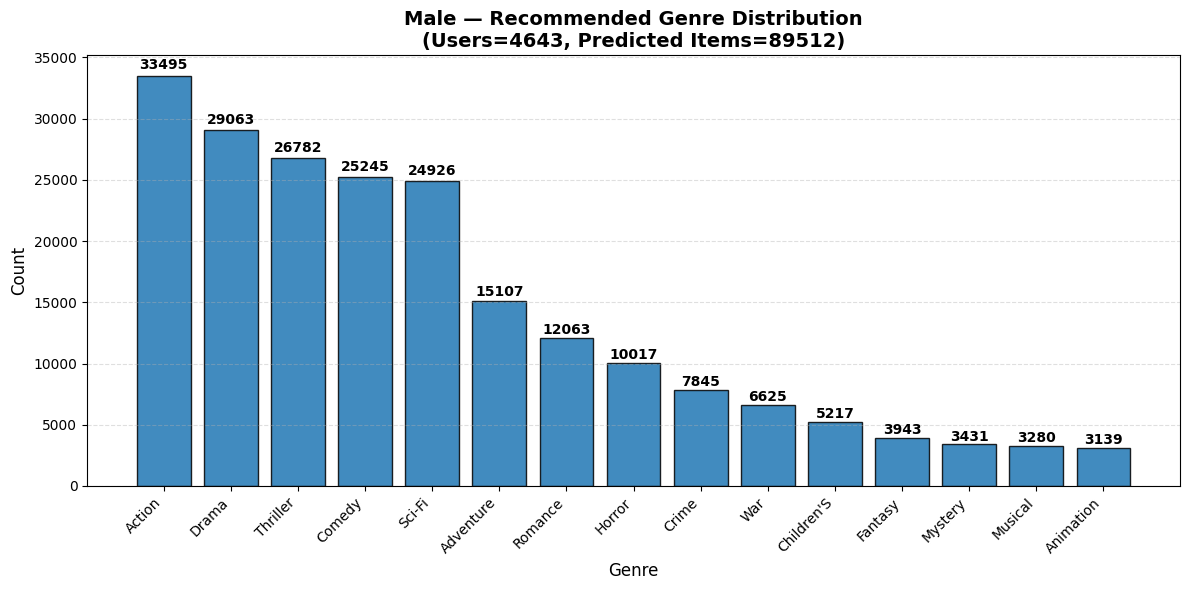

✅ saved: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/gender_recommendation_genre/Female_predicted_genre_bar_top15.png


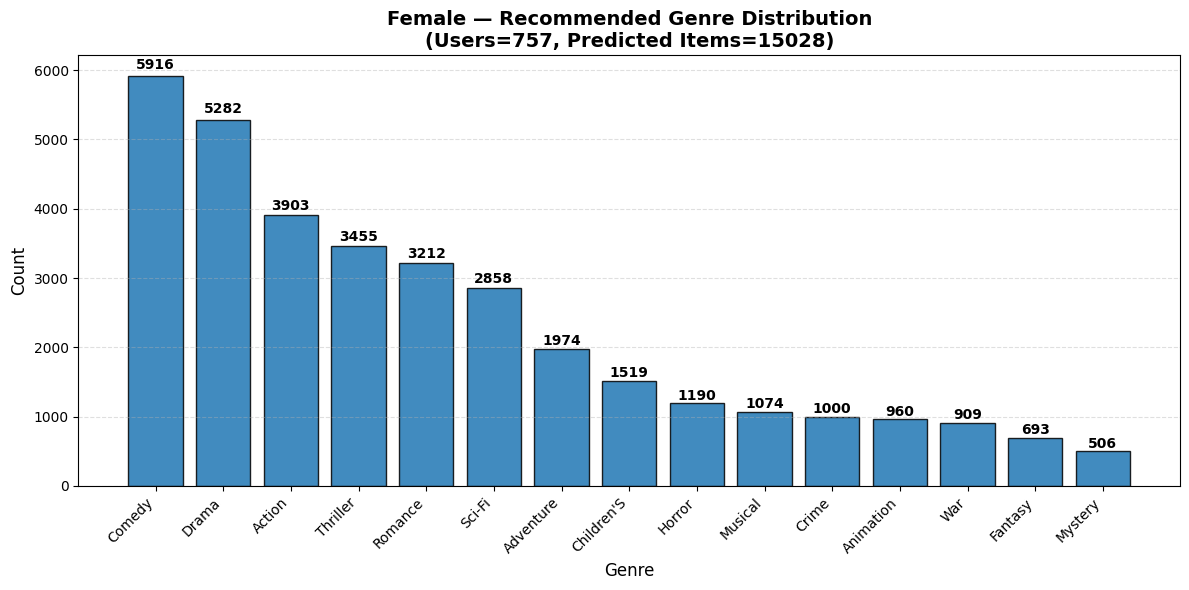

🎉 Done. Plots saved at: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/poster/gender_recommendation_genre

===== ALL USERS — Recommended Items (Top 30) =====
01. Item 2363    |  count = 1799
02. Item 573     |  count = 1464
03. Item 2640    |  count = 1175
04. Item 1097    |  count = 1060
05. Item 442     |  count = 1010
06. Item 1139    |  count = 976
07. Item 1115    |  count = 974
08. Item 253     |  count = 925
09. Item 591     |  count = 906
10. Item 465     |  count = 845
11. Item 1098    |  count = 830
12. Item 2697    |  count = 827
13. Item 577     |  count = 789
14. Item 1439    |  count = 749
15. Item 1169    |  count = 727
16. Item 1837    |  count = 717
17. Item 309     |  count = 689
18. Item 1017    |  count = 687
19. Item 2192    |  count = 663
20. Item 1164    |  count = 646
21. Item 1475    |  count = 639
22. Item 367     |  count = 622
23. Item 1099    |  count = 618
24. Item 1111    |  count = 616
25. Item 287     |  count = 609
26. Item 1279    |  count = 603


In [7]:
import os, json, pickle, re, ast
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =========================================================
# 0) Paths
# =========================================================
BASE_DIR = "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format"
PRED_PATH = os.path.join(BASE_DIR, "predict_label_part5.json")
PROFILE_PATH = os.path.join(BASE_DIR, "augmented_user_profiling_dict_part1_step0")
ITEM_ATTR_PATH = "/home/parkdw00/Codes/data/ml-1m/item_attribute.csv"

SAVE_PLOT_DIR = os.path.join(BASE_DIR, "poster/gender_recommendation_genre")
os.makedirs(SAVE_PLOT_DIR, exist_ok=True)

TOPK_GENRE = 15  # bar plot top-k

# =========================================================
# 1) Profile parsing helpers
# =========================================================
def clean_and_parse(profile_text):
    cleaned = str(profile_text).strip()
    cleaned = cleaned.replace("'''", "").replace("```json", "").replace("```", "")
    cleaned = cleaned.replace("\n", " ").replace("\r", " ")
    cleaned = re.sub(r"(\w+)['’]s", r"\1s", cleaned)  # Children's -> Childrens
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    # json.loads
    try:
        obj = json.loads(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    # ast.literal_eval
    try:
        obj = ast.literal_eval(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    # 마지막 강제 변환
    try:
        cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
        obj = json.loads(cleaned_forced)
        return obj if isinstance(obj, dict) else None
    except Exception:
        return None

def normalize_keys(profile: dict) -> dict:
    new_profile = {}
    for k, v in profile.items():
        nk = str(k).lower().strip().replace(" ", "_")
        if nk == "liked_director": nk = "liked_directors"
        if nk == "liked_actor": nk = "liked_actors"
        if nk == "disliked_director": nk = "disliked_directors"
        new_profile[nk] = v
    return new_profile

def is_empty_like(x):
    if x is None:
        return True
    if isinstance(x, str):
        s = x.strip().lower()
        return s in ["unknown", "none", "n/a", "na", "null", ""]
    if isinstance(x, (list, tuple, set, dict)):
        return len(x) == 0
    return False

def normalize_gender(val):
    if is_empty_like(val):
        return "Unknown"
    s = str(val).strip().lower()
    if s.startswith("f") or "female" in s:
        return "Female"
    if s.startswith("m") or "male" in s:
        return "Male"
    return "Unknown"

# =========================================================
# 2) Load user -> gender from profiling dict
# =========================================================
with open(PROFILE_PATH, "rb") as f:
    profile_dict = pickle.load(f)

user_gender: dict[int, str] = {}
parse_ok = 0
for uid, text in profile_dict.items():
    raw = clean_and_parse(text)
    if not raw:
        continue
    prof = normalize_keys(raw)
    g = normalize_gender(prof.get("gender"))
    try:
        user_gender[int(uid)] = g
        parse_ok += 1
    except Exception:
        continue

gender_user_count = Counter(user_gender.values())

print(f"✅ profile parse success users: {parse_ok}")
print("✅ users per gender:", dict(gender_user_count))

# =========================================================
# 3) Load predictions: user -> items
# =========================================================
with open(PRED_PATH, "r") as f:
    pred_raw = json.load(f)

pred_dict: dict[int, list[int]] = {}
for u, items in pred_raw.items():
    try:
        ui = int(u)
    except Exception:
        continue
    if isinstance(items, list):
        pred_dict[ui] = [int(x) for x in items]
    else:
        try:
            pred_dict[ui] = [int(items)]
        except Exception:
            pred_dict[ui] = []

print("✅ users in pred_dict:", len(pred_dict))

# =========================================================
# 4) Group predicted items by gender
# =========================================================
gender_pred_items = defaultdict(list)  # gender -> list of predicted items (with repetition)
interaction_count = 0
for u, items in pred_dict.items():
    interaction_count += len(items)
    g = user_gender.get(u, "Unknown")
    gender_pred_items[g].extend(items)

gender_pred_item_count = {g: len(items) for g, items in gender_pred_items.items()}
print("✅ predicted items per gender:", dict(gender_pred_item_count))
print(f"✅ total interactions (user-item pairs): {interaction_count}")

# =========================================================
# 5) Load item -> genres from ML-1M item_attribute.csv
# =========================================================
item_df = pd.read_csv(
    ITEM_ATTR_PATH,
    header=None,
    names=["item_id", "year", "title", "genres_raw"],
    engine="python",
)
item_df["item_id"] = item_df["item_id"].astype(int)

item2genres: dict[int, list[str]] = {}
for _, r in item_df.iterrows():
    raw = r["genres_raw"]
    if pd.isna(raw):
        continue
    genres = [g.strip().title() for g in str(raw).split(",") if g.strip()]
    item2genres[int(r["item_id"])] = genres

print("✅ loaded item genres:", len(item2genres))

# =========================================================
# 6) Gender-wise genre analysis
#    (A) frequency-based: count by recommended frequency
# =========================================================
gender_genre_count = {}
for gender, items in gender_pred_items.items():
    c = Counter()
    for it in items:
        genres = item2genres.get(int(it), [])
        for gg in genres:
            c[gg] += 1
    gender_genre_count[gender] = c

# =========================================================
# 7) Plot helper (vertical bar) + save
# =========================================================
def plot_gender_genre_bar(
    gender: str,
    genre_counter: Counter,
    user_count: int,
    pred_item_count: int,
    top_k: int = 15,
    save_dir: str | None = None,
):
    if not genre_counter:
        print(f"⚠️ no genre data: {gender}")
        return

    items = genre_counter.most_common(top_k)
    labels = [k for k, _ in items]
    values = [v for _, v in items]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, values, edgecolor="black", alpha=0.85)

    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h + (h * 0.01 if h > 0 else 0.5),
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    title = (
        f"{gender} — Recommended Genre Distribution\n"
        f"(Users={user_count}, Predicted Items={pred_item_count})"
    )
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Genre", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()

    if save_dir is not None:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        save_path = os.path.join(save_dir, f"{gender}_predicted_genre_bar_top{top_k}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ saved: {save_path}")

    plt.show()

# =========================================================
# 8) Make plots (Male / Female)
# =========================================================
for gender in ["Male", "Female"]:
    plot_gender_genre_bar(
        gender=gender,
        genre_counter=gender_genre_count.get(gender, Counter()),
        user_count=gender_user_count.get(gender, 0),
        pred_item_count=gender_pred_item_count.get(gender, 0),
        top_k=TOPK_GENRE,
        save_dir=SAVE_PLOT_DIR,
    )

print("🎉 Done. Plots saved at:", SAVE_PLOT_DIR)

# =========================================================
# 9) Count recommended items by group (All / Male / Female)
# =========================================================

def print_top_recommended_items(
    item_counter: Counter,
    title: str,
    top_k: int = 20,
):
    print(f"\n===== {title} (Top {top_k}) =====")
    for rank, (item_id, cnt) in enumerate(item_counter.most_common(top_k), 1):
        print(f"{rank:02d}. Item {item_id:<6d}  |  count = {cnt}")


# -------------------------
# (A) 전체(All users)
# -------------------------
all_items = []
for items in pred_dict.values():
    all_items.extend(items)

all_item_counter = Counter(all_items)

print_top_recommended_items(
    all_item_counter,
    title="ALL USERS — Recommended Items",
    top_k=30,
)

print(f"\n[ALL] total predicted items: {len(all_items)}")
print(f"[ALL] unique predicted items: {len(all_item_counter)}")


# -------------------------
# (B) Male users
# -------------------------
male_items = gender_pred_items.get("Male", [])
male_item_counter = Counter(male_items)

print_top_recommended_items(
    male_item_counter,
    title="MALE USERS — Recommended Items",
    top_k=30,
)

print(f"\n[Male] total predicted items: {len(male_items)}")
print(f"[Male] unique predicted items: {len(male_item_counter)}")


# -------------------------
# (C) Female users
# -------------------------
female_items = gender_pred_items.get("Female", [])
female_item_counter = Counter(female_items)

print_top_recommended_items(
    female_item_counter,
    title="FEMALE USERS — Recommended Items",
    top_k=30,
)

print(f"\n[Female] total predicted items: {len(female_items)}")
print(f"[Female] unique predicted items: {len(female_item_counter)}")

# =========================================================
# 10) Items recommended only to one gender (set difference)
# =========================================================

def print_items_with_counts(item_ids, counter: Counter, title: str, top_k: int = 30):
    print(f"\n===== {title} (Top {top_k}) =====")
    rows = [(it, counter.get(it, 0)) for it in item_ids]
    rows.sort(key=lambda x: x[1], reverse=True)
    for i, (it, cnt) in enumerate(rows[:top_k], 1):
        print(f"{i:02d}. Item {it:<6d} | count = {cnt}")
    print(f"Total items: {len(rows)}")


male_counter = male_item_counter
female_counter = female_item_counter

male_set = set(male_counter.keys())
female_set = set(female_counter.keys())

# Male only / Female only
male_only_items = male_set - female_set
female_only_items = female_set - male_set

print(f"\n[Male only] unique items: {len(male_only_items)}")
print(f"[Female only] unique items: {len(female_only_items)}")

print_items_with_counts(male_only_items, male_counter, "MALE ONLY recommended items", top_k=30)
print_items_with_counts(female_only_items, female_counter, "FEMALE ONLY recommended items", top_k=30)

# -------------------------
# (옵션) 최소 추천 횟수 threshold 걸기
# -------------------------
MIN_COUNT = 5  # 필요하면 조절

male_only_strong = [it for it in male_only_items if male_counter[it] >= MIN_COUNT]
female_only_strong = [it for it in female_only_items if female_counter[it] >= MIN_COUNT]

print(f"\n[Male only | count >= {MIN_COUNT}] items: {len(male_only_strong)}")
print(f"[Female only | count >= {MIN_COUNT}] items: {len(female_only_strong)}")

print_items_with_counts(male_only_strong, male_counter, f"MALE ONLY (count >= {MIN_COUNT})", top_k=30)
print_items_with_counts(female_only_strong, female_counter, f"FEMALE ONLY (count >= {MIN_COUNT})", top_k=30)

# =========================================================
# 11) Genre distribution for MALE/FEMALE-only recommended items
# =========================================================

def genre_counter_for_itemset(
    item_ids,
    item_counter: Counter,          # 해당 성별의 item 추천 횟수 카운터
    item2genres: dict[int, list[str]],
    weighted: bool = True,          # True면 추천된 횟수만큼 가중치, False면 아이템 1개당 1표
):
    gc = Counter()
    for it in item_ids:
        genres = item2genres.get(int(it), [])
        if not genres:
            continue
        w = int(item_counter.get(it, 1)) if weighted else 1
        for g in genres:
            gc[g] += w
    return gc

def print_genre_summary(gc: Counter, title: str, top_k: int = 20):
    total = sum(gc.values())
    print(f"\n===== {title} =====")
    print(f"Total genre counts: {total}, Unique genres: {len(gc)}")
    for i, (g, c) in enumerate(gc.most_common(top_k), 1):
        pct = (c / total * 100) if total > 0 else 0.0
        print(f"{i:02d}. {g:<15s} | count={c:<6d} | {pct:5.1f}%")

# (A) MALE ONLY: 추천 "횟수"로 가중치 주는 버전
male_only_genre_weighted = genre_counter_for_itemset(
    male_only_items, male_item_counter, item2genres, weighted=True
)
print_genre_summary(male_only_genre_weighted, "MALE ONLY — Genre Sum (weighted by recommendation count)", top_k=20)

# (B) FEMALE ONLY: 추천 "횟수"로 가중치 주는 버전
female_only_genre_weighted = genre_counter_for_itemset(
    female_only_items, female_item_counter, item2genres, weighted=True
)
print_genre_summary(female_only_genre_weighted, "FEMALE ONLY — Genre Sum (weighted by recommendation count)", top_k=20)

# (옵션) 아이템 단위로만 합산(중복 추천 무시)도 보고 싶으면:
male_only_genre_unweighted = genre_counter_for_itemset(
    male_only_items, male_item_counter, item2genres, weighted=False
)
female_only_genre_unweighted = genre_counter_for_itemset(
    female_only_items, female_item_counter, item2genres, weighted=False
)
print_genre_summary(male_only_genre_unweighted, "MALE ONLY — Genre Sum (unweighted, per-item once)", top_k=20)
print_genre_summary(female_only_genre_unweighted, "FEMALE ONLY — Genre Sum (unweighted, per-item once)", top_k=20)


## Hallucination

In [9]:
import json
from collections import defaultdict

# 2) 각 시나리오별 pred_count 및 user 집합 수집
scenarios = [
    ('case2','part1'),
    ('case2','part5'),
]
pred_counts = {}
pred_user_sets = {}
for case, part in scenarios:
    path = f"{BASE_DIR}/predict_label_{part}.json"
    with open(path) as f:
        raw = json.load(f)
    # 문자열 키 → 정수, 예측 수
    cnt_dict = {int(u): len(titles) for u, titles in raw.items()}
    key = f"{case}_{part}"
    pred_counts[key] = cnt_dict
    pred_user_sets[key] = set(cnt_dict.keys())

# 3) 공통 유저 집합: train ∩ label (요청하신 방식), int형으로 변환 
common_users = sorted(set(train_data) & set(ground_truth))

# 4) 실제(interactions) 총합 계산 (common users만)
actual_total = sum(len(ground_truth[u]) for u in common_users)
print(f"Actual total interactions (common users): {actual_total}, {len(common_users)}명\n")

# 5) 시나리오별 계산 및 출력 + case별 missing user 카운트
case_missing_users = {'case1': set(), 'case2': set()}
common_users = [int(u) for u in common_users]  # 정수형으로 변환

for case, part in scenarios:
    key = f"{case}_{part}"
    pred_users = pred_user_sets[key]
    missing_users = set(common_users) - pred_users  # 예측에 없는 common user
    case_missing_users[case].update(missing_users)  # case별 누적

    pred_total = sum(pred_counts[key].get(u, 0) for u in common_users)
    missing    = actual_total - pred_total
    missing_pct= missing / actual_total * 100

    print(f"{key}:")
    print(f"  Predicted total (common users) = {pred_total}")
    print(f"  Missing interactions           = {missing} ({missing_pct:.2f}%)")
    print(f"  Missing users (count)          = {len(missing_users)}\n")


Actual total interactions (common users): 104540, 1143명

case2_part1:
  Predicted total (common users) = 81564
  Missing interactions           = 22976 (21.98%)
  Missing users (count)          = 1

case2_part5:
  Predicted total (common users) = 84104
  Missing interactions           = 20436 (19.55%)
  Missing users (count)          = 3



In [10]:
def load_userlist_counts(path: str) -> dict[int, int]:
    if not os.path.exists(path):
        return {}
    with open(path, "r") as f:
        data = json.load(f)
    out = {}
    if isinstance(data, dict):
        for u, arr in data.items():
            try:
                uid = int(u)
            except:
                continue
            if isinstance(arr, list):
                out[uid] = len(arr)
            elif isinstance(arr, int):
                out[uid] = arr
            else:
                out[uid] = 0
    return out

def summarize_case2_part(part: int, max_step: int) -> pd.DataFrame:
    rows, all_users = [], set()

    # 모든 step에서 user id 유니온 수집
    for step in range(1, max_step+1):
        miss_path = os.path.join(BASE_DIR, f"missing_titles_ml-1m_case2_part{part}_step{step}.json")
        dup_path  = os.path.join(BASE_DIR, f"skipped_duplicates_ml-1m_case2_part{part}_step{step}.json")
        miss = load_userlist_counts(miss_path)
        dup  = load_userlist_counts(dup_path)
        all_users |= set(miss.keys()) | set(dup.keys())

    # step별 카운트(없으면 0)
    for step in range(1, max_step+1):
        miss_path = os.path.join(BASE_DIR, f"missing_titles_ml-1m_case2_part{part}_step{step}.json")
        dup_path  = os.path.join(BASE_DIR, f"skipped_duplicates_ml-1m_case2_part{part}_step{step}.json")
        miss = load_userlist_counts(miss_path)
        dup  = load_userlist_counts(dup_path)
        for u in sorted(all_users):
            rows.append({
                "user_id": u,
                "step": step,
                "missing_title": int(miss.get(u, 0)),
                "skipped_duplicates": int(dup.get(u, 0)),
            })
    return pd.DataFrame(rows).sort_values(["user_id","step"]).reset_index(drop=True)

# 요약 생성
df1  = summarize_case2_part(part=1,  max_step=1)
df5  = summarize_case2_part(part=5,  max_step=5)

# (1) part5: step별 합계 표 출력
step_totals1 = (
    df1.groupby("step")[["missing_title","skipped_duplicates"]]
      .sum()
      .reset_index()
      .astype({"step": int, "missing_title": int, "skipped_duplicates": int})
)
print(step_totals1.to_string(index=False))

step_totals5 = (
    df5.groupby("step")[["missing_title","skipped_duplicates"]]
      .sum()
      .reset_index()
      .astype({"step": int, "missing_title": int, "skipped_duplicates": int})
)
print(step_totals5.to_string(index=False))


# (2) parts overall totals (part5/part10 전체 합계) 출력
overall1  = df1[["missing_title","skipped_duplicates"]].sum().astype(int).to_dict()
overall5  = df5[["missing_title","skipped_duplicates"]].sum().astype(int).to_dict()

parts_overall = pd.DataFrame([
    {"part": 1,  **overall1},
    {"part": 5,  **overall5},
])[["part","missing_title","skipped_duplicates"]]

print("\n[parts overall totals]")
print(parts_overall.to_string(index=False))



 step  missing_title  skipped_duplicates
    1           4261               18715
 step  missing_title  skipped_duplicates
    1           6566               10259
    2            617                1427
    3            448                1156
    4            147                 880
    5            139                 710

[parts overall totals]
 part  missing_title  skipped_duplicates
    1           4261               18715
    5           7917               14432


In [6]:
import os, json
import pandas as pd

PARTS = 5
PREFIX = "predict_label_part5_step"   # 필요하면 predict_label 쪽으로 바꿔
TRY0, TRY1 = 0, 1

def load_json(path):
    with open(path, "r") as f:
        d = json.load(f)
    out = {}
    for k, v in d.items():
        uid = int(k)
        if v is None:
            out[uid] = []
        elif isinstance(v, list):
            out[uid] = [int(x) for x in v]
        else:
            out[uid] = [int(v)]
    return out

def compare_step(d0, d1, step):
    all_users = sorted(set(d0.keys()) | set(d1.keys()))
    rows = []
    changed = 0
    for u in all_users:
        a = d0.get(u, [])
        b = d1.get(u, [])
        if a == b:
            continue
        changed += 1
        sa, sb = set(a), set(b)
        rows.append({
            "step": step,
            "user_id": u,
            "try0": a,
            "try1": b,
            "len_try0": len(a),
            "len_try1": len(b),
            "only_in_try0": sorted(list(sa - sb)),
            "only_in_try1": sorted(list(sb - sa)),
            "set_equal": (sa == sb),
        })
    return changed, pd.DataFrame(rows)

# ---- run ----
summary_rows = []
detail_dfs = []

for step in range(1, PARTS+1):
    p0 = os.path.join(BASE_DIR, f"{PREFIX}{step}_try{TRY0}.json")
    p1 = os.path.join(BASE_DIR, f"{PREFIX}{step}_try{TRY1}.json")

    d0 = load_json(p0)
    d1 = load_json(p1)

    changed, df_detail = compare_step(d0, d1, step)
    union_users = len(set(d0.keys()) | set(d1.keys()))
    exact_equal = union_users - changed

    # set은 같은데 순서만 다른 케이스
    order_only = int(df_detail["set_equal"].sum()) if len(df_detail) else 0

    summary_rows.append({
        "step": step,
        "users_try0": len(d0),
        "users_try1": len(d1),
        "users_union": union_users,
        "users_changed(+1 per user)": changed,
        "users_exact_equal": exact_equal,
        "changed_set_equal_but_order_diff": order_only,
        "file_try0": p0,
        "file_try1": p1,
    })

    detail_dfs.append(df_detail)

df_summary = pd.DataFrame(summary_rows)
df_detail_all = pd.concat(detail_dfs, ignore_index=True) if detail_dfs else pd.DataFrame()

df_summary


,step,users_try0,users_try1,users_union,users_changed(+1 per user),users_exact_equal,changed_set_equal_but_order_diff,file_try0,file_try1
0,1,918,916,919,859,60,0,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...
1,2,536,535,541,524,17,0,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...
2,3,429,427,429,416,13,0,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...
3,4,327,323,328,319,9,0,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...
4,5,281,283,286,279,7,0,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...,/home/parkdw00/Codes/data/ml-1m/A-LLMRec_forma...


In [20]:
import os
import json
from collections import defaultdict

def load_predict_json(path: str) -> dict[int, list[int]]:
    with open(path, "r") as f:
        raw = json.load(f)
    # key가 str일 수 있으니 int로 통일
    out = {}
    for k, v in raw.items():
        try:
            uid = int(k)
        except:
            continue
        if isinstance(v, list):
            out[uid] = [int(x) for x in v]
        else:
            out[uid] = [int(v)]
    return out

def aggregate_across_steps(result_root: str, parts: int, steps: list[int], try_id: int) -> dict[int, list[int]]:
    """
    step별 predict_label을 읽어 user별로 전부 이어붙임.
    (중복 제거는 나중에 set으로 할지/순서 보존할지 선택 가능)
    """
    agg = defaultdict(list)
    for s in steps:
        p = os.path.join(result_root, f"predict_label_part{parts}_step{s}_try{try_id}.json")
        if not os.path.exists(p):
            raise FileNotFoundError(f"missing file: {p}")
        d = load_predict_json(p)
        for u, items in d.items():
            agg[u].extend(items)
    return dict(agg)

def unique_list_preserve_order(xs):
    seen = set()
    out = []
    for x in xs:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

def compute_logical_contradiction(try0_agg: dict[int, list[int]], try1_agg: dict[int, list[int]]):
    users = sorted(set(try0_agg.keys()) | set(try1_agg.keys()))

    sum_intersection = 0
    sum_denominator  = 0

    per_user = []  # 원하면 유저별 결과도 저장

    for u in users:
        a = unique_list_preserve_order(try0_agg.get(u, []))
        b = unique_list_preserve_order(try1_agg.get(u, []))

        set_a = set(a)
        set_b = set(b)

        inter = len(set_a & set_b)
        denom = max(len(set_a), len(set_b))  # 더 긴 추천 길이 기준

        # 둘 다 비어있으면 이 유저는 비교 불가. 분모 0이므로 스킵(정책)
        if denom == 0:
            continue

        sum_intersection += inter
        sum_denominator  += denom

        overlap_u = inter / denom
        contradiction_u = 1 - overlap_u

        per_user.append({
            "user_id": u,
            "len_try0": len(set_a),
            "len_try1": len(set_b),
            "intersection": inter,
            "denom_maxlen": denom,
            "overlap_ratio": overlap_u,
            "contradiction": contradiction_u,
        })

    if sum_denominator == 0:
        raise ValueError("No comparable users: sum_denominator is 0.")

    overlap_global = sum_intersection / sum_denominator
    contradiction_global = 1 - overlap_global

    return contradiction_global, overlap_global, sum_intersection, sum_denominator, per_user


if __name__ == "__main__":
    parts = 1 #5
    steps = [1] #[1,2,3,4,5]

    RESULT_ROOT = "/home/parkdw00/Codes/data/ml-1m/A-LLMRec_format/A-LLMRec_results"

    # 1) try별로 step1~5를 전부 합치기
    try0_agg = aggregate_across_steps(RESULT_ROOT, parts=parts, steps=steps, try_id=0)
    try1_agg = aggregate_across_steps(RESULT_ROOT, parts=parts, steps=steps, try_id=1)

    # 2) contradiction 계산
    contradiction, overlap, num, den, per_user = compute_logical_contradiction(try0_agg, try1_agg)

    print("=== Logical Contradiction (try0 vs try1) ===")
    print(f"global_overlap = {overlap:.6f}  (={num}/{den})")
    print(f"logical_contradiction = {contradiction:.6f}")

    # 3) 유저별 상세 저장(선택)
    out_path = os.path.join(RESULT_ROOT, f"logical_contradiction_part{parts}_try0_vs_try1_per_user.json")
    with open(out_path, "w") as f:
        json.dump(per_user, f, indent=2)
    print(f"Saved per-user stats: {out_path}")


=== Logical Contradiction (try0 vs try1) ===
global_overlap = 0.218999  (=2718/12411)
logical_contradiction = 0.781001
Saved per-user stats: /home/parkdw00/Codes/data/ml-1m/A-LLMRec_format/A-LLMRec_results/logical_contradiction_part1_try0_vs_try1_per_user.json


## Performance

In [68]:
""" 
Performance Check
"""

import json
import os
import numpy as np

def evaluate_prediction(pred_dict, ground_truth, common_users):
    precision_list = []
    recall_list = []
    hit_ratio_list = []
    ndcg_list = []
    hit_item_list = []

    for user_str, pred_items in pred_dict.items():
        if user_str in common_users:
            user = int(user_str)
            if str(user) not in ground_truth:
                continue

            gt_items = set(ground_truth[str(user)])  # flat list of item_ids
            if not gt_items:
                continue

            k = len(gt_items)
            pred_topk = pred_items[:k]
            hit_items = set(pred_topk) & gt_items

            precision = len(hit_items) / k
            recall = len(hit_items) / len(gt_items)
            hit_ratio = 1.0 if len(hit_items) > 0 else 0.0

            hit_item_list.append((user, k, len(hit_items)))

            dcg = sum([1.0 / np.log2(i + 2) for i, item in enumerate(pred_topk) if item in gt_items])
            idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(gt_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0.0

            precision_list.append(precision)
            recall_list.append(recall)
            hit_ratio_list.append(hit_ratio)
            ndcg_list.append(ndcg)

    return {
        "precision": np.mean(precision_list),
        "recall": np.mean(recall_list),
        "hit_ratio": np.mean(hit_ratio_list),
        "ndcg": np.mean(ndcg_list),
        "hit_details": hit_item_list
    }

with open(PRED_P1) as f:
    pred_dict  = json.load(f)

# 평가
result = evaluate_prediction(pred_dict, ground_truth, common_users)

print(f"Part1 Results:")
print(f"precision: {result['precision']:.4f}, recall: {result['recall']:.4f}, "
        f"hit_ratio: {result['hit_ratio']:.4f}, ndcg: {result['ndcg']:.4f}")

with open(PRED_P5) as f:
    pred_dict  = json.load(f)

# 평가
result = evaluate_prediction(pred_dict, ground_truth, common_users)

print(f"Part5 Results:")
print(f"precision: {result['precision']:.4f}, recall: {result['recall']:.4f}, "
        f"hit_ratio: {result['hit_ratio']:.4f}, ndcg: {result['ndcg']:.4f}")


Part1 Results:
precision: 0.1773, recall: 0.1773, hit_ratio: 0.7620, ndcg: 0.1985
Part5 Results:
precision: 0.1747, recall: 0.1747, hit_ratio: 0.7585, ndcg: 0.1951


## Popularity & Diversity

### LLMRec, A-LLMRec, Augmentation, TR CF

5400 users in train_data
1143 users in ground_truth (Label)
1143 users in pred_p1
1143 users in pred_p5
len(common_users_final): 1143


/tmp/ipykernel_3539383/2631048106.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


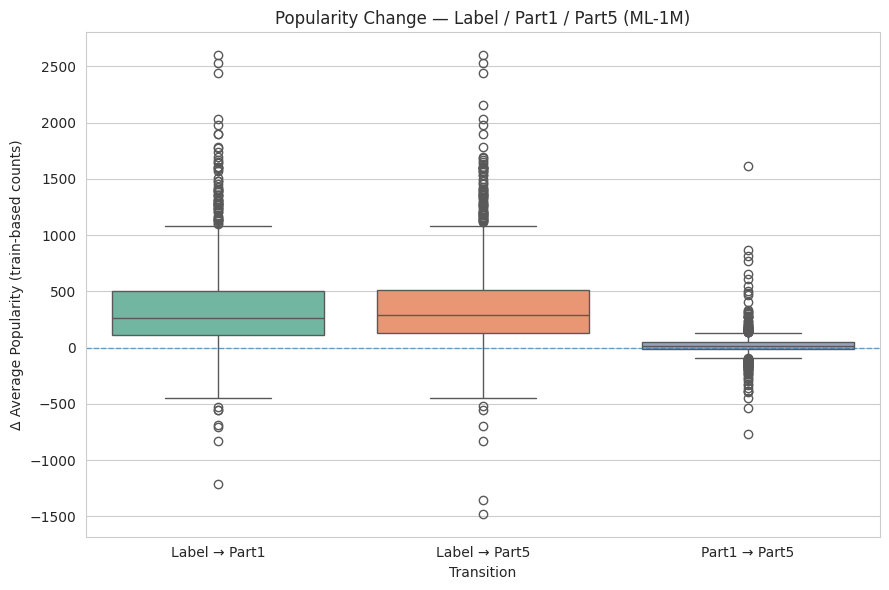

Summary (Popularity Δ)
                count     mean      std       min      25%      50%      75%  \
transition                                                                     
Label → Part1  1143.0  352.334  391.261 -1211.667  107.797  263.407  505.139   
Label → Part5  1143.0  371.239  400.377 -1477.000  127.829  285.522  512.361   
Part1 → Part5  1143.0   18.905  109.458  -771.000   -9.337   11.453   48.026   

                  max  
transition             
Label → Part1  2598.0  
Label → Part5  2598.0  
Part1 → Part5  1614.0  


In [12]:
# ===== ML-1M: Label/Part1/Part5 Popularity Change Boxplot (genre refactor, no diversity) =====
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------
# 1) Popularity from train_data
# ---------------------------
item_pop = Counter()
for items in train_data.values():
    for it in items:
        item_pop[int(it)] += 1

# ---------------------------
# 2) Load predictions
# ---------------------------
with open(PRED_P1) as f:
    pred_p1 = json.load(f)
with open(PRED_P5) as f:
    pred_p5 = json.load(f)

print(len(train_data), "users in train_data")
print(len(ground_truth), "users in ground_truth (Label)")
print(len(pred_p1), "users in pred_p1")
print(len(pred_p5), "users in pred_p5")

# ---------------------------
# 3) Common users
#   - common_users는 (train ∩ gt) 라고 가정 (이전 코드에서 이미 계산)
#   - pred 둘 다 있는 사용자로 제한
# ---------------------------
common_users_pred = set(pred_p1.keys()) & set(pred_p5.keys())
common_users_label = set(ground_truth.keys())
common_users_final = set(map(str, common_users)) & common_users_pred & common_users_label
print("len(common_users_final):", len(common_users_final))

# ---------------------------
# 4) Popularity metric
# ---------------------------
def avg_popularity_from_item_ids(user_items: dict[str, list[int]]):
    """Return: dict[uid(str)] -> avg_popularity"""
    out = {}
    for uid, items in user_items.items():
        ids = [int(x) for x in items]
        pops = [item_pop.get(it, 0) for it in ids]
        out[str(uid)] = float(np.mean(pops)) if pops else 0.0
    return out

# 공통 사용자만 필터링
label_common = {u: ground_truth[u] for u in common_users_final}
p1_common    = {u: pred_p1[u]     for u in common_users_final}
p5_common    = {u: pred_p5[u]     for u in common_users_final}

m_label = avg_popularity_from_item_ids(label_common)
m_p1    = avg_popularity_from_item_ids(p1_common)
m_p5    = avg_popularity_from_item_ids(p5_common)

# ---------------------------
# 5) Δ transitions: Label->P1, Label->P5, P1->P5 (Popularity only)
# ---------------------------
d_label_p1 = []
d_label_p5 = []
d_p1_p5    = []

for u in common_users_final:
    lp = m_label.get(u, 0.0)
    p1 = m_p1.get(u, 0.0)
    p5 = m_p5.get(u, 0.0)

    d_label_p1.append(p1 - lp)
    d_label_p5.append(p5 - lp)
    d_p1_p5.append(p5 - p1)

df_delta = pd.DataFrame({
    "delta": d_label_p1 + d_label_p5 + d_p1_p5,
    "transition": (["Label → Part1"] * len(d_label_p1))
                + (["Label → Part5"] * len(d_label_p5))
                + (["Part1 → Part5"] * len(d_p1_p5)),
    "metric": ["Popularity"] * (len(d_label_p1) + len(d_label_p5) + len(d_p1_p5)),
    "case": ["ML-1M"] * (len(d_label_p1) + len(d_label_p5) + len(d_p1_p5)),
})

# ---------------------------
# 6) Plot
# ---------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(9, 6))

ax = sns.boxplot(
    data=df_delta,
    x="transition",
    y="delta",
    palette="Set2"
)

ax.set_title("Popularity Change — Label / Part1 / Part5 (ML-1M)")
ax.set_xlabel("Transition")
ax.set_ylabel("Δ Average Popularity (train-based counts)")
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)

plt.tight_layout()
plt.show()

print("Summary (Popularity Δ)")
print(df_delta.groupby("transition")["delta"].describe().round(3))


len(common_users_base): 1143
A-LLMRec: users used = 1142
LLMRec: users used = 1143
Augmentation: users used = 1143
df_delta shape: (3428, 5)


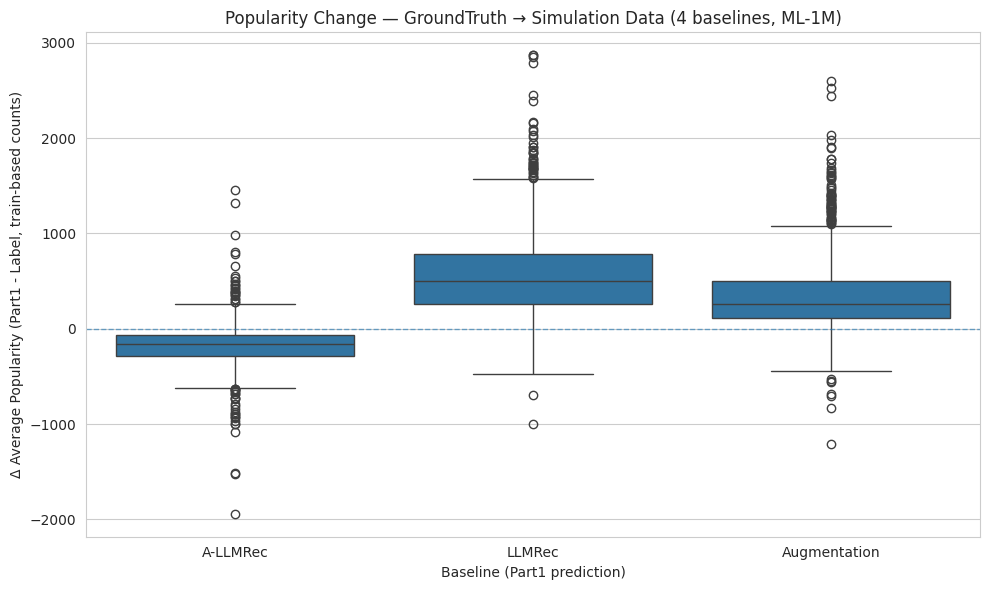

Summary (Δ Popularity = Part1 - Label)
               count     mean      std       min      25%      50%      75%  \
baseline                                                                      
A-LLMRec      1142.0 -174.145  229.053 -1941.000 -288.923 -163.733  -64.594   
Augmentation  1143.0  352.334  391.261 -1211.667  107.797  263.407  505.139   
LLMRec        1143.0  562.667  462.715 -1000.333  255.971  501.495  786.586   

                 max  
baseline              
A-LLMRec      1455.0  
Augmentation  2598.0  
LLMRec        2869.0  
plot is saved -> /home/parkdw00/Codes/data/ml-1m/plots/popularity.png


In [14]:
# ===== ML-1M: Label vs Part1 (4 baselines) Popularity Change Boxplot =====
import json
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 0) Paths (Part1 predictions of 4 baselines)
# ---------------------------
BASELINES_P1 = {
    "A-LLMRec": "/home/parkdw00/Codes/data/ml-1m/A-LLMRec_format/A-LLMRec_results/predict_label_part1.json",
    "LLMRec": "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/predict_label_part1.json",
    "Augmentation": "/home/parkdw00/Codes/data/ml-1m/Augmentation_format/predict_label_part1.json",
    #"TraditionalCF": "/home/parkdw00/Codes/data/ml-1m/traditionalCF/predict_label_part1.json",
}

# ---------------------------
# 1) Popularity from train_data
# ---------------------------
def build_item_popularity(train_data: dict) -> Counter:
    item_pop = Counter()
    for items in train_data.values():
        for it in items:
            item_pop[int(it)] += 1
    return item_pop

item_pop = build_item_popularity(train_data)

# ---------------------------
# 2) Utilities
# ---------------------------
def load_json(path: str) -> dict:
    with open(path, "r") as f:
        return json.load(f)

def avg_popularity_from_item_ids(user_items: dict, item_pop: Counter) -> dict[str, float]:
    """user_items: dict[uid]->list[item_id], return dict[str(uid)]->avg_popularity"""
    out = {}
    for uid, items in user_items.items():
        if items is None:
            out[str(uid)] = 0.0
            continue
        ids = [int(x) for x in items]
        pops = [item_pop.get(it, 0) for it in ids]
        out[str(uid)] = float(np.mean(pops)) if len(pops) > 0 else 0.0
    return out

def filter_dict_by_users(d: dict, users: set[str]) -> dict:
    return {u: d[u] for u in users if u in d}

# ---------------------------
# 3) Common users base
#   - common_users: (train ∩ gt)라고 가정(기존 코드 그대로 사용)
# ---------------------------
common_users_base = set(map(str, common_users))  # uid를 str로 통일
label_users = set(map(str, ground_truth.keys()))
common_users_base = common_users_base & label_users

print("len(common_users_base):", len(common_users_base))

# Label popularity (고정)
label_common = filter_dict_by_users({str(k): v for k, v in ground_truth.items()}, common_users_base)
m_label = avg_popularity_from_item_ids(label_common, item_pop)

# ---------------------------
# 4) For each baseline: compute Δ (Part1 - Label)
# ---------------------------
rows = []
baseline_pred = {}

for bname, ppath in BASELINES_P1.items():
    pred = load_json(ppath)
    pred = {str(k): v for k, v in pred.items()}  # uid str 통일
    baseline_pred[bname] = pred

    # 이 baseline에서 실제로 pred가 있는 사용자만 (Label도 있어야 함)
    users_b = common_users_base & set(pred.keys())

    # 사용자 필터
    pred_common = filter_dict_by_users(pred, users_b)

    # popularity metric
    m_pred = avg_popularity_from_item_ids(pred_common, item_pop)

    # delta
    for u in users_b:
        lp = m_label.get(u, 0.0)
        pp = m_pred.get(u, 0.0)
        rows.append({
            "uid": u,
            "baseline": bname,
            "delta": pp - lp,
            "metric": "Popularity",
            "case": "ML-1M",
        })

    print(f"{bname}: users used = {len(users_b)}")

df_delta = pd.DataFrame(rows)
print("df_delta shape:", df_delta.shape)

# ---------------------------
# 5) Plot (single plot comparing 4 baselines)
# ---------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    data=df_delta,
    x="baseline",
    y="delta",
    order=list(BASELINES_P1.keys()),
)

ax.set_title("Popularity Change — GroundTruth → Simulation Data (4 baselines, ML-1M)")
ax.set_xlabel("Baseline (Part1 prediction)")
ax.set_ylabel("Δ Average Popularity (Part1 - Label, train-based counts)")
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)

plt.tight_layout()
#plt 저장
plt.savefig("/home/parkdw00/Codes/data/ml-1m/plots/popularity.png", dpi=300)
plt.show()

# ---------------------------
# 6) Summary
# ---------------------------
print("Summary (Δ Popularity = Part1 - Label)")
print(df_delta.groupby("baseline")["delta"].describe().round(3))
print("plot is saved -> /home/parkdw00/Codes/data/ml-1m/plots/popularity.png")

len(common_users_base): 1143
A-LLMRec: users used = 1139
  - p1: /home/parkdw00/Codes/data/ml-1m/A-LLMRec_format/A-LLMRec_results/predict_label_part1.json
  - p5: /home/parkdw00/Codes/data/ml-1m/A-LLMRec_format/A-LLMRec_results/predict_label_part5.json
LLMRec: users used = 1143
  - p1: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/predict_label_part1.json
  - p5: /home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/predict_label_part5.json
Augmentation: users used = 1143
  - p1: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/predict_label_part1.json
  - p5: /home/parkdw00/Codes/data/ml-1m/Augmentation_format/predict_label_part5.json
df_delta shape: (3425, 5)


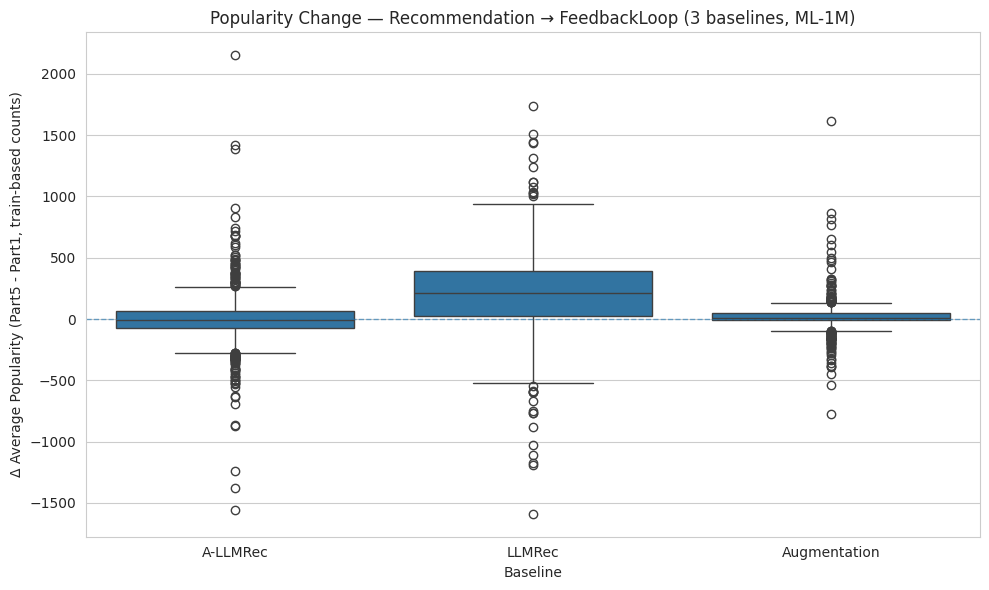

Summary (Δ Popularity = Part5 - Part1)
               count     mean      std     min     25%      50%      75%  \
baseline                                                                   
A-LLMRec      1139.0   -3.231  203.879 -1560.0 -72.536   -5.688   63.163   
Augmentation  1143.0   18.905  109.458  -771.0  -9.337   11.453   48.026   
LLMRec        1143.0  210.119  314.529 -1588.5  26.503  212.167  394.334   

                 max  
baseline              
A-LLMRec      2152.0  
Augmentation  1614.0  
LLMRec        1741.5  
plot is saved -> /home/parkdw00/Codes/data/ml-1m/plots/popularity_p1_to_p5.png


In [16]:
# ===== ML-1M: Part1 -> Part5 (4 baselines) Popularity Change Boxplot =====
import os
import json
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 0) Paths (Part1 predictions of 4 baselines)
# ---------------------------
BASELINES_P1 = {
    "A-LLMRec": "/home/parkdw00/Codes/data/ml-1m/A-LLMRec_format/A-LLMRec_results/predict_label_part1.json",
    "LLMRec": "/home/parkdw00/Codes/data/ml-1m/ml-1m_llmrec_format/predict_label_part1.json",
    "Augmentation": "/home/parkdw00/Codes/data/ml-1m/Augmentation_format/predict_label_part1.json",
    #"TraditionalCF": "/home/parkdw00/Codes/data/ml-1m/traditionalCF/predict_label_part1.json",
}

def part1_to_part5_path(p1_path: str) -> str:
    return p1_path.replace("predict_label_part1.json", "predict_label_part5.json")

BASELINES_P5 = {k: part1_to_part5_path(v) for k, v in BASELINES_P1.items()}

# ---------------------------
# 1) Popularity from train_data (same)
# ---------------------------
def build_item_popularity(train_data: dict) -> Counter:
    item_pop = Counter()
    for items in train_data.values():
        for it in items:
            item_pop[int(it)] += 1
    return item_pop

item_pop = build_item_popularity(train_data)

# ---------------------------
# 2) Utilities
# ---------------------------
def load_json(path: str) -> dict:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r") as f:
        return json.load(f)

def avg_popularity_from_item_ids(user_items: dict, item_pop: Counter) -> dict[str, float]:
    """user_items: dict[uid]->list[item_id], return dict[str(uid)]->avg_popularity"""
    out = {}
    for uid, items in user_items.items():
        if items is None:
            out[str(uid)] = 0.0
            continue
        if isinstance(items, int):
            items = [items]
        ids = [int(x) for x in items]
        pops = [item_pop.get(it, 0) for it in ids]
        out[str(uid)] = float(np.mean(pops)) if len(pops) > 0 else 0.0
    return out

def filter_dict_by_users(d: dict, users: set[str]) -> dict:
    return {u: d[u] for u in users if u in d}

# ---------------------------
# 3) For each baseline: compute Δ (Part5 - Part1)
#   - common_users는 네 기존 정의를 그대로 쓴다고 가정
# ---------------------------
common_users_base = set(map(str, common_users))  # uid str 통일
print("len(common_users_base):", len(common_users_base))

rows = []

for bname in BASELINES_P1.keys():
    p1_path = BASELINES_P1[bname]
    p5_path = BASELINES_P5[bname]

    pred_p1 = load_json(p1_path)
    pred_p5 = load_json(p5_path)

    pred_p1 = {str(k): v for k, v in pred_p1.items()}
    pred_p5 = {str(k): v for k, v in pred_p5.items()}

    # Part1과 Part5 둘 다 존재하는 유저 + common_users
    users_b = common_users_base & set(pred_p1.keys()) & set(pred_p5.keys())

    pred_p1_common = filter_dict_by_users(pred_p1, users_b)
    pred_p5_common = filter_dict_by_users(pred_p5, users_b)

    m_p1 = avg_popularity_from_item_ids(pred_p1_common, item_pop)
    m_p5 = avg_popularity_from_item_ids(pred_p5_common, item_pop)

    for u in users_b:
        p1v = m_p1.get(u, 0.0)
        p5v = m_p5.get(u, 0.0)
        rows.append({
            "uid": u,
            "baseline": bname,
            "delta": p5v - p1v,   # 핵심: Part5 - Part1
            "metric": "Popularity",
            "case": "ML-1M",
        })

    print(f"{bname}: users used = {len(users_b)}")
    print(f"  - p1: {p1_path}")
    print(f"  - p5: {p5_path}")

df_delta = pd.DataFrame(rows)
print("df_delta shape:", df_delta.shape)

# ---------------------------
# 4) Plot (single plot comparing 4 baselines)
# ---------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    data=df_delta,
    x="baseline",
    y="delta",
    order=list(BASELINES_P1.keys()),
)

ax.set_title("Popularity Change — Recommendation → FeedbackLoop (3 baselines, ML-1M)")
ax.set_xlabel("Baseline")
ax.set_ylabel("Δ Average Popularity (Part5 - Part1, train-based counts)")
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)

plt.tight_layout()
out_path = "/home/parkdw00/Codes/data/ml-1m/plots/popularity_p1_to_p5.png"
plt.savefig(out_path, dpi=300)
plt.show()

# ---------------------------
# 5) Summary
# ---------------------------
print("Summary (Δ Popularity = Part5 - Part1)")
print(df_delta.groupby("baseline")["delta"].describe().round(3))
print("plot is saved ->", out_path)


# RQ4
피드백 루프로 생성된 임베딩으로 분터 발생할 수 있는 위험성 분석(양극화, 필터버블 등)

포함: LLMRec, A-LLMRec, Augmentation, TR_CF

## Polarization

### 5스텝 한번에 저장

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, json, math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# =========================
# 경로/설정
# =========================
STEPS    = list(range(PARTS))
CLUSTER_STEP = STEPS[-1]              # 최종 step에서 KMeans 수행
OUT_DIR  = os.path.join(BASE_DIR, "figs_tsne_cluster_progress")
os.makedirs(OUT_DIR, exist_ok=True)

TSNE_PERPLEXITY      = 30
TSNE_RANDOM_STATE    = 42
KMEANS_RANDOM_STATE  = 42
K_USERS = 2
K_ITEMS = 2

# (선택) t-SNE 가속 샘플링
SUBSAMPLE_USERS_FOR_TSNE = None  # 예: 5000
SUBSAMPLE_ITEMS_FOR_TSNE = None  # 예: 5000

# =========================
# 유틸
# =========================
def load_users_items_for_step(base_dir: str, parts: int, step: int):
    # upath = os.path.join(base_dir, f"u_i_embedding_in_sasrec/ml-1m_case2_parts{parts}/user_emb_part_step0{step}.npy")
    # ipath = os.path.join(base_dir, f"u_i_embedding_in_sasrec/ml-1m_case2_parts{parts}/item_emb_part0{step}.npy")
    upath = os.path.join(base_dir, f"user_emb_part{parts}_step{step}.npy")
    ipath = os.path.join(base_dir, f"item_emb_part{parts}_step{step}.npy")
    if not os.path.exists(upath):
        raise FileNotFoundError(upath)
    U = np.load(upath)  # shape: (num_users_step, d)
    I = np.load(ipath) if os.path.exists(ipath) else None  # shape: (num_items_step, d) or None
    if U.ndim != 2:
        raise ValueError(f"user_emb shape invalid at step{step}: {U.shape}")
    if I is not None and I.ndim != 2:
        raise ValueError(f"item_emb shape invalid at step{step}: {I.shape}")
    return U, I


def align_users_for_step(common_users, num_users_step: int) -> np.ndarray:
    """
    common_users: set/list/ndarray 모두 허용.
    num_users_step: 이 step의 user 축 길이 (ex. user_by_step[s].shape[0])
    return: [N_u'] 정렬된 유효 유저 id 배열
    """
    # 1) 입력을 넘파이 int64 배열로 통일
    if isinstance(common_users, (set, list, tuple)):
        cu = np.asarray(sorted(common_users), dtype=np.int64)  # 재현성 위해 정렬 권장
    else:
        cu = np.asarray(common_users, dtype=np.int64)

    if cu.size == 0:
        return cu

    # 2) 유효 범위 마스킹
    mask = (cu >= 0) & (cu < num_users_step)
    return cu[mask]


# =========================
# 1) 각 step 임베딩 로드
# =========================
print("Loading augmentation embeddings per step...")
user_by_step = {}
item_by_step = {}
dims = set()

for s in STEPS:
    U, I = load_users_items_for_step(BASE_DIR, PARTS, s)
    user_by_step[s] = U
    item_by_step[s] = I
    dims.add(U.shape[1])
    if I is not None:
        dims.add(I.shape[1])
    print(f"  - step{s}: users={U.shape}, items={None if I is None else I.shape}")

if len(dims) != 1:
    raise RuntimeError(f"임베딩 차원이 step별로 다릅니다: {dims}")
D = dims.pop()

# =========================
# 2) train∩label 공통 유저 산출 + step별 정렬
# =========================
print(f"common users: {len(common_users)}")

aligned_users_by_step = {s: align_users_for_step(common_users, user_by_step[s].shape[0])
                         for s in STEPS}
print({s: len(aligned_users_by_step[s]) for s in STEPS})

# =========================
# 3) 아이템 공통 부분 정렬(최소 길이)
# =========================
item_lengths = [item_by_step[s].shape[0] for s in STEPS if item_by_step[s] is not None]
if len(item_lengths) == 0:
    I_base = 0
else:
    I_base = min(item_lengths)
    uniq = set(item_lengths)
    if len(uniq) != 1:
        print(f"[warn] step별 아이템 수가 다릅니다: {uniq} → 앞에서 {I_base}개만 공통 사용")
    for s in STEPS:
        I = item_by_step[s]
        item_by_step[s] = None if I is None or I.shape[0] < I_base else I[:I_base]

rng = np.random.RandomState(0)
if I_base > 0:
    if SUBSAMPLE_ITEMS_FOR_TSNE is not None and SUBSAMPLE_ITEMS_FOR_TSNE < I_base:
        keep_items = np.sort(rng.choice(I_base, size=SUBSAMPLE_ITEMS_FOR_TSNE, replace=False))
    else:
        keep_items = np.arange(I_base)
else:
    keep_items = np.array([], dtype=int)

# =========================
# 4) 최종 step에서 KMeans → 레이블 생성
# =========================
print(f"KMeans on final step: step{CLUSTER_STEP}")
U_final = user_by_step[CLUSTER_STEP]
ids_final = aligned_users_by_step[CLUSTER_STEP]
if len(ids_final) < K_USERS:
    raise RuntimeError(f"최종 step에서 클러스터링 가능한 공통 유저가 부족합니다: {len(ids_final)}")

emb_final_users = U_final[ids_final, :]  # (|ids_final|, D)
user_kmeans = KMeans(n_clusters=K_USERS, random_state=KMEANS_RANDOM_STATE, n_init=10)
user_labels_final = user_kmeans.fit_predict(emb_final_users)
user_center_idx = {k: user_labels_final == k for k in range(K_USERS)}

# 아이템 KMeans (최종 step 공통 아이템)
if item_by_step[CLUSTER_STEP] is not None and len(keep_items) > 0:
    I_final = item_by_step[CLUSTER_STEP][keep_items]  # (|keep_items|, D)
    item_kmeans = KMeans(n_clusters=K_ITEMS, random_state=KMEANS_RANDOM_STATE, n_init=10)
    item_labels_final = item_kmeans.fit_predict(I_final)
else:
    item_kmeans = None
    item_labels_final = None
    print("[warn] 최종 step 아이템이 없어 item clustering 생략")

# =========================
# 5) t-SNE에 넣을 데이터 블록 구성 (users + items across steps)
# =========================
print("Preparing t-SNE blocks...")
ids_for_tsne = {}      # step -> user_id 배열(샘플링 반영)
users_for_tsne = {}    # step -> user_emb 배열
item_for_tsne  = {}    # step -> item_emb 배열 (공통 keep_items에 해당)

# 유저 샘플링 기준: 최종 step의 ids_final 집합
if SUBSAMPLE_USERS_FOR_TSNE is not None and SUBSAMPLE_USERS_FOR_TSNE < len(ids_final):
    sample_users = np.sort(rng.choice(ids_final, size=SUBSAMPLE_USERS_FOR_TSNE, replace=False))
else:
    sample_users = ids_final

for s in STEPS:
    ids_s = aligned_users_by_step[s]
    if len(ids_s) == 0:
        ids_for_tsne[s] = np.array([], dtype=np.int64)
        users_for_tsne[s] = np.empty((0, D), dtype=np.float32)
    else:
        mask = np.isin(ids_s, sample_users)
        ids_for_tsne[s] = ids_s[mask]
        users_for_tsne[s] = user_by_step[s][ids_for_tsne[s], :]

    I = item_by_step[s]
    item_for_tsne[s] = None if I is None or len(keep_items) == 0 else I[keep_items]

# =========================
# 6) t-SNE 수행 (모든 step의 유저/아이템 합쳐서)
# =========================
print("Fitting joint t-SNE on users + items across steps")
blocks = []
slices = {}  # step -> {"user": (st,en), "item": (st,en) or None}
cursor = 0

for s in STEPS:
    Ublk = users_for_tsne[s]
    blocks.append(Ublk)
    u_st, u_en = cursor, cursor + len(Ublk)
    cursor = u_en

    Iblk = item_for_tsne[s]
    if Iblk is not None and len(Iblk) > 0:
        blocks.append(Iblk)
        i_st, i_en = cursor, cursor + len(Iblk)
        cursor = i_en
        slices[s] = {"user": (u_st, u_en), "item": (i_st, i_en)}
    else:
        slices[s] = {"user": (u_st, u_en), "item": None}

if len(blocks) == 0 or sum(len(b) for b in blocks) < 3:
    raise RuntimeError("t-SNE에 사용할 표본이 너무 적습니다.")

X_all = np.vstack(blocks)
perp = min(TSNE_PERPLEXITY, max(5, (len(X_all) - 1)//3))
tsne = TSNE(
    n_components=2,
    perplexity=perp,
    init="pca",
    learning_rate="auto",
    random_state=TSNE_RANDOM_STATE,
    max_iter=1000,
    verbose=1
)
X_tsne = tsne.fit_transform(X_all)

# 좌표 범위(공통 축)
xmin, ymin = X_tsne.min(axis=0)
xmax, ymax = X_tsne.max(axis=0)
xpad = 0.05 * (xmax - xmin) if xmax > xmin else 0.5
ypad = 0.05 * (ymax - ymin) if ymax > ymin else 0.5

# 최종 step 중심 좌표(사용자/아이템)
palette = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple",
           "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]

def compute_centers(coords: np.ndarray, labels: np.ndarray, K: int):
    centers = {}
    for k in range(K):
        mask = (labels == k)
        if np.any(mask):
            centers[k] = coords[mask].mean(axis=0)
    return centers

# 최종 step 사용자/아이템 좌표 슬라이스
u_st_f, u_en_f = slices[CLUSTER_STEP]["user"]
coords_u_final = X_tsne[u_st_f:u_en_f]
# user_labels_final는 ids_final(=샘플링 전 최종 step 공통유저)에 대한 레이블
# t-SNE에는 sample_users만 포함됐을 수 있으므로, ids_for_tsne[CLUSTER_STEP] 순서에 맞춰 레이블 재정렬
ids_tsne_final = ids_for_tsne[CLUSTER_STEP]
# ids_tsne_final의 각 user_id가 ids_final 내에서의 index를 찾아 매핑
idx_map_final = {int(u): i for i, u in enumerate(ids_final.tolist())}
labels_u_for_plot = np.array([user_labels_final[idx_map_final[int(u)]] for u in ids_tsne_final], dtype=int)
user_centers = compute_centers(coords_u_final, labels_u_for_plot, K_USERS)

if slices[CLUSTER_STEP]["item"] is not None and item_labels_final is not None:
    i_st_f, i_en_f = slices[CLUSTER_STEP]["item"]
    coords_i_final = X_tsne[i_st_f:i_en_f]
    item_centers = compute_centers(coords_i_final, item_labels_final, K_ITEMS)
else:
    item_centers = {}

# =========================
# 7) 그림 저장 — Users only / Items only / Users+Items
# =========================
def plot_users_only():
    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))
    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        u_st, u_en = slices[s]["user"]
        coords_u = X_tsne[u_st:u_en]
        # 최종 step 기준 라벨로 색칠
        if s == CLUSTER_STEP:
            labels_plot = labels_u_for_plot
        else:
            # 다른 step은 같은 사용자(샘플링된 ids)에 대해 동일한 라벨을 사용
            # ids_for_tsne[s] -> ids_tsne_final로 매핑
            ids_tsne_s = ids_for_tsne[s]
            labels_plot = np.empty((len(ids_tsne_s),), dtype=int)
            for i, uid in enumerate(ids_tsne_s):
                labels_plot[i] = labels_u_for_plot[np.where(ids_tsne_final == uid)[0][0]]
        for k in range(K_USERS):
            mk = (labels_plot == k)
            if np.any(mk):
                ax.scatter(coords_u[mk,0], coords_u[mk,1], s=8, alpha=0.7,
                           c=palette[k % len(palette)], label=f"Users: C{k}")
        if s == CLUSTER_STEP:
            for k, ctr in user_centers.items():
                ax.scatter(ctr[0], ctr[1], s=120, marker="X",
                           c=palette[k % len(palette)], edgecolor="k")
        ax.set_title(f"step{s} (Users only, colored by step{CLUSTER_STEP})")
        ax.set_xticks([]); ax.set_yticks([])
        # 고정 축을 쓰고 싶으면 주석 해제
        # ax.set_xlim(xmin - xpad, xmax + xpad)
        # ax.set_ylim(ymin - ypad, ymax + ypad)
        if idx == 1:
            ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_USERS_ONLY.png")
    plt.savefig(out, dpi=220); plt.close()
    print("  - saved:", out)

def plot_items_only():
    has_any = any(item_for_tsne[s] is not None for s in STEPS) and (item_labels_final is not None)
    if not has_any:
        print("  - Item only plot 생략(아이템 임베딩/라벨 없음)")
        return
    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))
    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        if slices[s]["item"] is not None:
            i_st, i_en = slices[s]["item"]
            coords_i = X_tsne[i_st:i_en]
            # 최종 step의 item_labels_final을 그대로 사용 (공통 keep_items에 대응)
            for k in range(K_ITEMS):
                mk = (item_labels_final == k)
                if np.any(mk):
                    ax.scatter(coords_i[mk,0], coords_i[mk,1], s=5, alpha=0.35,
                               c=palette[(k+2) % len(palette)], label=f"Items: C{k}")
            if s == CLUSTER_STEP and len(item_centers) > 0:
                for k, ctr in item_centers.items():
                    ax.scatter(ctr[0], ctr[1], s=110, marker="D",
                               c=palette[(k+2) % len(palette)], edgecolor="k")
        ax.set_title(f"step{s} (Items only, colored by step{CLUSTER_STEP})")
        ax.set_xticks([]); ax.set_yticks([])
        if idx == 1:
            ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_ITEMS_ONLY.png")
    plt.savefig(out, dpi=220); plt.close()
    print("  - saved:", out)

def plot_users_items():
    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))
    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        # 아이템
        if slices[s]["item"] is not None and item_labels_final is not None:
            i_st, i_en = slices[s]["item"]
            coords_i = X_tsne[i_st:i_en]
            for k in range(K_ITEMS):
                mk = (item_labels_final == k)
                if np.any(mk):
                    ax.scatter(coords_i[mk,0], coords_i[mk,1], s=5, alpha=0.35,
                               c=palette[(k+2) % len(palette)], label=f"Items: C{k}")
            if s == CLUSTER_STEP and len(item_centers) > 0:
                for k, ctr in item_centers.items():
                    ax.scatter(ctr[0], ctr[1], s=110, marker="D",
                               c=palette[(k+2) % len(palette)], edgecolor="k")
        # 유저
        u_st, u_en = slices[s]["user"]
        coords_u = X_tsne[u_st:u_en]
        # step별 유저 라벨 구성
        if s == CLUSTER_STEP:
            labels_plot = labels_u_for_plot
        else:
            ids_tsne_s = ids_for_tsne[s]
            labels_plot = np.empty((len(ids_tsne_s),), dtype=int)
            for i, uid in enumerate(ids_tsne_s):
                labels_plot[i] = labels_u_for_plot[np.where(ids_tsne_final == uid)[0][0]]
        for k in range(K_USERS):
            mk = (labels_plot == k)
            if np.any(mk):
                ax.scatter(coords_u[mk,0], coords_u[mk,1], s=8, alpha=0.7,
                           c=palette[k % len(palette)], label=f"Users: C{k}")
        if s == CLUSTER_STEP:
            for k, ctr in user_centers.items():
                ax.scatter(ctr[0], ctr[1], s=120, marker="X",
                           c=palette[k % len(palette)], edgecolor="k")

        ax.set_title(f"step{s} (Users & Items, colored by step{CLUSTER_STEP})")
        ax.set_xlim(xmin - xpad, xmax + xpad)
        ax.set_ylim(ymin - ypad, ymax + ypad)
        ax.set_xticks([]); ax.set_yticks([])
        if idx == 1:
            ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_USERS_ITEMS.png")
    plt.savefig(out, dpi=220); plt.close()
    print("  - saved:", out)

print("Plotting...")
plot_users_only()
plot_items_only()
plot_users_items()
print("Done.")


Loading augmentation embeddings per step...
  - step0: users=(5400, 50), items=(3693, 50)
  - step1: users=(5400, 50), items=(3693, 50)
  - step2: users=(5400, 50), items=(3693, 50)
  - step3: users=(5400, 50), items=(3693, 50)
  - step4: users=(5400, 50), items=(3693, 50)
common users: 1143
{0: 1143, 1: 1143, 2: 1143, 3: 1143, 4: 1143}
KMeans on final step: step4
Preparing t-SNE blocks...
Fitting joint t-SNE on users + items across steps
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24180 samples in 0.001s...
[t-SNE] Computed neighbors for 24180 samples in 2.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24180
[t-SNE] Computed conditional probabilities for sample 2000 / 24180
[t-SNE] Computed conditional probabilities for sample 3000 / 24180
[t-SNE] Computed conditional probabilities for sample 4000 / 24180
[t-SNE] Computed conditional probabilities for sample 5000 / 24180
[t-SNE] Computed conditional probabilities for sample 6000 / 24180
[t-SNE] Comp

### 각자 Step별 저장

In [40]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# ============================================================
# 사용자 환경에서 미리 정의되어 있어야 하는 값들
#   - BASE_DIR: 임베딩(.npy)들이 있는 디렉토리
#   - PARTS: step 개수 (예: 5)
#   - common_users: train∩label 공통 유저 id 집합/리스트/ndarray
# ============================================================
# BASE_DIR = "..."
# PARTS = 5
# common_users = ...

# =========================
# 경로/설정
# =========================
STEPS = list(range(PARTS))
CLUSTER_STEP = STEPS[-1]  # 최종 step에서 KMeans 수행
OUT_DIR = os.path.join(BASE_DIR, "figs_tsne_cluster_progress")
os.makedirs(OUT_DIR, exist_ok=True)

TSNE_PERPLEXITY = 30
TSNE_RANDOM_STATE = 42
KMEANS_RANDOM_STATE = 42
K_USERS = 2
K_ITEMS = 2

# (선택) t-SNE 가속 샘플링
SUBSAMPLE_USERS_FOR_TSNE = None  # 예: 5000
SUBSAMPLE_ITEMS_FOR_TSNE = None  # 예: 5000

# (전역) t-SNE 2D에서 중심으로부터 거리 상위 p%를 "플로팅에서만" 제거
GLOBAL_TRIM_TOP_PCT = 0.0   # 전역 trimming 원하면 0.005 등으로 (0이면 전역 trim off)

# (핵심) step별(local) trimming: step1의 외딴 점 같은 걸 제거
STEP_TRIM_TOP_PCT = 0.01        # 기본: 각 step에서 상위 0.2% 제거
STEP_TRIM_TOP_PCT_STEP1 = 0.01  # step==1만 더 세게(0.5%) 제거

# =========================
# 유틸
# =========================
def load_users_items_for_step(base_dir: str, parts: int, step: int):
    upath = os.path.join(base_dir, f"user_emb_part{parts}_step{step}.npy")
    ipath = os.path.join(base_dir, f"item_emb_part{parts}_step{step}.npy")
    if not os.path.exists(upath):
        raise FileNotFoundError(upath)
    U = np.load(upath)  # (num_users_step, d)
    I = np.load(ipath) if os.path.exists(ipath) else None  # (num_items_step, d) or None
    if U.ndim != 2:
        raise ValueError(f"user_emb shape invalid at step{step}: {U.shape}")
    if I is not None and I.ndim != 2:
        raise ValueError(f"item_emb shape invalid at step{step}: {I.shape}")
    return U, I


def align_users_for_step(common_users, num_users_step: int) -> np.ndarray:
    if isinstance(common_users, (set, list, tuple)):
        cu = np.asarray(sorted(common_users), dtype=np.int64)
    else:
        cu = np.asarray(common_users, dtype=np.int64)

    if cu.size == 0:
        return cu

    mask = (cu >= 0) & (cu < num_users_step)
    return cu[mask]


def compute_centers(coords: np.ndarray, labels: np.ndarray, K: int):
    centers = {}
    for k in range(K):
        mk = (labels == k)
        if np.any(mk):
            centers[k] = coords[mk].mean(axis=0)
    return centers


def stepwise_trim_mask(coords2d: np.ndarray, top_pct: float) -> np.ndarray:
    """
    coords2d: (N,2)
    top_pct: 이 step에서 중심으로부터 거리 상위 top_pct 제거 (plot-only)
    return: keep mask (True=keep)
    """
    n = 0 if coords2d is None else len(coords2d)
    if n == 0:
        return np.zeros((0,), dtype=bool)
    if top_pct is None or top_pct <= 0:
        return np.ones((n,), dtype=bool)
    if top_pct >= 1.0:
        return np.zeros((n,), dtype=bool)

    ctr = np.median(coords2d, axis=0)
    dist = np.linalg.norm(coords2d - ctr, axis=1)

    q = 1.0 - top_pct
    q = min(max(q, 0.0), 1.0)
    thr = np.quantile(dist, q)
    return dist <= thr


# =========================
# 1) 각 step 임베딩 로드
# =========================
print("Loading augmentation embeddings per step...")
user_by_step = {}
item_by_step = {}
dims = set()

for s in STEPS:
    U, I = load_users_items_for_step(BASE_DIR, PARTS, s)
    user_by_step[s] = U
    item_by_step[s] = I
    dims.add(U.shape[1])
    if I is not None:
        dims.add(I.shape[1])
    print(f"  - step{s}: users={U.shape}, items={None if I is None else I.shape}")

if len(dims) != 1:
    raise RuntimeError(f"임베딩 차원이 step별로 다릅니다: {dims}")
D = dims.pop()

# =========================
# 2) train∩label 공통 유저 산출 + step별 정렬
# =========================
print(f"common users: {len(common_users)}")
aligned_users_by_step = {
    s: align_users_for_step(common_users, user_by_step[s].shape[0])
    for s in STEPS
}
print({s: len(aligned_users_by_step[s]) for s in STEPS})

# =========================
# 3) 아이템 공통 부분 정렬(최소 길이)
# =========================
item_lengths = [item_by_step[s].shape[0] for s in STEPS if item_by_step[s] is not None]
if len(item_lengths) == 0:
    I_base = 0
else:
    I_base = min(item_lengths)
    uniq = set(item_lengths)
    if len(uniq) != 1:
        print(f"[warn] step별 아이템 수가 다릅니다: {uniq} → 앞에서 {I_base}개만 공통 사용")
    for s in STEPS:
        I = item_by_step[s]
        item_by_step[s] = None if (I is None or I.shape[0] < I_base) else I[:I_base]

rng = np.random.RandomState(0)
if I_base > 0:
    if SUBSAMPLE_ITEMS_FOR_TSNE is not None and SUBSAMPLE_ITEMS_FOR_TSNE < I_base:
        keep_items = np.sort(rng.choice(I_base, size=SUBSAMPLE_ITEMS_FOR_TSNE, replace=False))
    else:
        keep_items = np.arange(I_base, dtype=int)
else:
    keep_items = np.array([], dtype=int)

# =========================
# 4) 최종 step에서 KMeans → 레이블 생성
# =========================
print(f"KMeans on final step: step{CLUSTER_STEP}")
U_final = user_by_step[CLUSTER_STEP]
ids_final = aligned_users_by_step[CLUSTER_STEP]
if len(ids_final) < K_USERS:
    raise RuntimeError(f"최종 step에서 클러스터링 가능한 공통 유저가 부족합니다: {len(ids_final)}")

emb_final_users = U_final[ids_final, :]  # (|ids_final|, D)
user_kmeans = KMeans(n_clusters=K_USERS, random_state=KMEANS_RANDOM_STATE, n_init=10)
user_labels_final_full = user_kmeans.fit_predict(emb_final_users)  # ids_final 순서 기준

# 아이템 KMeans (최종 step 공통 아이템)
if item_by_step[CLUSTER_STEP] is not None and len(keep_items) > 0:
    I_final = item_by_step[CLUSTER_STEP][keep_items, :]  # (|keep_items|, D)
    item_kmeans = KMeans(n_clusters=K_ITEMS, random_state=KMEANS_RANDOM_STATE, n_init=10)
    item_labels_final_full = item_kmeans.fit_predict(I_final)  # keep_items 순서 기준
else:
    item_kmeans = None
    item_labels_final_full = None
    print("[warn] 최종 step 아이템이 없어 item clustering 생략")

# ids_final uid -> label 매핑 (최종 step 기준)
uid2label = {int(uid): int(lb) for uid, lb in zip(ids_final.tolist(), user_labels_final_full.tolist())}

# =========================
# 5) t-SNE에 넣을 데이터 블록 구성 (users + items across steps)
# =========================
print("Preparing t-SNE blocks...")
ids_for_tsne = {}      # step -> user_id 배열(샘플링 반영)
users_for_tsne = {}    # step -> user_emb 배열
item_for_tsne  = {}    # step -> item_emb 배열 (공통 keep_items에 해당)

# 유저 샘플링 기준: 최종 step의 ids_final 집합
if SUBSAMPLE_USERS_FOR_TSNE is not None and SUBSAMPLE_USERS_FOR_TSNE < len(ids_final):
    sample_users = np.sort(rng.choice(ids_final, size=SUBSAMPLE_USERS_FOR_TSNE, replace=False))
else:
    sample_users = ids_final

for s in STEPS:
    ids_s = aligned_users_by_step[s]
    if len(ids_s) == 0:
        ids_for_tsne[s] = np.array([], dtype=np.int64)
        users_for_tsne[s] = np.empty((0, D), dtype=np.float32)
    else:
        mask = np.isin(ids_s, sample_users)
        ids_for_tsne[s] = ids_s[mask]
        users_for_tsne[s] = user_by_step[s][ids_for_tsne[s], :]

    I = item_by_step[s]
    item_for_tsne[s] = None if (I is None or len(keep_items) == 0) else I[keep_items, :]

# =========================
# 6) t-SNE 수행 (모든 step의 유저/아이템 합쳐서)
# =========================
print("Fitting joint t-SNE on users + items across steps")
blocks = []
slices = {}  # step -> {"user": (st,en), "item": (st,en) or None}
cursor = 0

for s in STEPS:
    Ublk = users_for_tsne[s]
    blocks.append(Ublk)
    u_st, u_en = cursor, cursor + len(Ublk)
    cursor = u_en

    Iblk = item_for_tsne[s]
    if Iblk is not None and len(Iblk) > 0:
        blocks.append(Iblk)
        i_st, i_en = cursor, cursor + len(Iblk)
        cursor = i_en
        slices[s] = {"user": (u_st, u_en), "item": (i_st, i_en)}
    else:
        slices[s] = {"user": (u_st, u_en), "item": None}

if len(blocks) == 0 or sum(len(b) for b in blocks) < 3:
    raise RuntimeError("t-SNE에 사용할 표본이 너무 적습니다.")

X_all = np.vstack(blocks)
perp = min(TSNE_PERPLEXITY, max(5, (len(X_all) - 1)//3))
tsne = TSNE(
    n_components=2,
    perplexity=perp,
    init="pca",
    learning_rate="auto",
    random_state=TSNE_RANDOM_STATE,
    max_iter=1000,
    verbose=1
)
X_tsne = tsne.fit_transform(X_all)

# =========================
# (선택) 전역 trimming (plot-only)
# =========================
if GLOBAL_TRIM_TOP_PCT is not None and GLOBAL_TRIM_TOP_PCT > 0:
    ctr2d = np.median(X_tsne, axis=0)
    dist2d = np.linalg.norm(X_tsne - ctr2d, axis=1)
    thr = np.quantile(dist2d, 1.0 - GLOBAL_TRIM_TOP_PCT)
    global_keep_mask = dist2d <= thr
    print(f"[global-trim] keep {global_keep_mask.sum()}/{len(global_keep_mask)} "
          f"({100.0 * global_keep_mask.mean():.2f}%) points")
else:
    global_keep_mask = np.ones((X_tsne.shape[0],), dtype=bool)

# 축 범위: 전역 keep 기준(없으면 전체)
X_plot = X_tsne[global_keep_mask]
xmin, ymin = X_plot.min(axis=0)
xmax, ymax = X_plot.max(axis=0)
xpad = 0.05 * (xmax - xmin) if xmax > xmin else 0.5
ypad = 0.05 * (ymax - ymin) if ymax > ymin else 0.5

palette = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple",
           "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]

# =========================
# 6.5) 최종 step 사용자/아이템의 (plot용) 라벨/센터 준비
#     - center 계산도 trimming(전역/로컬) 적용해서 일관되게
# =========================
# final users slice
u_st_f, u_en_f = slices[CLUSTER_STEP]["user"]
coords_u_final_all = X_tsne[u_st_f:u_en_f]
ids_tsne_final_all = ids_for_tsne[CLUSTER_STEP]
labels_u_final_all = np.array([uid2label[int(uid)] for uid in ids_tsne_final_all], dtype=int)

# 전역 trim 적용
g_keep_u_f = global_keep_mask[u_st_f:u_en_f]
coords_u_final_g = coords_u_final_all[g_keep_u_f]
ids_tsne_final_g = ids_tsne_final_all[g_keep_u_f]
labels_u_final_g = labels_u_final_all[g_keep_u_f]

# 최종 step에 대해 로컬 trim도 적용 (기본 step 규칙)
local_pct_f = STEP_TRIM_TOP_PCT_STEP1 if CLUSTER_STEP == 1 else STEP_TRIM_TOP_PCT
l_keep_u_f = stepwise_trim_mask(coords_u_final_g, top_pct=local_pct_f)
coords_u_final = coords_u_final_g[l_keep_u_f]
ids_tsne_final = ids_tsne_final_g[l_keep_u_f]
labels_u_for_plot = labels_u_final_g[l_keep_u_f]

user_centers = compute_centers(coords_u_final, labels_u_for_plot, K_USERS)

# final items slice
if slices[CLUSTER_STEP]["item"] is not None and item_labels_final_full is not None:
    i_st_f, i_en_f = slices[CLUSTER_STEP]["item"]
    coords_i_final_all = X_tsne[i_st_f:i_en_f]
    labels_i_final_all = item_labels_final_full

    # 전역 trim
    g_keep_i_f = global_keep_mask[i_st_f:i_en_f]
    coords_i_final_g = coords_i_final_all[g_keep_i_f]
    labels_i_final_g = labels_i_final_all[g_keep_i_f]

    # 로컬 trim(최종 step)
    local_pct_i_f = STEP_TRIM_TOP_PCT_STEP1 if CLUSTER_STEP == 1 else STEP_TRIM_TOP_PCT
    l_keep_i_f = stepwise_trim_mask(coords_i_final_g, top_pct=local_pct_i_f)
    coords_i_final = coords_i_final_g[l_keep_i_f]
    labels_i_final = labels_i_final_g[l_keep_i_f]

    item_centers = compute_centers(coords_i_final, labels_i_final, K_ITEMS)
else:
    item_centers = {}

# final uid -> position (trimmed final 기준)
pos_map_final = {int(uid): i for i, uid in enumerate(ids_tsne_final.tolist())}

# =========================
# 7) 그림 저장 — Users only / Items only / Users+Items
# =========================
def plot_users_only():
    step_dir = os.path.join(OUT_DIR, "step_by_step")
    os.makedirs(step_dir, exist_ok=True)

    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))

    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        fig_s, ax_s = plt.subplots(figsize=(6, 5))

        u_st, u_en = slices[s]["user"]
        coords_u_all = X_tsne[u_st:u_en]
        ids_tsne_s_all = ids_for_tsne[s]

        if len(ids_tsne_s_all) == 0:
            ax.set_xticks([]); ax.set_yticks([])
            plt.close(fig_s)
            continue

        # (1) 전역 trim
        g_keep = global_keep_mask[u_st:u_en]
        coords_u_g = coords_u_all[g_keep]
        ids_u_g = ids_tsne_s_all[g_keep]

        if len(ids_u_g) == 0:
            ax.set_xticks([]); ax.set_yticks([])
            plt.close(fig_s)
            continue

        # (2) step별 로컬 trim
        local_pct = STEP_TRIM_TOP_PCT_STEP1 if s == 1 else STEP_TRIM_TOP_PCT
        l_keep = stepwise_trim_mask(coords_u_g, top_pct=local_pct)
        coords_u = coords_u_g[l_keep]
        ids_tsne_s = ids_u_g[l_keep]

        if len(ids_tsne_s) == 0:
            ax.set_xticks([]); ax.set_yticks([])
            plt.close(fig_s)
            continue

        # final 기준 라벨로 색칠: final에 없는 uid는 버림
        valid_mask = np.array([int(uid) in pos_map_final for uid in ids_tsne_s], dtype=bool)
        coords_valid = coords_u[valid_mask]
        ids_valid = ids_tsne_s[valid_mask]

        if len(ids_valid) == 0:
            ax.set_xticks([]); ax.set_yticks([])
            plt.close(fig_s)
            continue

        labels_plot = np.array([labels_u_for_plot[pos_map_final[int(uid)]] for uid in ids_valid], dtype=int)

        for k in range(K_USERS):
            mk = (labels_plot == k)
            if np.any(mk):
                ax.scatter(coords_valid[mk, 0], coords_valid[mk, 1],
                           s=8, alpha=0.7, c=palette[k % len(palette)],
                           label=f"Users: C{k}")
                ax_s.scatter(coords_valid[mk, 0], coords_valid[mk, 1],
                             s=10, alpha=0.7, c=palette[k % len(palette)],
                             label=f"Users: C{k}")

        if s == CLUSTER_STEP:
            for k, ctr in user_centers.items():
                ax.scatter(ctr[0], ctr[1], s=120, marker="X",
                           c=palette[k % len(palette)], edgecolor="k")

        for a in (ax, ax_s):
            #a.set_xlim(xmin - xpad, xmax + xpad)
            #a.set_ylim(ymin - ypad, ymax + ypad)
            a.set_xticks([]); a.set_yticks([])

        if idx == 1:
            ax.legend(loc="best", frameon=True)
        ax_s.legend(loc="best", frameon=True)

        fig_s.tight_layout()
        out_s = os.path.join(step_dir, f"step{s}_tsne2d_USERS_ONLY.png")
        fig_s.savefig(out_s, dpi=220)
        plt.close(fig_s)
        print("  - saved:", out_s)

    fig.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_USERS_ONLY.png")
    fig.savefig(out, dpi=220)
    plt.close(fig)
    print("  - saved:", out)


def plot_items_only():
    has_any = any(item_for_tsne[s] is not None for s in STEPS) and (item_labels_final_full is not None)
    if not has_any:
        print("  - Item only plot 생략(아이템 임베딩/라벨 없음)")
        return

    step_dir = os.path.join(OUT_DIR, "step_by_step")
    os.makedirs(step_dir, exist_ok=True)

    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))

    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        fig_s, ax_s = plt.subplots(figsize=(5, 4))

        if slices[s]["item"] is not None:
            i_st, i_en = slices[s]["item"]
            coords_i_all = X_tsne[i_st:i_en]
            labels_i_all = item_labels_final_full

            # (1) 전역 trim
            g_keep = global_keep_mask[i_st:i_en]
            coords_i_g = coords_i_all[g_keep]
            labels_i_g = labels_i_all[g_keep]

            # (2) step별 로컬 trim
            local_pct = STEP_TRIM_TOP_PCT_STEP1 if s == 1 else STEP_TRIM_TOP_PCT
            l_keep = stepwise_trim_mask(coords_i_g, top_pct=local_pct)
            coords_i = coords_i_g[l_keep]
            labels_i = labels_i_g[l_keep]

            if len(coords_i) > 0:
                for k in range(K_ITEMS):
                    mk = (labels_i == k)
                    if np.any(mk):
                        ax.scatter(coords_i[mk, 0], coords_i[mk, 1],
                                   s=5, alpha=0.35, c=palette[(k+2) % len(palette)],
                                   label=f"Items: C{k}")
                        ax_s.scatter(coords_i[mk, 0], coords_i[mk, 1],
                                     s=5, alpha=0.35, c=palette[(k+2) % len(palette)],
                                     label=f"Items: C{k}")

                if s == CLUSTER_STEP and len(item_centers) > 0:
                    for k, ctr in item_centers.items():
                        ax.scatter(ctr[0], ctr[1], s=110, marker="D",
                                   c=palette[(k+2) % len(palette)], edgecolor="k")

        for a in (ax, ax_s):
            #a.set_xlim(xmin - xpad, xmax + xpad)
            #a.set_ylim(ymin - ypad, ymax + ypad)
            a.set_xticks([]); a.set_yticks([])

        if idx == 1:
            ax.legend(loc="best", frameon=True)
        ax_s.legend(loc="best", frameon=True)

        fig_s.tight_layout()
        out_s = os.path.join(step_dir, f"step{s}_tsne2d_ITEMS_ONLY.png")
        fig_s.savefig(out_s, dpi=220)
        plt.close(fig_s)
        print("  - saved:", out_s)

    fig.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_ITEMS_ONLY.png")
    fig.savefig(out, dpi=220)
    plt.close(fig)
    print("  - saved:", out)


def plot_users_items():
    step_dir = os.path.join(OUT_DIR, "step_by_step")
    os.makedirs(step_dir, exist_ok=True)

    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))

    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)

        # 아이템
        if slices[s]["item"] is not None and item_labels_final_full is not None:
            i_st, i_en = slices[s]["item"]
            coords_i_all = X_tsne[i_st:i_en]
            labels_i_all = item_labels_final_full

            # (1) 전역 trim
            g_keep = global_keep_mask[i_st:i_en]
            coords_i_g = coords_i_all[g_keep]
            labels_i_g = labels_i_all[g_keep]

            # (2) step별 로컬 trim
            local_pct = STEP_TRIM_TOP_PCT_STEP1 if s == 1 else STEP_TRIM_TOP_PCT
            l_keep = stepwise_trim_mask(coords_i_g, top_pct=local_pct)
            coords_i = coords_i_g[l_keep]
            labels_i = labels_i_g[l_keep]

            if len(coords_i) > 0:
                for k in range(K_ITEMS):
                    mk = (labels_i == k)
                    if np.any(mk):
                        ax.scatter(coords_i[mk, 0], coords_i[mk, 1],
                                   s=5, alpha=0.35, c=palette[(k+2) % len(palette)],
                                   label=f"Items: C{k}")
                if s == CLUSTER_STEP and len(item_centers) > 0:
                    for k, ctr in item_centers.items():
                        ax.scatter(ctr[0], ctr[1], s=110, marker="D",
                                   c=palette[(k+2) % len(palette)], edgecolor="k")

        # 유저
        u_st, u_en = slices[s]["user"]
        coords_u_all = X_tsne[u_st:u_en]
        ids_tsne_s_all = ids_for_tsne[s]

        if len(ids_tsne_s_all) > 0:
            # (1) 전역 trim
            g_keep = global_keep_mask[u_st:u_en]
            coords_u_g = coords_u_all[g_keep]
            ids_u_g = ids_tsne_s_all[g_keep]

            # (2) step별 로컬 trim
            local_pct = STEP_TRIM_TOP_PCT_STEP1 if s == 1 else STEP_TRIM_TOP_PCT
            l_keep = stepwise_trim_mask(coords_u_g, top_pct=local_pct)
            coords_u = coords_u_g[l_keep]
            ids_tsne_s = ids_u_g[l_keep]

            # final 기준 라벨로 색칠 (final에 없는 uid는 버림)
            valid_mask = np.array([int(uid) in pos_map_final for uid in ids_tsne_s], dtype=bool)
            coords_valid = coords_u[valid_mask]
            ids_valid = ids_tsne_s[valid_mask]

            if len(ids_valid) > 0:
                labels_plot = np.array(
                    [labels_u_for_plot[pos_map_final[int(uid)]] for uid in ids_valid],
                    dtype=int
                )

                for k in range(K_USERS):
                    mk = (labels_plot == k)
                    if np.any(mk):
                        ax.scatter(coords_valid[mk, 0], coords_valid[mk, 1],
                                   s=8, alpha=0.7, c=palette[k % len(palette)],
                                   label=f"Users: C{k}")

                if s == CLUSTER_STEP:
                    for k, ctr in user_centers.items():
                        ax.scatter(ctr[0], ctr[1], s=120, marker="X",
                                   c=palette[k % len(palette)], edgecolor="k")

        ax.set_title(f"step{s} (Users & Items, colored by step{CLUSTER_STEP})")
        #ax.set_xlim(xmin - xpad, xmax + xpad)
        #ax.set_ylim(ymin - ypad, ymax + ypad)
        ax.set_xticks([]); ax.set_yticks([])

        if idx == 1:
            ax.legend(loc="best", frameon=True)

    fig.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_USERS_ITEMS.png")
    fig.savefig(out, dpi=220)
    plt.close(fig)
    print("  - saved:", out)


print("Plotting...")
plot_users_only()
plot_items_only()
plot_users_items()
print("Done.")


Loading augmentation embeddings per step...
  - step0: users=(5400, 64), items=(3693, 64)
  - step1: users=(5400, 64), items=(3693, 64)
  - step2: users=(5400, 64), items=(3693, 64)
  - step3: users=(5400, 64), items=(3693, 64)
  - step4: users=(5400, 64), items=(3693, 64)
common users: 1143
{0: 1143, 1: 1143, 2: 1143, 3: 1143, 4: 1143}
KMeans on final step: step4
Preparing t-SNE blocks...
Fitting joint t-SNE on users + items across steps
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24180 samples in 0.002s...
[t-SNE] Computed neighbors for 24180 samples in 2.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24180
[t-SNE] Computed conditional probabilities for sample 2000 / 24180
[t-SNE] Computed conditional probabilities for sample 3000 / 24180
[t-SNE] Computed conditional probabilities for sample 4000 / 24180
[t-SNE] Computed conditional probabilities for sample 5000 / 24180
[t-SNE] Computed conditional probabilities for sample 6000 / 24180
[t-SNE] Comp

### Cluster Distance

In [53]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import combinations
from typing import Dict, Tuple, Optional

# --- Helper Functions ---

def get_user_label_map(user_ids: np.ndarray, user_labels: np.ndarray) -> Dict[int, int]:
    return {int(u): int(l) for u, l in zip(user_ids.tolist(), user_labels.tolist())}

def get_labels_for_ids(target_ids: np.ndarray, label_map: Dict[int, int]) -> np.ndarray:
    if len(target_ids) == 0:
        return np.empty((0,), dtype=int)
    return np.array([label_map.get(int(u), -1) for u in target_ids.tolist()], dtype=int)

def calculate_centers(points: np.ndarray, labels: np.ndarray, k: int) -> Dict[int, Optional[np.ndarray]]:
    centers = {}
    for cluster_id in range(k):
        mask = (labels == cluster_id)
        centers[cluster_id] = points[mask].mean(axis=0) if np.any(mask) else None
    return centers

def calculate_distance(point_a: Optional[np.ndarray], point_b: Optional[np.ndarray]) -> float:
    if point_a is None or point_b is None:
        return np.nan
    return float(np.linalg.norm(point_a - point_b))

def get_pairwise_stats(centers: Dict[int, Optional[np.ndarray]]) -> Tuple[float, float, float]:
    valid = [v for v in centers.values() if v is not None]
    if len(valid) < 2:
        return np.nan, np.nan, np.nan
    dists = [np.linalg.norm(a - b) for a, b in combinations(valid, 2)]
    return float(np.mean(dists)), float(np.min(dists)), float(np.max(dists))

def get_user_item_stats(centers_u: Dict[int, Optional[np.ndarray]],
                        centers_i: Dict[int, Optional[np.ndarray]]) -> Tuple[float, float, float]:
    vec_u = [v for v in centers_u.values() if v is not None]
    vec_i = [v for v in centers_i.values() if v is not None]
    if not vec_u or not vec_i:
        return np.nan, np.nan, np.nan
    dists = [np.linalg.norm(u - i) for u in vec_u for i in vec_i]
    return float(np.mean(dists)), float(np.min(dists)), float(np.max(dists))

# =========================
# Main (RAW ONLY)
# =========================

# 1) Prepare label map from final step clustering
user_label_map_final = get_user_label_map(ids_final, user_labels_final)

rows = []

for s in STEPS:
    step_data = {"step": s}

    # --- A) RAW: User centers ---
    ids_u_raw = aligned_users_by_step[s]
    emb_u_raw = user_by_step[s][ids_u_raw, :] if len(ids_u_raw) > 0 else np.empty((0, user_by_step[s].shape[1]))
    labels_u_raw = get_labels_for_ids(ids_u_raw, user_label_map_final)
    centers_u_raw = calculate_centers(emb_u_raw, labels_u_raw, K_USERS)

    # --- B) RAW: Item centers ---
    # item_for_tsne[s]를 raw item embedding으로 쓰고 있었으므로 그대로 사용
    if item_for_tsne[s] is not None and item_labels_final is not None:
        emb_i_raw = item_for_tsne[s]
        centers_i_raw = calculate_centers(emb_i_raw, item_labels_final, K_ITEMS)
    else:
        centers_i_raw = {k: None for k in range(K_ITEMS)}

    # --- C) Stats (RAW) ---
    # User-User / Item-Item (raw)
    step_data["user_dist_raw_mean"], step_data["user_dist_raw_min"], step_data["user_dist_raw_max"] = get_pairwise_stats(centers_u_raw)
    step_data["item_dist_raw_mean"], step_data["item_dist_raw_min"], step_data["item_dist_raw_max"] = get_pairwise_stats(centers_i_raw)

    # Detailed stats when K=2
    if K_USERS == 2:
        step_data["user_dist_raw_U0U1"] = calculate_distance(centers_u_raw.get(0), centers_u_raw.get(1))
    if K_ITEMS == 2:
        step_data["item_dist_raw_I0I1"] = calculate_distance(centers_i_raw.get(0), centers_i_raw.get(1))

    # User-Item (raw)
    if K_USERS == 2 and K_ITEMS == 2:
        for u_idx in range(2):
            for i_idx in range(2):
                key_suffix = f"U{u_idx}_I{i_idx}"
                step_data[f"ui_raw_{key_suffix}"] = calculate_distance(
                    centers_u_raw.get(u_idx), centers_i_raw.get(i_idx)
                )
    else:
        step_data["ui_raw_mean"], step_data["ui_raw_min"], step_data["ui_raw_max"] = get_user_item_stats(centers_u_raw, centers_i_raw)

    rows.append(step_data)

# --- Save CSV ---
csv_filename = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_RAW_center_distances_over_steps.csv")
if rows:
    with open(csv_filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        writer.writeheader()
        writer.writerows(rows)
    print(f"  - saved: {csv_filename}")

# =========================
# Visualization (RAW, combined)
# =========================

steps_ax = [r["step"] for r in rows]

fig, (ax_top, ax_bottom) = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 8), sharex=True
)

# -------------------------
# (Top) User-User & Item-Item (RAW)
# -------------------------
ax_top.plot(
    steps_ax,
    [r["user_dist_raw_mean"] for r in rows],
    marker="o",
    label="Users (raw, mean)"
)
ax_top.plot(
    steps_ax,
    [r["item_dist_raw_mean"] for r in rows],
    marker="s",
    label="Items (raw, mean)"
)
ax_top.set_ylabel("Center distance")
ax_top.set_title("User/User & Item/Item Center Distance (RAW)")
ax_top.legend()

# -------------------------
# (Bottom) User-Item (RAW)
# -------------------------
if K_USERS == 2 and K_ITEMS == 2:
    keys = ["U0_I0", "U0_I1", "U1_I0", "U1_I1"]
    for key_suffix in keys:
        ax_bottom.plot(
            steps_ax,
            [r.get(f"ui_raw_{key_suffix}", np.nan) for r in rows],
            marker="o",
            label=key_suffix.replace("_", "–")
        )
    ax_bottom.legend(ncol=2)
    title_suffix = "(Detailed K=2)"
else:
    for stat, mk in [("mean", "o"), ("min", "s"), ("max", "^")]:
        ax_bottom.plot(
            steps_ax,
            [r.get(f"ui_raw_{stat}", np.nan) for r in rows],
            marker=mk,
            label=stat
        )
    ax_bottom.legend()
    title_suffix = "(Summary)"

ax_bottom.set_xlabel("Step")
ax_bottom.set_ylabel("Center distance")
ax_bottom.set_title(f"User–Item Center Distances (RAW) {title_suffix}")

plt.tight_layout()

out = os.path.join(
    OUT_DIR,
    f"step{CLUSTER_STEP}_RAW_center_distances_over_steps_combined.png"
)
plt.savefig(out, dpi=220)
plt.close()

print(f"  - saved: {out}")


  - saved: /home/parkdw00/Codes/data/ml-1m/traditionalCF/figs_tsne_cluster_progress/step4_RAW_center_distances_over_steps.csv
  - saved: /home/parkdw00/Codes/data/ml-1m/traditionalCF/figs_tsne_cluster_progress/step4_RAW_center_distances_over_steps_combined.png


In [43]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import combinations
from typing import Dict, Tuple, Optional

# --- Helper Functions ---

def get_user_label_map(user_ids: np.ndarray, user_labels: np.ndarray) -> Dict[int, int]:
    return {int(u): int(l) for u, l in zip(user_ids.tolist(), user_labels.tolist())}

def get_labels_for_ids(target_ids: np.ndarray, label_map: Dict[int, int]) -> np.ndarray:
    if len(target_ids) == 0:
        return np.empty((0,), dtype=int)
    return np.array([label_map.get(int(u), -1) for u in target_ids.tolist()], dtype=int)

def calculate_centers(points: np.ndarray, labels: np.ndarray, k: int) -> Dict[int, Optional[np.ndarray]]:
    centers = {}
    for cluster_id in range(k):
        mask = (labels == cluster_id)
        centers[cluster_id] = points[mask].mean(axis=0) if np.any(mask) else None
    return centers

def get_pairwise_stats(centers: Dict[int, Optional[np.ndarray]]) -> Tuple[float, float, float]:
    valid = [v for v in centers.values() if v is not None]
    if len(valid) < 2:
        return np.nan, np.nan, np.nan
    dists = [np.linalg.norm(a - b) for a, b in combinations(valid, 2)]
    return float(np.mean(dists)), float(np.min(dists)), float(np.max(dists))

def calculate_distance(point_a: Optional[np.ndarray], point_b: Optional[np.ndarray]) -> float:
    if point_a is None or point_b is None:
        return np.nan
    return float(np.linalg.norm(point_a - point_b))

# =========================
# Main (RAW ONLY) - First & Last step only
#   - Only User-User and Item-Item distances
# =========================

FIRST_STEP = STEPS[0]
LAST_STEP = STEPS[-1]
TARGET_STEPS = [FIRST_STEP, LAST_STEP]

# final step user clustering label map
user_label_map_final = get_user_label_map(ids_final, user_labels_final)

rows = []

for s in TARGET_STEPS:
    step_data = {"step": s}

    # --- A) RAW: User centers (embedding space) ---
    ids_u_raw = aligned_users_by_step[s]
    emb_u_raw = user_by_step[s][ids_u_raw, :] if len(ids_u_raw) > 0 else np.empty((0, user_by_step[s].shape[1]))
    labels_u_raw = get_labels_for_ids(ids_u_raw, user_label_map_final)
    centers_u_raw = calculate_centers(emb_u_raw, labels_u_raw, K_USERS)

    # --- B) RAW: Item centers (embedding space) ---
    if item_for_tsne[s] is not None and item_labels_final is not None:
        emb_i_raw = item_for_tsne[s]
        centers_i_raw = calculate_centers(emb_i_raw, item_labels_final, K_ITEMS)
    else:
        centers_i_raw = {k: None for k in range(K_ITEMS)}

    # --- C) Stats (RAW) ---
    # User-User
    step_data["user_dist_raw_mean"], step_data["user_dist_raw_min"], step_data["user_dist_raw_max"] = get_pairwise_stats(centers_u_raw)
    if K_USERS == 2:
        step_data["user_dist_raw_U0U1"] = calculate_distance(centers_u_raw.get(0), centers_u_raw.get(1))

    # Item-Item
    step_data["item_dist_raw_mean"], step_data["item_dist_raw_min"], step_data["item_dist_raw_max"] = get_pairwise_stats(centers_i_raw)
    if K_ITEMS == 2:
        step_data["item_dist_raw_I0I1"] = calculate_distance(centers_i_raw.get(0), centers_i_raw.get(1))

    rows.append(step_data)

# --- Save CSV (only 2 rows) ---
csv_filename = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_RAW_center_distances_user_item_first_last.csv")
if rows:
    with open(csv_filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        writer.writeheader()
        writer.writerows(rows)
    print(f"  - saved: {csv_filename}")

# =========================
# Visualization (First vs Last) - Separate plots
# =========================

steps_ax = [r["step"] for r in rows]

# 1) User-User only
fig = plt.figure(figsize=(6, 4))
plt.plot(
    steps_ax,
    [r["user_dist_raw_mean"] for r in rows],
    marker="o",
    label="Users (raw, mean)"
)
if K_USERS == 2 and "user_dist_raw_U0U1" in rows[0]:
    plt.plot(
        steps_ax,
        [r.get("user_dist_raw_U0U1", np.nan) for r in rows],
        marker="s",
        label="Users (raw, U0–U1)"
    )
plt.xlabel("Step")
plt.ylabel("Center distance")
plt.title("User–User Center Distance (RAW) - First vs Last")
plt.legend()
plt.tight_layout()

out_users = os.path.join(OUT_DIR, f"step_by_step/step{CLUSTER_STEP}_RAW_user_user_first_last.png")
plt.savefig(out_users, dpi=220)
plt.close()
print(f"  - saved: {out_users}")

# 2) Item-Item only
fig = plt.figure(figsize=(6, 4))
plt.plot(
    steps_ax,
    [r["item_dist_raw_mean"] for r in rows],
    marker="o",
    label="Items (raw, mean)"
)
if K_ITEMS == 2 and "item_dist_raw_I0I1" in rows[0]:
    plt.plot(
        steps_ax,
        [r.get("item_dist_raw_I0I1", np.nan) for r in rows],
        marker="s",
        label="Items (raw, I0–I1)"
    )
plt.xlabel("Step")
plt.ylabel("Center distance")
plt.title("Item–Item Center Distance (RAW) - First vs Last")
plt.legend()
plt.tight_layout()

out_items = os.path.join(OUT_DIR, f"step_by_step/step{CLUSTER_STEP}_RAW_item_item_first_last.png")
plt.savefig(out_items, dpi=220)
plt.close()
print(f"  - saved: {out_items}")


  - saved: /home/parkdw00/Codes/data/ml-1m/traditionalCF/figs_tsne_cluster_progress/step4_RAW_center_distances_user_item_first_last.csv
  - saved: /home/parkdw00/Codes/data/ml-1m/traditionalCF/figs_tsne_cluster_progress/step_by_step/step4_RAW_user_user_first_last.png
  - saved: /home/parkdw00/Codes/data/ml-1m/traditionalCF/figs_tsne_cluster_progress/step_by_step/step4_RAW_item_item_first_last.png


In [54]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import combinations
from typing import Dict, Tuple, Optional

# --- Helper Functions ---

def get_user_label_map(user_ids: np.ndarray, user_labels: np.ndarray) -> Dict[int, int]:
    return {int(u): int(l) for u, l in zip(user_ids.tolist(), user_labels.tolist())}

def get_labels_for_ids(target_ids: np.ndarray, label_map: Dict[int, int]) -> np.ndarray:
    if len(target_ids) == 0:
        return np.empty((0,), dtype=int)
    return np.array([label_map.get(int(u), -1) for u in target_ids.tolist()], dtype=int)

def calculate_centers(points: np.ndarray, labels: np.ndarray, k: int) -> Dict[int, Optional[np.ndarray]]:
    centers = {}
    for cluster_id in range(k):
        mask = (labels == cluster_id)
        centers[cluster_id] = points[mask].mean(axis=0) if np.any(mask) else None
    return centers

def get_pairwise_stats(centers: Dict[int, Optional[np.ndarray]]) -> Tuple[float, float, float]:
    valid = [v for v in centers.values() if v is not None]
    if len(valid) < 2:
        return np.nan, np.nan, np.nan
    dists = [np.linalg.norm(a - b) for a, b in combinations(valid, 2)]
    return float(np.mean(dists)), float(np.min(dists)), float(np.max(dists))

def calculate_distance(point_a: Optional[np.ndarray], point_b: Optional[np.ndarray]) -> float:
    if point_a is None or point_b is None:
        return np.nan
    return float(np.linalg.norm(point_a - point_b))

# =========================
# Main (RAW ONLY) - All steps
#   - Only User-User and Item-Item distances
#   - CSV step: 0..4 (원본 파일 포맷과 동일)
#   - Plot x-axis: 1..5 (표시만 +1, 0.5 tick 제거)
# =========================

# final step user clustering label map
user_label_map_final = get_user_label_map(ids_final, user_labels_final)

rows = []

for s in STEPS:
    step_data = {"step": s}   # ✅ CSV 포맷(0~4) 맞추기

    # --- A) RAW: User centers (embedding space) ---
    ids_u_raw = aligned_users_by_step[s]
    emb_u_raw = (
        user_by_step[s][ids_u_raw, :]
        if len(ids_u_raw) > 0
        else np.empty((0, user_by_step[s].shape[1]))
    )
    labels_u_raw = get_labels_for_ids(ids_u_raw, user_label_map_final)
    centers_u_raw = calculate_centers(emb_u_raw, labels_u_raw, K_USERS)

    # --- B) RAW: Item centers (embedding space) ---
    if item_for_tsne[s] is not None and item_labels_final is not None:
        emb_i_raw = item_for_tsne[s]
        centers_i_raw = calculate_centers(emb_i_raw, item_labels_final, K_ITEMS)
    else:
        centers_i_raw = {k: None for k in range(K_ITEMS)}

    # --- C) Stats (RAW) ---
    # User-User
    step_data["user_dist_raw_mean"], step_data["user_dist_raw_min"], step_data["user_dist_raw_max"] = get_pairwise_stats(centers_u_raw)
    if K_USERS == 2:
        step_data["user_dist_raw_U0U1"] = calculate_distance(centers_u_raw.get(0), centers_u_raw.get(1))

    # Item-Item
    step_data["item_dist_raw_mean"], step_data["item_dist_raw_min"], step_data["item_dist_raw_max"] = get_pairwise_stats(centers_i_raw)
    if K_ITEMS == 2:
        step_data["item_dist_raw_I0I1"] = calculate_distance(centers_i_raw.get(0), centers_i_raw.get(1))

    rows.append(step_data)

# --- Save CSV (all steps) ---
# ✅ 네가 보여준 파일명 포맷을 그대로 따르고 싶으면 아래처럼 저장
csv_filename = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_center_distances_over_steps_RAW_ONLY.csv")
if rows:
    with open(csv_filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        writer.writeheader()
        writer.writerows(rows)
    print(f"  - saved: {csv_filename}")

# =========================
# Visualization (All steps) - Separate plots
#   - 표시용 x축: step+1 (1..5)
#   - 0.5 tick 제거: plt.xticks(정수 ticks)
# =========================

steps_raw = [r["step"] for r in rows]           # 0..4 (CSV와 동일)
steps_ax  = [s + 1 for s in steps_raw]          # 1..5 (plot 표시용)

# 1) User-User only
fig = plt.figure(figsize=(7, 4))
plt.plot(
    steps_ax,
    [r["user_dist_raw_mean"] for r in rows],
    marker="o",
    label="Users (raw, mean)"
)
if K_USERS == 2 and "user_dist_raw_U0U1" in rows[0]:
    plt.plot(
        steps_ax,
        [r.get("user_dist_raw_U0U1", np.nan) for r in rows],
        marker="s",
        label="Users (raw, U0–U1)"
    )

plt.xticks(steps_ax)     # ✅ 0.5 단위 tick 제거
plt.xlabel("Period")
plt.ylabel("Center distance")
plt.tight_layout()

out_users = os.path.join(OUT_DIR, f"step_by_step/step{CLUSTER_STEP}_RAW_user_user_all_steps.png")
os.makedirs(os.path.dirname(out_users), exist_ok=True)
plt.savefig(out_users, dpi=220)
plt.close()
print(f"  - saved: {out_users}")

# 2) Item-Item only
fig = plt.figure(figsize=(7, 4))
plt.plot(
    steps_ax,
    [r["item_dist_raw_mean"] for r in rows],
    marker="o",
    label="Items (raw, mean)"
)
if K_ITEMS == 2 and "item_dist_raw_I0I1" in rows[0]:
    plt.plot(
        steps_ax,
        [r.get("item_dist_raw_I0I1", np.nan) for r in rows],
        marker="s",
        label="Items (raw, I0–I1)"
    )

plt.xticks(steps_ax)     # ✅ 0.5 단위 tick 제거
plt.xlabel("Period")
plt.ylabel("Center distance")
plt.tight_layout()

out_items = os.path.join(OUT_DIR, f"step_by_step/step{CLUSTER_STEP}_RAW_item_item_all_steps.png")
os.makedirs(os.path.dirname(out_items), exist_ok=True)
plt.savefig(out_items, dpi=220)
plt.close()
print(f"  - saved: {out_items}")


  - saved: /home/parkdw00/Codes/data/ml-1m/traditionalCF/figs_tsne_cluster_progress/step4_center_distances_over_steps_RAW_ONLY.csv
  - saved: /home/parkdw00/Codes/data/ml-1m/traditionalCF/figs_tsne_cluster_progress/step_by_step/step4_RAW_user_user_all_steps.png
  - saved: /home/parkdw00/Codes/data/ml-1m/traditionalCF/figs_tsne_cluster_progress/step_by_step/step4_RAW_item_item_all_steps.png


## FilterBubble


[raw distances + decreases]
 U  I  d_step0  d_step4  decrease
U0 I0 2.592289 3.120297 -0.528008
U0 I1 1.090320 1.521957 -0.431637
U1 I0 2.766361 3.266527 -0.500166
U1 I1 0.638071 1.058352 -0.420281

[summary: compare decreases]
 U  step_start  step_end  decrease_to_I0  decrease_to_I1  diff(I0_minus_I1) moved_more_toward
U0           0         4       -0.528008       -0.431637          -0.096371                I1
U1           0         4       -0.500166       -0.420281          -0.079885                I1


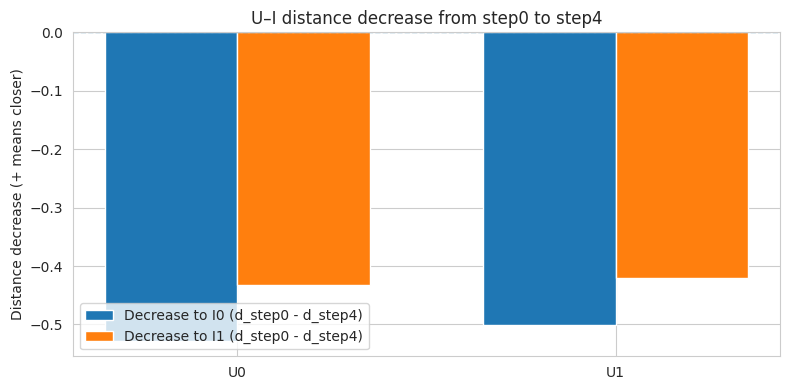


Saved plot -> /home/parkdw00/Codes/data/ml-1m/Augmentation_format/figs_tsne_cluster_progress/p0_to_p4_U_to_I_distance_decrease.png


In [77]:
csv_path = f"{BASE_DIR}/figs_tsne_cluster_progress/step4_RAW_center_distances_over_steps.csv"

df = pd.read_csv(csv_path)

# step0, step4가 정확히 있는지 확인 (없으면 가장 작은/큰 step 사용)
step_min = int(df["step"].min())
step_max = int(df["step"].max())

# 네가 원하는 게 step0/step4 고정이면 아래 두 줄을 쓰고,
# CSV에 없으면 KeyError/빈결과 날 수 있음.
s0 = 0
s4 = 4
if not ((df["step"] == s0).any() and (df["step"] == s4).any()):
    print(f"[warn] step {s0}/{s4}가 CSV에 없어서 {step_min}/{step_max}로 대체합니다.")
    s0, s4 = step_min, step_max

row0 = df.loc[df["step"] == s0].iloc[0]
row4 = df.loc[df["step"] == s4].iloc[0]

pairs = [
    ("U0", "I0", "ui_raw_U0_I0"),
    ("U0", "I1", "ui_raw_U0_I1"),
    ("U1", "I0", "ui_raw_U1_I0"),
    ("U1", "I1", "ui_raw_U1_I1"),
]

results = []
for u, i, col in pairs:
    d0 = float(row0[col])
    d4 = float(row4[col])
    dec = d0 - d4   # +면 가까워짐, -면 멀어짐
    results.append({"U": u, "I": i, "d_step0": d0, "d_step4": d4, "decrease": dec})

res = pd.DataFrame(results)

# U별 요약: I0/I1 감소량 비교 및 "I0쪽으로 더 가까워졌는지" 판단
summary_rows = []
for u in ["U0", "U1"]:
    dec_i0 = float(res[(res["U"] == u) & (res["I"] == "I0")]["decrease"].iloc[0])
    dec_i1 = float(res[(res["U"] == u) & (res["I"] == "I1")]["decrease"].iloc[0])
    # 감소량 차이(양수면 I0쪽으로 더 가까워짐)
    diff = dec_i0 - dec_i1
    summary_rows.append({
        "U": u,
        "step_start": s0,
        "step_end": s4,
        "decrease_to_I0": dec_i0,
        "decrease_to_I1": dec_i1,
        "diff(I0_minus_I1)": diff,
        "moved_more_toward": "I0" if diff > 0 else ("I1" if diff < 0 else "Same")
    })

summary = pd.DataFrame(summary_rows)

print("\n[raw distances + decreases]")
print(res.to_string(index=False))

print("\n[summary: compare decreases]")
print(summary.to_string(index=False))

# ---------------------------
# Visualization
# - U0, U1 각각에서 (I0 감소량, I1 감소량) 막대 비교
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 4))

x = np.arange(2)  # U0, U1
width = 0.35

dec_i0s = summary["decrease_to_I0"].values
dec_i1s = summary["decrease_to_I1"].values

ax.bar(x - width/2, dec_i0s, width, label="Decrease to I0 (d_step0 - d_step4)")
ax.bar(x + width/2, dec_i1s, width, label="Decrease to I1 (d_step0 - d_step4)")

ax.set_xticks(x)
ax.set_xticklabels(summary["U"].values)
ax.set_ylabel("Distance decrease (+ means closer)")
ax.set_title(f"U–I distance decrease from step{s0} to step{s4}")
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)
ax.legend()

plt.tight_layout()

out_png = os.path.join(os.path.dirname(csv_path), f"p{s0}_to_p{s4}_U_to_I_distance_decrease.png")
plt.savefig(out_png, dpi=220)
plt.show()

print("\nSaved plot ->", out_png)
